# Translational mapping

In this notebook we explicitely model the link between the regulatory and structural embeddings of the U2OS cells and evaluate their generalizability.

---


## 0. Enviromental setup

We first load the required packages and define a number of helper functions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import copy
from torch import nn
from torch.optim import Adam
import sys
from tqdm.notebook import tqdm
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import KElbowVisualizer
from torch.utils.data import DataLoader
import matplotlib as mpl
from sklearn.preprocessing import normalize
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
import os
import rff
import pickle
import traceback
import time

sys.path.append("../../../..")

from src.utils.notebooks.translation.analysis import *
from src.data.datasets import IndexedTensorDataset
from src.utils.basic.io import get_genesets_from_gmt_file

mpl.rcParams["figure.dpi"] = 300


seed = 1234

device = "cuda:0"

%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def compute_area_under_the_knn_curve(knn_acc_results, max_k=51):
    knn_accs = knn_acc_results.loc[knn_acc_results.k < max_k, "knn_acc"]
    return np.sum(knn_accs) / max_k

<IPython.core.display.Javascript object>

In [3]:
def get_knn_hit_data(nn_dict):
    idc = []
    hits = []
    for k, v in nn_dict.items():
        idc.append(k)
        hits.append(np.where(v == k)[0])
    hit_results = pd.DataFrame(np.array(hits), columns=["knn_hit"], index=idc)
    return hit_results

<IPython.core.display.Javascript object>

In [4]:
def read_in_loto_embs(
    root_dir,
    exp_dir,
    gae_exp,
    avg_pert_embs=True,
    normalize_reg_embs=False,
    exclude_ctrl=True,
):
    oe_targets = sorted(os.listdir(root_dir))

    pert_embs_dict = {}
    reg_embs_dict = {}
    for oe_target in tqdm(oe_targets):
        target_dir = os.path.join(root_dir, oe_target)
        pert_embs = pd.read_hdf(os.path.join(target_dir, "phy_embs.h5"))
        if exclude_ctrl:
            pert_embs = pert_embs.loc[pert_embs.labels != "EMPTY"]

        # Decide to read in average (bulk) or single-cell perturbation gene embeddings
        if avg_pert_embs:
            pert_embs_dict[oe_target] = pert_embs.groupby("labels").mean()
        else:
            pert_embs_dict[oe_target] = pert_embs

        reg_embs = pd.read_csv(
            os.path.join(target_dir, exp_dir, gae_exp, "node_embs.csv"), index_col=0
        )
        # Normalize gene embeddings such that euclidean distances correspond to cosine distances
        if normalize_reg_embs:
            reg_embs = pd.DataFrame(
                normalize(reg_embs), index=reg_embs.index, columns=reg_embs.columns
            )
        reg_embs_dict[oe_target] = reg_embs
    return pert_embs_dict, reg_embs_dict

<IPython.core.display.Javascript object>

In [5]:
from numpy.linalg import solve


class NTK:
    def __init__(self, reg=1):
        super().__init__()
        self.reg = reg
        self.sol = None
        self.Xtrain = None

    def kernel(self, pair1, pair2):

        out = pair1 @ pair2.T + 1
        N1 = np.sum(np.power(pair1, 2), axis=-1).reshape(-1, 1) + 1
        N2 = np.sum(np.power(pair2, 2), axis=-1).reshape(-1, 1) + 1

        XX = np.sqrt(N1 @ N2.T)
        out = out / XX

        out = np.clip(out, -1, 1)

        first = (
            1
            / np.pi
            * (out * (np.pi - np.arccos(out)) + np.sqrt(1.0 - np.power(out, 2)))
            * XX
        )
        sec = 1 / np.pi * out * (np.pi - np.arccos(out)) * XX
        out = first + sec

        C = 1
        return out / C

    def fit(self, Xtrain, ytrain):
        K = self.kernel(Xtrain, Xtrain)
        sol = solve(K + self.reg * np.eye(len(K)), ytrain).T
        self.sol = sol
        self.Xtrain = Xtrain
        return self

    def predict(self, X):
        K = self.kernel(self.Xtrain, X)
        return (self.sol @ K).T

<IPython.core.display.Javascript object>

In [6]:
class SyntheticInterventionModel:
    def __init__(self):
        super().__init__()
        self.alpha = None
        self.X_train = None
        self.Y_train = None

    def fit(self, X_train, Y_train):
        self.X_train = X_train
        self.Y_train = Y_train
        return self

    def predict(self, x_test):
        self.alpha = np.matmul(x_test, np.linalg.pinv(self.X_train))
        y_test = np.matmul(self.alpha, self.Y_train)
        return y_test

<IPython.core.display.Javascript object>

In [7]:
class MeanModel:
    def __init__(self):
        super().__init__()
        self.Y_train = None

    def fit(self, X_train, Y_train):
        self.Y_train = Y_train
        return self

    def predict(self, x_test=None):
        y_test = self.Y_train.mean(axis=0).reshape(1, -1)
        return y_test

<IPython.core.display.Javascript object>

In [8]:
def get_input_and_target_features(
    X_train,
    Y_train,
    x_test,
    use_y_train_mean=False,
    n_neighbors_weights_features=0,
    n_weight_encodings=10,
    neighbor_weight_encoding="positional",
    append_neighbor_embs=None,
    rff_sigma=1,
    cache_dir=None,
):
    pert_train_samples = list(X_train.index)
    test_target = list(x_test.index)[0]
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    x_test = np.array(x_test).reshape(1, -1)

    if use_y_train_mean:
        Y_train_mean = np.repeat(
            Y_train.mean(axis=0).reshape(1, -1), len(X_train), axis=0
        )
        X_train = np.concatenate([X_train, Y_train_mean], axis=-1)
        x_test = np.concatenate([x_test, Y_train_mean[0].reshape(1, -1)], axis=-1)

    ## Use Random Fourier Features of nearest neighbors of the training image embeddings
    if n_neighbors_weights_features > 0:
        nn = NearestNeighbors(n_neighbors=n_neighbors_weights_features)
        nn = nn.fit(X_train)
        X_train_and_test = np.concatenate([X_train, x_test], axis=0)
        neighbors_idcs = nn.kneighbors(X_train_and_test, return_distance=False)

        # Use cached SI coefficients if those are available to redce run-time
        # If the file does not exist but a cache directory is given - the SI coefficients are cached.
        try:
            filehandler = open(
                os.path.join(
                    cache_dir,
                    "neighbor_weights_{}_{}.pkl".format(
                        test_target, n_neighbors_weights_features
                    ),
                ),
                "rb",
            )
            neighbor_weights = pickle.load(filehandler)
            filehandler.close()
        except Exception:
            neighbor_weights = []
            for i in range(len(X_train_and_test)):
                neighbors_idc = neighbors_idcs[i]
                neighbors = X_train[neighbors_idc]
                neighbor_weight = np.matmul(
                    X_train_and_test[i], np.linalg.pinv(neighbors)
                )
                neighbor_weights.append(neighbor_weight)
            neighbors_weights = np.array(neighbor_weights)

            if cache_dir is not None:
                os.makedirs(cache_dir, exist_ok=True)
                filehandler = open(
                    os.path.join(
                        cache_dir,
                        "neighbor_weights_{}_{}.pkl".format(
                            test_target, n_neighbors_weights_features
                        ),
                    ),
                    "wb",
                )
                pickle.dump(neighbor_weights, filehandler)
                filehandler.close()

        neighbor_weights = torch.FloatTensor(neighbor_weights)
        if neighbor_weight_encoding == "positional":
            encoding = rff.layers.PositionalEncoding(
                sigma=rff_sigma, m=n_weight_encodings
            )
        elif neighbor_weight_encoding == "gauss":
            encoding = rff.layers.GaussianEncoding(
                sigma=rff_sigma,
                input_size=neighbor_weights.size(-1),
                encoded_size=n_weight_encodings,
            )
        neighbor_weights = encoding(neighbor_weights).cpu().detach().numpy()

        X_train = np.concatenate([X_train, neighbor_weights[:-1]], axis=-1)
        x_test = np.concatenate([x_test, neighbor_weights[-1].reshape(1, -1)], axis=-1)

        # If desired append embeddings of the nearest neighbors (imaging or regulatory) as additional features
        if append_neighbor_embs is not None:
            neighbor_embs = []
            for i in range(len(X_train_and_test)):
                neighbors_idc = neighbors_idcs[i]
                if append_neighbor_embs == "images":
                    neighbors = X_train[neighbors_idc]
                elif append_neighbor_embs == "genes":
                    neighbors = Y_train[neighbors_idc]
                else:
                    raise NotImplementedError
                neighbor_embs.append(neighbors.reshape(-1))
            neighbor_embs = np.array(neighbor_embs)
            X_train = np.concatenate([X_train, neighbor_embs[:-1]], axis=-1)
            x_test = np.concatenate([x_test, neighbor_embs[-1].reshape(1, -1)], axis=-1)
    return X_train, Y_train, x_test

<IPython.core.display.Javascript object>

In [9]:
def get_prediction_for_model(
    X_train,
    Y_train,
    x_test,
    model_type="synthetic_intervention",
    model_params_dict=None,
    model=None,
    Y_all=None,
    use_y_train_mean=False,
    n_neighbors_weights_features=0,
    n_weight_encodings=10,
    neighbor_weight_encoding=None,
    append_neighbor_embs=None,
    rff_sigma=1,
    normalize_prediction=False,
):
    start_time = time.time()
    # Get potentially transformed input and target features
    X_train, Y_train, x_test = get_input_and_target_features(
        X_train=X_train,
        Y_train=Y_train,
        x_test=x_test,
        use_y_train_mean=use_y_train_mean,
        n_neighbors_weights_features=n_neighbors_weights_features,
        n_weight_encodings=n_weight_encodings,
        neighbor_weight_encoding=neighbor_weight_encoding,
        append_neighbor_embs=append_neighbor_embs,
        rff_sigma=rff_sigma,
    )

    # print("Get features", time.time()-start_time)

    # Initialize model
    if model_type == "synthetic_intervention":
        model = SyntheticInterventionModel()
    elif model_type == "linear_regression":
        model = LinearRegression()
    elif model_type == "kernel_regression":
        if model_params_dict is None:
            model = KernelRidge()
        else:
            model = KernelRidge(**model_params_dict)
    elif model_type == "mean":
        model = MeanModel()
    elif model_type == "mean_all":
        model = MeanModel()
        Y_train = np.array(Y_all)
    elif model_type == "ntk":
        if model_params_dict is not None:
            model = NTK(**model_params_dict)
        else:
            model = NTK()
    else:
        if model is not None:
            model = model.fit(X_train, Y_train)
        else:
            raise NotImplementedError

    # Fit model and predict
    model = model.fit(X_train, Y_train)
    y_test = model.predict(x_test)

    if normalize_prediction:
        y_test = normalize(y_test)

    # print("Total time", time.time() - start_time)
    return y_test

<IPython.core.display.Javascript object>

In [10]:
def get_nn_prediction_dict(
    reg_embs_dict,
    pert_embs_dict,
    model_type="synthethic_intervention",
    model_params_dict=None,
    use_y_train_mean=False,
    n_neighbors_weights_features=0,
    n_weight_encodings=10,
    neighbor_weight_encoding=None,
    append_neighbor_embs=None,
    rff_sigma=1,
    model=None,
    permute=False,
    debug=False,
    return_predicted_embeddings=False,
):
    nn_pred_dict = {}
    emb_pred_dict = {}
    oe_targets = set(list(reg_embs_dict.values())[0].index)
    oe_targets = oe_targets.intersection(list(pert_embs_dict.values())[0].index)
    for target in sorted(list(oe_targets)):

        # Get perturbation and regulatory gene embeddings for hold-out gene target.
        reg_embs = reg_embs_dict[target]
        pert_embs = pert_embs_dict[target]

        # Randomly permute both embeddings to compute a random baseline
        if permute:
            reg_embs = pd.DataFrame(
                np.random.permutation(np.array(reg_embs)),
                index=reg_embs.index,
                columns=reg_embs.columns,
            )
            pert_embs = pd.DataFrame(
                np.random.permutation(np.array(pert_embs)),
                index=pert_embs.index,
                columns=pert_embs.columns,
            )

        # Identify genes with both corresponding perturbation and regulatory gene embeddings
        shared_targets = set(reg_embs.index).intersection(pert_embs.index)
        # Focus on the perturbation gene embeddings with corresponding regulatory gene embeddings
        pert_embs = pert_embs.loc[shared_targets]

        # Estimate the NearestNeighbor graph of the regulatory gene embeddings using euclidean distances
        reg_nn = NearestNeighbors(n_neighbors=len(reg_embs))
        reg_samples = np.array(list(reg_embs.index))
        reg_nn.fit(np.array(reg_embs))

        # Extract perturbation gene names
        pert_samples = np.array(list(pert_embs.index))

        # Identify the test and train samples as the perturbation gene embeddings of the hold-out gene target
        # and all others respectively
        x_test = pert_embs.loc[pert_samples == target]
        X_train = pert_embs.loc[pert_samples != target]

        # Get corresponding regulatory gene embeddings of training samples
        Y_train = reg_embs.loc[pert_samples[pert_samples != target]]

        X_train = X_train.sort_index()
        Y_train = Y_train.loc[list(X_train.index)]

        # Get the predicted regulatory gene embedding for the hold-out gene target
        y_test = get_prediction_for_model(
            X_train=X_train,
            Y_train=Y_train,
            x_test=x_test,
            model_type=model_type,
            model_params_dict=model_params_dict,
            use_y_train_mean=use_y_train_mean,
            n_neighbors_weights_features=n_neighbors_weights_features,
            n_weight_encodings=n_weight_encodings,
            neighbor_weight_encoding=neighbor_weight_encoding,
            append_neighbor_embs=append_neighbor_embs,
            rff_sigma=rff_sigma,
            model=model,
            Y_all=reg_embs,
        )
        emb_pred_dict[target] = y_test
        # Identify the sorted nearest neighbor list of the prediction among all regulatory gene embeddings
        reg_nns = reg_samples[reg_nn.kneighbors(y_test, return_distance=False)][0]
        nn_pred_dict[target] = reg_nns

        if not permute and debug:
            print(model_type, target, reg_nns[:5])
            print(y_test)

    # Return a dictionary with the key identifying the hold-out gene target and the corresponding value the
    # names of the regulatory gene embeddings closest to the prediction in increasing euclidean distance
    if not return_predicted_embeddings:
        return nn_pred_dict
    else:
        return nn_pred_dict, emb_pred_dict

<IPython.core.display.Javascript object>

In [11]:
def get_knn_acc_from_nn_dict(nn_dict, ks=list(range(1, 51))):
    # Function to compute for varying ks whether or not the regulatory gene embedding of the hold-out target
    # is among the k-nearest neighbors of the prediction using the nearest neighbor dictionary of the prediction
    idc = []
    topk_dict = {}
    for target, nns in nn_dict.items():
        idc.append(target)
        for k in ks:
            if "top-{}".format(k) not in topk_dict:
                topk_dict["top-{}".format(k)] = []
            topk_dict["top-{}".format(k)].append(int(target in list(nns)[:k]))
    topk_result = pd.DataFrame(topk_dict, index=idc)
    return topk_result

<IPython.core.display.Javascript object>

In [12]:
def get_knn_acc_for_model(
    reg_embs_dict,
    pert_embs_dict,
    model_type="synthetic_intervention",
    model=None,
    model_params_dict=None,
    use_y_train_mean=False,
    n_neighbors_weights_features=0,
    neighbor_weight_encoding=None,
    append_neighbor_embs=None,
    n_weight_encodings=10,
    rff_sigma=1,
    ks=None,
):
    # Function to compute the nearest neighbor accuracy for a given set of perturbation and
    # regulatory gene embeddings for a specified model type
    n_shared_targets = len(
        set(list(pert_embs_dict.values())[0].index).intersection(
            list(reg_embs_dict.values())[0].index
        )
    )
    if ks is None:
        ks = list(range(1, 51))
    knn_acc_results = {"knn_acc": [], "k": []}

    # Get nearest-neighbor prediction dictionary
    nn_dict = get_nn_prediction_dict(
        reg_embs_dict=reg_embs_dict,
        pert_embs_dict=pert_embs_dict,
        model_type=model_type,
        model=model,
        model_params_dict=model_params_dict,
        use_y_train_mean=use_y_train_mean,
        n_neighbors_weights_features=n_neighbors_weights_features,
        n_weight_encodings=n_weight_encodings,
        neighbor_weight_encoding=neighbor_weight_encoding,
        append_neighbor_embs=append_neighbor_embs,
        rff_sigma=rff_sigma,
        permute=False,
    )
    knn_acc = get_knn_acc_from_nn_dict(nn_dict, ks=ks)
    avg_knn_acc = knn_acc.mean()
    for k in ks:
        knn_acc_results["knn_acc"].append(avg_knn_acc.loc["top-{}".format(k)])
        knn_acc_results["k"].append(k)
    knn_acc_results = pd.DataFrame(knn_acc_results)
    return knn_acc_results

<IPython.core.display.Javascript object>

In [13]:
def get_perm_knn_acc_for_model(
    reg_embs_dict,
    pert_embs_dict,
    model_type="synthetic_intervention",
    model_params_dict=None,
    model=None,
    use_y_train_mean=False,
    n_neighbors_weights_features=0,
    n_weight_encodings=10,
    neighbor_weight_encoding=None,
    append_neighbor_embs=None,
    rff_sigma=1,
    ks=None,
    b=500,
    random_state=1234,
    n_clusters=None,
):
    # Function that also computes the knn accuracy for a given model/type but randomly permutes the perturbation
    # and regulatory gene embeddings to establish a random baseline

    if n_clusters is not None:
        reduced_reg_embs_dict = get_reduced_reg_embs_dict(
            reg_embs_dict, n_clusters=n_clusters
        )
    else:
        reduced_reg_embs_dict = reg_embs_dict

    n_shared_targets = len(
        set(list(pert_embs_dict.values())[0].index).intersection(
            list(reduced_reg_embs_dict.values())[0].index
        )
    )

    np.random.seed(random_state)
    if ks is None:
        ks = list(range(1, 51))
    knn_acc_results = {"knn_acc": [], "k": []}
    for i in tqdm(range(b)):
        nn_dict = get_nn_prediction_dict(
            reg_embs_dict=reduced_reg_embs_dict,
            pert_embs_dict=pert_embs_dict,
            model_type=model_type,
            model_params_dict=model_params_dict,
            use_y_train_mean=use_y_train_mean,
            n_neighbors_weights_features=n_neighbors_weights_features,
            n_weight_encodings=n_weight_encodings,
            neighbor_weight_encoding=neighbor_weight_encoding,
            append_neighbor_embs=append_neighbor_embs,
            rff_sigma=rff_sigma,
            model=model,
            permute=True,
        )
        knn_acc = get_knn_acc_from_nn_dict(nn_dict, ks=ks)
        avg_knn_acc = knn_acc.mean()
        for k in ks:
            knn_acc_results["knn_acc"].append(avg_knn_acc.loc["top-{}".format(k)])
            knn_acc_results["k"].append(k)
    knn_acc_results = pd.DataFrame(knn_acc_results)
    return knn_acc_results

<IPython.core.display.Javascript object>

In [14]:
def get_reduced_reg_embs_dict(
    reg_embs_dict, n_clusters=5, affinity="euclidean", linkage="complete"
):
    # Function to filter out genes that do not cluster with any of the genes with corresponding perturbation gene
    # embeddings. This is supposed to enable the derivation of a more conservative baseline where only any of the
    # genes clustering with the genes with corresponding perturbation gene embeddings can be randomly predicted.
    reduced_reg_embs_dict = copy.deepcopy(reg_embs_dict)
    for k, v in reduced_reg_embs_dict.items():
        agglo_cl = AgglomerativeClustering(
            n_clusters=n_clusters, affinity=affinity, linkage=linkage
        )
        cluster_labels = agglo_cl.fit_predict(np.array(v))
        cluster_labels = pd.DataFrame(
            cluster_labels, columns=["cluster"], index=v.index
        )
        target_clusters = np.unique(
            cluster_labels.loc[
                cluster_labels.index.isin(list(reduced_reg_embs_dict.keys()))
            ]
        )
        reduced_reg_embs_dict[k] = v.loc[
            cluster_labels.loc[cluster_labels.cluster.isin(target_clusters)].index
        ]
    return reduced_reg_embs_dict

<IPython.core.display.Javascript object>

In [15]:
def get_random_baseline_knn_acc(
    reg_embs_dict, pert_embs_dict, b=1000, random_state=1234, ks=None
):
    # Function to compute the nearest neighbor accuracy for a given set of perturbation and
    # regulatory gene embeddings for a specified model type
    np.random.seed(random_state)
    n_shared_targets = len(
        set(list(pert_embs_dict.values())[0].index).intersection(
            list(reg_embs_dict.values())[0].index
        )
    )
    if ks is None:
        ks = list(range(1, 51))
    knn_acc_results = {"knn_acc": [], "k": []}

    # Get nearest-neighbor prediction dictionary
    for i in tqdm(range(b)):
        nn_dict = get_random_nn_prediction_dict(
            reg_embs_dict=reg_embs_dict,
            pert_embs_dict=pert_embs_dict,
        )
        knn_acc = get_knn_acc_from_nn_dict(nn_dict, ks=ks)
        avg_knn_acc = knn_acc.mean()
        for k in ks:
            knn_acc_results["knn_acc"].append(avg_knn_acc.loc["top-{}".format(k)])
            knn_acc_results["k"].append(k)
    knn_acc_results = pd.DataFrame(knn_acc_results)
    return knn_acc_results

<IPython.core.display.Javascript object>

In [16]:
def get_random_nn_prediction_dict(reg_embs_dict, pert_embs_dict):
    nn_pred_dict = {}
    oe_targets = set(list(reg_embs_dict.values())[0].index)
    oe_targets = oe_targets.intersection(list(pert_embs_dict.values())[0].index)
    for target in sorted(list(oe_targets)):

        # Get perturbation and regulatory gene embeddings for hold-out gene target.
        reg_embs = reg_embs_dict[target]
        pert_embs = pert_embs_dict[target]

        # Estimate the NearestNeighbor graph of the regulatory gene embeddings using euclidean distances
        reg_nn = NearestNeighbors(n_neighbors=len(reg_embs))
        reg_samples = np.array(list(reg_embs.index))
        reg_nn.fit(np.array(reg_embs))

        y_test_idc = np.random.choice(list(reg_embs.index))
        y_test = np.array(reg_embs.loc[y_test_idc]).reshape(1, -1)
        # Identify the sorted nearest neighbor list of the prediction among all regulatory gene embeddings
        reg_nns = reg_samples[reg_nn.kneighbors(y_test, return_distance=False)][0]
        nn_pred_dict[target] = reg_nns

    # Return a dictionary with the key identifying the hold-out gene target and the corresponding value the
    # names of the regulatory gene embeddings closest to the prediction in increasing euclidean distance
    return nn_pred_dict

<IPython.core.display.Javascript object>

In [17]:
def get_knn_accs_for_random_baseline(
    reg_embs_dict,
    pert_embs_dict,
    alpha,
    beta,
    gamma,
    graph,
    cluster,
    b=1000,
    ks=None,
    auc_ks=[6, 11, 16, 21, 26, 31, 51],
    random_state=1234,
):
    knn_acc_results = get_random_baseline_knn_acc(
        reg_embs_dict=reg_embs_dict,
        pert_embs_dict=pert_embs_dict,
        b=b,
        random_state=random_state,
    )
    for k in auc_ks:
        knn_acc_results["{}nn_auc".format(k - 1)] = compute_area_under_the_knn_curve(
            knn_acc_results, max_k=k
        )
    knn_acc_results["alpha"] = alpha
    knn_acc_results["beta"] = beta
    knn_acc_results["gamma"] = gamma
    knn_acc_results["graph"] = graph
    knn_acc_results["cluster"] = cluster
    knn_acc_results["model"] = "random"
    return knn_acc_results

<IPython.core.display.Javascript object>

In [18]:
def get_all_loto_knn_accs_for_model(
    reg_embs_dict,
    pert_embs_dict,
    alpha,
    beta,
    gamma,
    graph,
    cluster,
    config_id=None,
    model_type="synthetic_intervention",
    model_params_dict=None,
    model=None,
    use_y_train_mean=False,
    n_neighbors_weights_features=0,
    n_weight_encodings=10,
    neighbor_weight_encoding=None,
    append_neighbor_embs=None,
    rff_sigma=1,
    b=50,
    n_clusters=5,
    auc_ks=[6, 11, 16, 21, 26, 31, 51],
):
    knn_acc_results = get_knn_acc_for_model(
        reg_embs_dict=reg_embs_dict,
        pert_embs_dict=pert_embs_dict,
        model_type=model_type,
        model_params_dict=model_params_dict,
        model=model,
        use_y_train_mean=use_y_train_mean,
        n_neighbors_weights_features=n_neighbors_weights_features,
        n_weight_encodings=n_weight_encodings,
        neighbor_weight_encoding=neighbor_weight_encoding,
        append_neighbor_embs=append_neighbor_embs,
        rff_sigma=rff_sigma,
    )
    for k in auc_ks:
        knn_acc_results["{}nn_auc".format(k - 1)] = compute_area_under_the_knn_curve(
            knn_acc_results, max_k=k
        )
    knn_acc_results["alpha"] = alpha
    knn_acc_results["beta"] = beta
    knn_acc_results["gamma"] = gamma
    knn_acc_results["graph"] = graph
    knn_acc_results["cluster"] = cluster
    knn_acc_results["model"] = model_type
    for k, v in model_params_dict.items():
        knn_acc_results[k] = v
    knn_acc_results["use_mean_train_reg_embs"] = use_y_train_mean
    knn_acc_results["n_neighbors_pos_encodings"] = n_neighbors_weights_features
    knn_acc_results["n_pos_encodings"] = n_weight_encodings
    knn_acc_results["pos_encoding_type"] = neighbor_weight_encoding
    knn_acc_results["append_neighbor_embs"] = append_neighbor_embs
    knn_acc_results["rff_sigma"] = rff_sigma
    knn_acc_results["config_id"] = config_id

    if b > 0:
        perm_knn_acc_results = get_perm_knn_acc_for_model(
            reg_embs_dict=reg_embs_dict,
            pert_embs_dict=pert_embs_dict,
            model_type=model_type,
            model_param_dict=model_param_dict,
            model=model,
            use_y_train_mean=use_y_train_mean,
            n_neighbors_weights_features=n_neighbors_weights_features,
            n_weight_encodings=n_weight_encodings,
            neighbor_weight_encoding=neighbor_weight_encoding,
            append_neighbor_embs=append_neighbor_embs,
            b=b,
        )
        for k in auc_ks:
            perm_knn_acc_results[
                "{}nn_auc".format(k - 1)
            ] = compute_area_under_the_knn_curve(perm_knn_acc_results, max_k=k)
        perm_knn_acc_results["alpha"] = alpha
        perm_knn_acc_results["beta"] = beta
        perm_knn_acc_results["gamma"] = gamma
        perm_knn_acc_results["graph"] = graph
        perm_knn_acc_results["cluster"] = cluster
        perm_knn_acc_results["model"] = model_type
        for k, v in model_params_dict.items():
            perm_knn_acc_results[k] = v
        perm_knn_acc_results["use_mean_train_reg_embs"] = use_y_train_mean
        perm_knn_acc_results["n_neighbors_pos_encodings"] = n_neighbors_weights_features
        perm_knn_acc_results["n_pos_encodings"] = n_weight_encodings
        perm_knn_acc_results["pos_encoding_type"] = neighbor_weight_encoding
        perm_knn_acc_results["append_neighbor_embs"] = append_neighbor_embs
        perm_knn_acc_results["rff_sigma"] = rff_sigma
        perm_knn_acc_results["config_id"] = config_id

        perm_cluster_knn_acc_results = get_perm_knn_acc_for_model(
            reg_embs_dict=reg_embs_dict,
            pert_embs_dict=pert_embs_dict,
            model_type=model_type,
            model_param_dict=model_param_dict,
            model=model,
            use_y_train_mean=use_y_train_mean,
            n_neighbors_weights_features=n_neighbors_weights_features,
            n_weight_encodings=n_weight_encodings,
            neighbor_weight_encoding=neighbor_weight_encoding,
            append_neighbor_embs=append_neighbor_embs,
            b=b,
            n_clusters=n_clusters,
        )
        for k in auc_ks:
            perm_cluster_knn_acc_results[
                "{}nn_auc".format(k - 1)
            ] = compute_area_under_the_knn_curve(perm_cluster_knn_acc_results, max_k=k)
        perm_cluster_knn_acc_results["alpha"] = alpha
        perm_cluster_knn_acc_results["beta"] = beta
        perm_cluster_knn_acc_results["gamma"] = gamma
        perm_cluster_knn_acc_results["graph"] = graph
        perm_cluster_knn_acc_results["cluster"] = cluster
        perm_cluster_knn_acc_results["model"] = model_type
        for k, v in model_params_dict.items():
            perm_cluster_knn_acc_results[k] = v
        perm_cluster_knn_acc_results["use_mean_train_reg_embs"] = use_y_train_mean
        perm_cluster_knn_acc_results[
            "n_neighbors_pos_encodings"
        ] = n_neighbors_weights_features
        perm_cluster_knn_acc_results["n_pos_encodings"] = n_weight_encodings
        perm_cluster_knn_acc_results["pos_encoding_type"] = neighbor_weight_encoding
        perm_cluster_knn_acc_results["append_neighbor_embs"] = append_neighbor_embs
        perm_cluster_knn_acc_results["rff_sigma"] = rff_sigma
        perm_cluster_knn_acc_results["config_id"] = config_id
    else:
        perm_knn_acc_results = None
        perm_cluster_knn_acc_results = None

    return knn_acc_results, perm_knn_acc_results, perm_cluster_knn_acc_results

<IPython.core.display.Javascript object>

In [19]:
def plot_translation_performance(
    results,
    hue,
    ymax,
    title="",
    random_baseline=None,
    mean_baseline=None,
    mean_train_baseline=None,
    figsize=[9, 6],
    cmap=None,
    style=None,
    style_order=None,
    param_title=None,
    legend_title="Model",
    alpha=0.8,
):
    sns.set_style("whitegrid")
    if param_title is None:
        param_title = hue
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.lineplot(
        data=results,
        x="k",
        y="knn_acc",
        hue=hue,
        palette=cmap,
        style=style,
        style_order=style_order,
        alpha=alpha,
    )
    if mean_train_baseline is not None:
        ax = sns.lineplot(
            data=mean_train_baseline,
            x="k",
            y="knn_acc",
            ax=ax,
            label="Mean baseline (train)",
            color="silver",
            legend=False,
            alpha=alpha,
        )
    if mean_baseline is not None:
        ax = sns.lineplot(
            data=mean_baseline,
            x="k",
            y="knn_acc",
            ax=ax,
            label="Mean baseline",
            color="r",
            linestyle="--",
            legend=False,
            alpha=alpha,
        )
    if random_baseline is not None:
        ax = sns.lineplot(
            data=random_baseline,
            x="k",
            y="knn_acc",
            ax=ax,
            label="Random baseline",
            color="dimgray",
            linestyle="--",
            legend=False,
            alpha=alpha,
        )
    ax.set_title(title)
    ax.set_xticks(np.arange(0, 51, 5))
    ax.set_yticks(np.arange(0, ymax, 0.05))
    ax.legend(title=legend_title, loc="upper left", frameon=True)

    return fig, ax

<IPython.core.display.Javascript object>

In [20]:
def run_gridsearch_knn_accuracy(
    exp_embs_dict,
    model_type,
    model=None,
    model_params_dicts=[None],
    use_y_train_mean_params=[False],
    n_neighbors_weights_features_params=[0],
    n_weight_encodings_params=[0],
    append_neighbor_embs_params=[False],
    neighbor_weight_encoding_params=[None],
    rff_sigma_params=[1],
    save_output_file=None,
):
    grid_search_knn_acc_results_dict = {}

    for exp, embs_dict in exp_embs_dict.items():
        all_knn_acc_results = []

        reg_embs_dict = embs_dict["reg_embs"]
        pert_embs_dict = embs_dict["pert_embs"]

        exp_params = exp.split("_")
        alpha = int(exp_params[2][1])
        beta = int(exp_params[3][1])
        gamma = int(exp_params[4][1])
        graph = exp_params[5]
        cluster = "_".join(exp_params[7:])
        if cluster[-1].isnumeric():
            cluster = cluster[:-2]
        print(
            "Analyze Experiment: a={}, b={}, g={}, graph={}, cluster={}".format(
                alpha, beta, gamma, graph, cluster
            )
        )
        config_id = 0

        for i in tqdm(range(len(model_params_dicts))):
            for use_y_train_mean in use_y_train_mean_params:
                for n_neighbors_weights_features in n_neighbors_weights_features_params:
                    for n_weight_encodings in n_weight_encodings_params:
                        for append_neighbor_embs in append_neighbor_embs_params:
                            for (
                                neighbor_weight_encoding
                            ) in neighbor_weight_encoding_params:
                                #                                 print(
                                #                                     n_neighbors_weights_features,
                                #                                     n_weight_encodings,
                                #                                     append_neighbor_embs,
                                #                                     neighbor_weight_encoding_params,
                                #                                 )
                                for rff_sigma in tqdm(rff_sigma_params, leave=False):
                                    model_params_dict = model_params_dicts[i]
                                    try:
                                        (
                                            knn_acc_results,
                                            _,
                                            _,
                                        ) = get_all_loto_knn_accs_for_model(
                                            reg_embs_dict=reg_embs_dict,
                                            pert_embs_dict=pert_embs_dict,
                                            alpha=alpha,
                                            beta=beta,
                                            gamma=gamma,
                                            graph=graph,
                                            cluster=cluster,
                                            config_id=config_id,
                                            model_type=model_type,
                                            model_params_dict=model_params_dict,
                                            model=model,
                                            use_y_train_mean=use_y_train_mean,
                                            n_neighbors_weights_features=n_neighbors_weights_features,
                                            n_weight_encodings=n_weight_encodings,
                                            append_neighbor_embs=append_neighbor_embs,
                                            neighbor_weight_encoding=neighbor_weight_encoding,
                                            rff_sigma=rff_sigma,
                                            b=0,
                                            n_clusters=None,
                                        )
                                        all_knn_acc_results.append(
                                            knn_acc_results.copy()
                                        )
                                        config_id += 1
                                    except IndexError:
                                        traceback.print_exc()
                                        continue
        all_knn_acc_results = pd.concat(all_knn_acc_results)
        grid_search_knn_acc_results_dict[exp] = all_knn_acc_results.copy()

        if save_output_file is not None:
            with open(save_output_file, "wb") as f:
                pickle.dump(
                    grid_search_knn_acc_results_dict, f, pickle.HIGHEST_PROTOCOL
                )

    return grid_search_knn_acc_results_dict

<IPython.core.display.Javascript object>

In [21]:
def plot_gs_results(model_results, mean_results, mean_all_results):
    exps = np.unique(model_results.exp)
    for exp in exps:
        selected_model_results = model_results.loc[model_results.exp == exp]
        config_ids = np.unique(selected_model_results.config_id)
        for config_id in config_ids:
            selected_model_result = selected_model_results.loc[
                selected_model_results.config_id == config_id
            ]
            fig, ax = plot_translation_performance(
                results=selected_model_result,
                mean_baseline=mean_results,
                mean_all_baseline=mean_all_results,
                hue="model",
                ymax=1.05,
                figsize=[6, 6],
            )
            ax.set_title("Exp: {}, Config: {}".format(exp, config_id))
            plt.show()
            plt.close()

<IPython.core.display.Javascript object>

In [22]:
def output_best_model_config_ids(
    results, metric_cols, config_id_col="config_id", n_config_ids=1
):
    opt_metrics_dict = {"config_id": [], "metric": [], "value": []}
    grouped = results.groupby(config_id_col).mean()
    for metric_col in metric_cols:
        opt_results = grouped.sort_values(metric_col, ascending=False).iloc[
            :n_config_ids
        ]

        opt_config_ids = list(opt_results.index)
        opt_metrics = list(np.round(opt_results.loc[:, metric_col], 6))

        opt_metrics_dict["config_id"].extend(opt_config_ids)
        opt_metrics_dict["value"].extend(opt_metrics)
        opt_metrics_dict["metric"].extend([metric_col] * len(opt_config_ids))

    opt_metrics_df = pd.DataFrame(opt_metrics_dict)
    duplicate_config_ids = []
    for k, v in Counter(opt_metrics_df.config_id).items():
        if v >= 2:
            duplicate_config_ids.append(k)
    return opt_metrics_df.loc[opt_metrics_df.config_id.isin(duplicate_config_ids)]

<IPython.core.display.Javascript object>

In [23]:
def get_knn_acc_results_dict_for_random(exp_embs_dict, b=1000, random_state=1234):
    random_knn_acc_results_dict = {}
    for exp, embs_dict in exp_embs_dict.items():

        reg_embs_dict = embs_dict["reg_embs"]
        pert_embs_dict = embs_dict["pert_embs"]

        exp_params = exp.split("_")
        alpha = int(exp_params[2][1])
        beta = int(exp_params[3][1])
        gamma = int(exp_params[4][1])
        graph = exp_params[5]
        cluster = "_".join(exp_params[7:])
        if cluster[-1].isnumeric():
            cluster = cluster[:-2]
        print(
            "Analyze Experiment: a={}, b={}, g={}, graph={}, cluster={}".format(
                alpha, beta, gamma, graph, cluster
            )
        )

        knn_acc_results = get_knn_accs_for_random_baseline(
            reg_embs_dict=reg_embs_dict,
            pert_embs_dict=pert_embs_dict,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            graph=graph,
            cluster=cluster,
            b=b,
            random_state=random_state,
        )
        random_knn_acc_results_dict[exp] = knn_acc_results
    return random_knn_acc_results_dict

<IPython.core.display.Javascript object>

In [24]:
def plot_tsne_embs(
    embs,
    ax,
    target,
    target_size=12,
    reg_size=8,
    target_label_size=12,
    reg_label_size=10,
    label_points=None,
    random_state=1234,
):
    ax.scatter(
        np.array(embs.loc[:, "tsne1"]),
        np.array(embs.loc[:, "tsne2"]),
        c="b",
        s=reg_size,
    )
    ax.scatter(
        np.array(embs.loc[target, "tsne1"]),
        np.array(embs.loc[target, "tsne2"]),
        c="r",
        s=target_size,
    )
    if label_points is not None:
        to_label_embs = embs.loc[embs.index.isin(label_points)]
        label_point(
            np.array(to_label_embs.loc[:, "tsne1"]),
            np.array(to_label_embs.loc[:, "tsne2"]),
            np.array(to_label_embs.index).astype("str"),
            ax=ax,
            reg_size=reg_label_size,
            highlight=target,
            highlight_size=target_label_size,
        )
    return ax

<IPython.core.display.Javascript object>

In [25]:
def label_point(
    x, y, val, ax, reg_size=10, highlight_size=10, highlight=None, highlight_other=None
):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    for i in range(len(x)):
        if highlight is not None and val[i] == highlight:
            c = "r"
            weight = "bold"
            size = highlight_size
        elif highlight_other is not None and val[i] in highlight_other:
            c = "b"
            weight = "bold"
        else:
            c = "k"
            weight = "normal"
            size = reg_size
        if x[i] > xmin and x[i] < xmax and y[i] > ymin and y[i] < ymax:
            ax.text(x[i] + 0.02, y[i], val[i], {"size": size, "c": c, "weight": weight})

<IPython.core.display.Javascript object>

In [26]:
def get_tsne_translation_prediction(
    pert_embs_dict,
    reg_embs_dict,
    target,
    reg_pred_dict,
    perplexity=None,
    random_state=1234,
    init="random",
    metric="euclidean",
):
    pert_embs = pert_embs_dict[target]
    reg_embs = reg_embs_dict[target]
    reg_pred = reg_pred_dict[target]

    reg_embs_w_target = reg_embs.copy()
    reg_embs_w_target.loc["PREDICTION"] = reg_pred.reshape(-1)

    if perplexity is None:
        pert_perplexity = np.ceil(np.sqrt(len(pert_embs)))
        reg_perplexity = np.ceil(np.sqrt(len(reg_embs_w_target)))
    else:
        pert_perplexity = reg_perplexity = perplexity

    # Perturbation gene embedding tsne
    tsne_pert = TSNE(
        random_state=random_state,
        n_components=2,
        perplexity=pert_perplexity,
        metric=metric,
        init=init,
    )
    pert_tsne_embs = pd.DataFrame(
        tsne_pert.fit_transform(pert_embs),
        columns=["tsne1", "tsne2"],
        index=pert_embs.index,
    )

    # Regulatory gene embedding tsne
    tsne_reg = TSNE(
        random_state=random_state,
        n_components=2,
        perplexity=reg_perplexity,
        metric=metric,
        init=init,
    )
    reg_tsne_embs = pd.DataFrame(
        tsne_reg.fit_transform(reg_embs_w_target),
        columns=["tsne1", "tsne2"],
        index=reg_embs_w_target.index,
    )
    return pert_tsne_embs, reg_tsne_embs

<IPython.core.display.Javascript object>

In [27]:
def get_nearest_neighbors_for_target(
    embs, target, prediction=None, selected_targets=None
):
    if prediction is not None:
        tmp = embs.copy()
        tmp.loc["PREDICTION"] = np.array(prediction).reshape(-1)
        target = "PREDICTION"
    else:
        tmp = embs.copy()

    if selected_targets:
        tmp = tmp.loc[selected_targets]
    samples = np.array(tmp.index)
    nn = NearestNeighbors(n_neighbors=len(tmp))
    nn = nn.fit(tmp)
    knns = nn.kneighbors(
        np.array(tmp.loc[target]).reshape(1, -1), return_distance=False
    )
    return samples[knns]

<IPython.core.display.Javascript object>

In [28]:
def plot_translation(
    embs,
    fig,
    ax,
    target=None,
    prediction=None,
    target_size=20,
    size=15,
    pred_size=20,
    pred_color="r",
    target_color="green",
    color="b",
    lw=1,
    alpha=1,
    marker_lw=2,
    p_alpha=0.7,
    mark_neighbors=None,
    neighbor_size=8,
    label_points=None,
    reg_label_size=12,
):

    exclude = []
    if prediction is not None:
        exclude.append(prediction)
    if target is not None:
        exclude.append(target)

    ax.scatter(
        np.array(embs.loc[~embs.index.isin(exclude), "tsne1"]),
        np.array(embs.loc[~embs.index.isin(exclude), "tsne2"]),
        c=color,
        s=size,
        zorder=1,
        alpha=p_alpha,
    )

    if mark_neighbors is not None:
        ax.scatter(
            np.array(embs.loc[mark_neighbors, "tsne1"]),
            np.array(embs.loc[mark_neighbors, "tsne2"]),
            c="k",
            s=neighbor_size,
            zorder=1,
            alpha=1,
            edgecolors="k",
        )

    if target is not None:
        ax.scatter(
            np.array(embs.loc[target, "tsne1"]),
            np.array(embs.loc[target, "tsne2"]),
            c=target_color,
            s=target_size,
            zorder=1,
            alpha=1,
            facecolors=target_color,
            edgecolors=target_color,
        )
    if prediction is not None:
        ax.scatter(
            np.array(embs.loc[prediction, "tsne1"]),
            np.array(embs.loc[prediction, "tsne2"]),
            # c=pred_color,
            s=pred_size,
            zorder=1,
            facecolors="none",
            edgecolors=pred_color,
            linewidth=marker_lw,
            alpha=1,
        )

    if label_points is not None:
        to_label_embs = embs.loc[embs.index.isin(label_points)]
        label_point(
            np.array(to_label_embs.loc[:, "tsne1"]),
            np.array(to_label_embs.loc[:, "tsne2"]),
            np.array(to_label_embs.index).astype("str"),
            ax=ax,
            reg_size=reg_label_size,
            # highlight=target,
            # highlight_size=target_label_size,
        )

    return fig, ax

<IPython.core.display.Javascript object>

---

## 1. Read in data

Next, we read in the different data sets that we will use for the modelling and evaluation of the translational mappings in the leave-one-target-out setup. That is we will load for a given model configuration the respective gene regulatory and physical embeddings.

In [29]:
root_dir = "../../../../data/experiments/rohban/images/embeddings/leave_one_target_out/embeddings"
exp_dir = "spearman_sol"

<IPython.core.display.Javascript object>

In [30]:
with open(
    "../../../../data/experiments/rohban/translation/gridsearch/gridsearch_exp_embs_dict.pkl",
    "rb",
) as f:
    exp_embs_dict = pickle.load(f)

<IPython.core.display.Javascript object>

---

## Performance computation

Here we compute the kNN accuracy for different model types and GAE setups (experiments) and thereby search over a big parameter space for the NTK solution using a grid search.


### Random baseline model

In [33]:
with open(
    "../../../../data/experiments/rohban/translation/gridsearch/random_knn_results_dict.pkl",
    "rb",
) as f:
    random_knn_acc_results_dict = pickle.load(f)

<IPython.core.display.Javascript object>

In [34]:
all_random_knn_results = []
for exp, results in random_knn_acc_results_dict.items():
    results["exp"] = exp
    all_random_knn_results.append(results.copy())
all_random_knn_results = pd.concat(all_random_knn_results)

<IPython.core.display.Javascript object>

---

### Train-Mean model

In [32]:
all_gs_mean_knn_results = []
for exp, results in gs_mean_knn_acc_results_dict.items():
    results["exp"] = exp
    all_gs_mean_knn_results.append(results.copy())
all_gs_mean_knn_results = pd.concat(all_gs_mean_knn_results)

NameError: name 'gs_mean_knn_acc_results_dict' is not defined

<IPython.core.display.Javascript object>

In [33]:
with open(
    "../../../data/experiments/translation_results/gridsearch_mean_knn_results_dict.pkl",
    "rb",
) as f:
    gs_mean_knn_acc_results_dict = pickle.load(f)

<IPython.core.display.Javascript object>

---
### All-mean model

In [36]:
all_gs_mean_all_knn_results = []
for exp, results in gs_mean_all_knn_acc_results_dict.items():
    results["exp"] = exp
    all_gs_mean_all_knn_results.append(results.copy())
all_gs_mean_all_knn_results = pd.concat(all_gs_mean_all_knn_results)

<IPython.core.display.Javascript object>

In [34]:
with open(
    "../../../data/experiments/translation_results/rohban/gridsearch_all_mean_knn_results_dict.pkl",
    "rb",
) as f:
    gs_mean_all_knn_acc_results_dict = pickle.load(f)

<IPython.core.display.Javascript object>

---
### Synthetic intervention-inspired model

In [38]:
all_gs_synt_int_knn_results = []
for exp, results in gs_syn_int_knn_acc_results_dict.items():
    results["exp"] = exp
    all_gs_synt_int_knn_results.append(results.copy())
all_gs_synt_int_knn_results = pd.concat(all_gs_synt_int_knn_results)

<IPython.core.display.Javascript object>

In [37]:
with open(
    "../../../data/experiments/translation_results/gridsearch_all_relaxed_si_knn_results_dict.pkl",
    "rb",
) as f:
    gs_syn_int_knn_acc_results_dict = pickle.load(f)

<IPython.core.display.Javascript object>

---

### NTK model

In [40]:
all_gs_ntk_knn_results_ext = []
for exp, results in gs_ntk_knn_acc_results_dict_ext.items():
    results["exp"] = exp
    all_gs_ntk_knn_results_ext.append(results.copy())
all_gs_ntk_knn_results_ext = pd.concat(all_gs_ntk_knn_results_ext)

<IPython.core.display.Javascript object>

In [189]:
all_gs_ntk_knn_results_ext.to_csv(
    "../../../data/experiments/translation_results/gridsearch_ntk_model_results_final.csv"
)

<IPython.core.display.Javascript object>

In [39]:
with open(
    "../../../data/experiments/translation_results/gridsearch_all_ntk_knn_results_dict_final.pkl",
    "rb",
) as f:
    gs_ntk_knn_acc_results_dict_ext = pickle.load(f)

<IPython.core.display.Javascript object>

---

## Assessment of the results

In [41]:
mean_train_baseline_results = all_gs_mean_knn_results.loc[
    all_gs_mean_knn_results.exp == "gae_exp_a1_b0_g0_split_graph_physical"
]

mean_baseline_results = all_gs_mean_all_knn_results.loc[
    all_gs_mean_all_knn_results.exp == "gae_exp_a1_b0_g0_split_graph_physical"
]

<IPython.core.display.Javascript object>

The goal of the previous described GridSearch solution is to identify the optimal model configuration for the NTK solution and compare the performance of it for different GAE inference setups i.e. using different weighting of the GAE objective function and cluster information to the mean and a random baseline.

---

### NTK

To identify the optimal model configuration of the NTK among the 1440 assessed ones for each experiment, we compute the area under the kNN accuracy curve for k=20 and k=50 and assess the configuration that reach the maxima with respect to those two metrics.

#### No clustering

In [42]:
selected_exp = "gae_exp_a1_b0_g0_split_graph_physical"


exp_gs_ntk_knn_results = all_gs_ntk_knn_results_ext.loc[
    all_gs_ntk_knn_results_ext.exp == selected_exp
]

exp_random_knn_results = all_random_knn_results.loc[
    all_random_knn_results.exp == selected_exp
]

exp_synt_int_knn_results = all_gs_synt_int_knn_results.loc[
    all_gs_synt_int_knn_results.exp == selected_exp
]

<IPython.core.display.Javascript object>

We ensure that the model if it uses the encodings of the 10 nearest neighbors it also uses either the corresponding gene perturbation or regulatory gene embeddings.

In [43]:
exp_gs_ntk_knn_results = exp_gs_ntk_knn_results.copy()
exp_gs_ntk_knn_results = exp_gs_ntk_knn_results.loc[
    (exp_gs_ntk_knn_results.n_neighbors_pos_encodings == 0)
    | (exp_gs_ntk_knn_results.n_neighbors_pos_encodings == 38)
    | (exp_gs_ntk_knn_results.append_neighbor_embs.notnull())
]

<IPython.core.display.Javascript object>

In [44]:
output_best_model_config_ids(
    results=exp_gs_ntk_knn_results,
    metric_cols=["20nn_auc", "50nn_auc"],
    n_config_ids=21,
)

,config_id,metric,value
16,1150,20nn_auc,0.178266
22,1150,50nn_auc,0.345400


<IPython.core.display.Javascript object>

In [45]:
top20nn = np.unique(exp_gs_ntk_knn_results.loc[:, "20nn_auc"])[::-1][:10]
top50nn = np.unique(exp_gs_ntk_knn_results.loc[:, "50nn_auc"])[::-1][:20]
print("Top 20NN AUC", np.round(top20nn, 6))
print("Top 50NN AUC", np.round(top50nn, 6))

Top 20NN AUC [0.179487 0.178266 0.177045 0.177045 0.175824 0.175824 0.175824 0.174603
 0.174603 0.173382]
Top 50NN AUC [0.3454   0.344394 0.343891 0.343389 0.342886 0.342886 0.34188  0.34188
 0.340875 0.339869 0.339367 0.339367 0.338864 0.338864 0.338361 0.338361
 0.338361 0.337858 0.336853 0.33635 ]


<IPython.core.display.Javascript object>

We find that the model with the configuration ID of 1150 of reaches the second highest AUC for 20NN accuracy and the highest 50NN accuracy. We thus select that model to be representative of the optimal performance for the NTK solution when not cluster information is used.

In [46]:
ntk_no_clustering_result = exp_gs_ntk_knn_results.loc[
    exp_gs_ntk_knn_results.config_id == 1150
]
ntk_no_clustering_result.loc[:, "model"] = "NTK (with SI)"

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<IPython.core.display.Javascript object>

In [47]:
ntk_no_clustering_result.iloc[:1, 9:]

,alpha,beta,gamma,graph,cluster,model,reg,use_mean_train_reg_embs,n_neighbors_pos_encodings,n_pos_encodings,pos_encoding_type,append_neighbor_embs,rff_sigma,config_id,exp
0,1,0,0,split,physical,NTK (with SI),50,True,10,20,gauss,genes,5,1150,gae_exp_a1_b0_g0_split_graph_physical


<IPython.core.display.Javascript object>

As seen above the model uses encodings of the relaxed SI coefficients. We thus also identify the best model not making use of such information.

In [48]:
output_best_model_config_ids(
    results=exp_gs_ntk_knn_results.loc[
        (exp_gs_ntk_knn_results.n_neighbors_pos_encodings == 0)
    ],
    metric_cols=["20nn_auc", "50nn_auc"],
    n_config_ids=289,
)

,config_id,metric,value
136,1322,20nn_auc,0.153846
577,1322,50nn_auc,0.315737


<IPython.core.display.Javascript object>

The best model not using the neihgbor encodings is found at configureation 1322.

In [49]:
ntk_no_clustering_wo_neigh_result = exp_gs_ntk_knn_results.loc[
    exp_gs_ntk_knn_results.config_id == 1322
]
ntk_no_clustering_wo_neigh_result.loc[:, "model"] = "NTK"

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<IPython.core.display.Javascript object>

In [50]:
ntk_no_clustering_wo_neigh_result.iloc[:1, 9:]

,alpha,beta,gamma,graph,cluster,model,reg,use_mean_train_reg_embs,n_neighbors_pos_encodings,n_pos_encodings,pos_encoding_type,append_neighbor_embs,rff_sigma,config_id,exp
0,1,0,0,split,physical,NTK,100,True,0,5,positional,images,10,1322,gae_exp_a1_b0_g0_split_graph_physical


<IPython.core.display.Javascript object>

We will now plot the performance of this model against a mean and a random baseline as well as the model using a synthetic intervetnion approach.

In [51]:
exp_synt_int_knn_results.loc[:, "model"] = "SI-inspired"
no_clustering_results = ntk_no_clustering_wo_neigh_result.append(
    exp_synt_int_knn_results
).append(ntk_no_clustering_result)

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<IPython.core.display.Javascript object>

Text(0, 0.5, '')

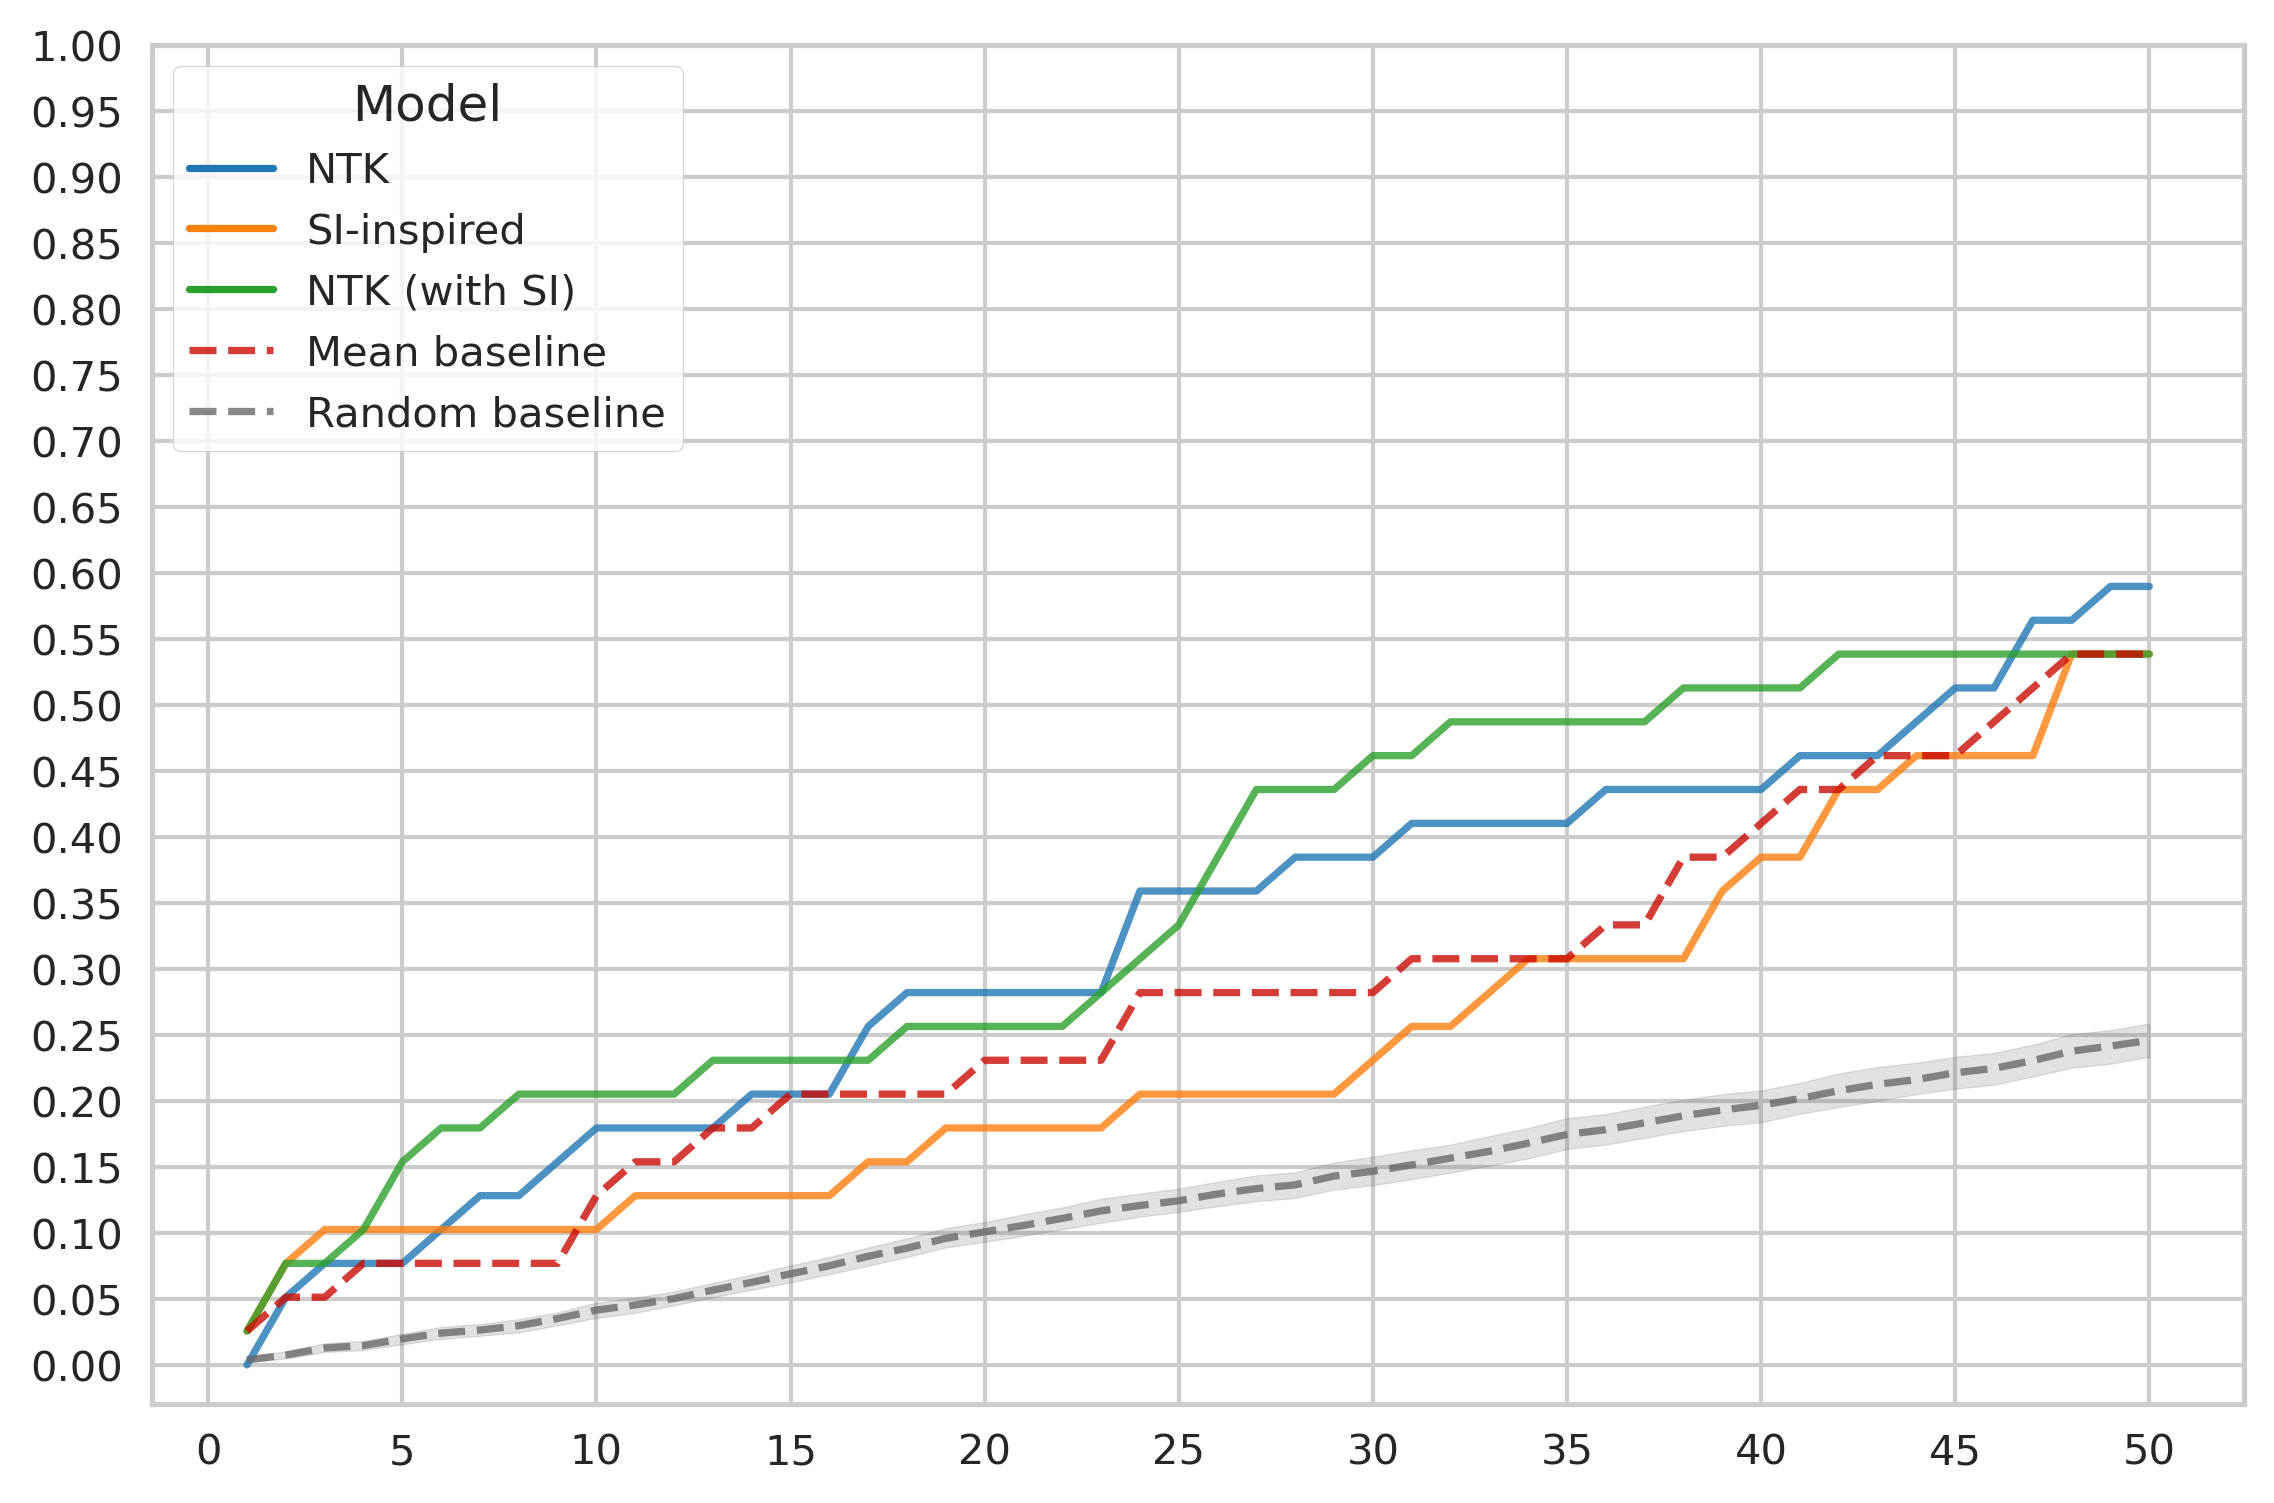

<IPython.core.display.Javascript object>

In [52]:
fig, ax = plot_translation_performance(
    results=no_clustering_results,
    hue="model",
    ymax=1.05,
    title="",
    random_baseline=exp_random_knn_results,
    mean_baseline=mean_baseline_results,
    figsize=[9, 6],
    legend_title="Model",
    cmap="tab10",
)
ax.set_xlabel("")
ax.set_ylabel("")

---


#### Image clustering

In [184]:
selected_exp = "gae_exp_a1_b0_g1_split_graph_physical"


exp_gs_ntk_knn_results = all_gs_ntk_knn_results_ext.loc[
    all_gs_ntk_knn_results_ext.exp == selected_exp
]

exp_random_knn_results = all_random_knn_results.loc[
    all_random_knn_results.exp == selected_exp
]

exp_synt_int_knn_results = all_gs_synt_int_knn_results.loc[
    all_gs_synt_int_knn_results.exp == selected_exp
]

<IPython.core.display.Javascript object>

In [185]:
exp_gs_ntk_knn_results = exp_gs_ntk_knn_results.copy()
exp_gs_ntk_knn_results = exp_gs_ntk_knn_results.loc[
    (exp_gs_ntk_knn_results.n_neighbors_pos_encodings == 0)
    | (exp_gs_ntk_knn_results.n_neighbors_pos_encodings == 38)
    | (exp_gs_ntk_knn_results.append_neighbor_embs.notnull())
]

<IPython.core.display.Javascript object>

In [186]:
output_best_model_config_ids(
    results=exp_gs_ntk_knn_results,
    metric_cols=["20nn_auc", "50nn_auc"],
    n_config_ids=98,
)

,config_id,metric,value
97,1945,20nn_auc,0.174603
102,1945,50nn_auc,0.373555


<IPython.core.display.Javascript object>

In [188]:
top20nn = np.unique(exp_gs_ntk_knn_results.loc[:, "20nn_auc"])[::-1][:35]
top50nn = np.unique(exp_gs_ntk_knn_results.loc[:, "50nn_auc"])[::-1][:30]
print("Top 20NN AUC", np.round(top20nn, 6))
print("Top 50NN AUC", np.round(top50nn, 6))

Top 20NN AUC [0.197802 0.194139 0.192918 0.191697 0.190476 0.188034 0.186813 0.186813
 0.185592 0.184371 0.184371 0.18315  0.18315  0.181929 0.181929 0.181929
 0.180708 0.180708 0.180708 0.179487 0.179487 0.179487 0.178266 0.178266
 0.178266 0.177045 0.177045 0.177045 0.175824 0.175824 0.175824 0.174603
 0.174603 0.174603 0.173382]
Top 50NN AUC [0.38009  0.377074 0.373555 0.373052 0.373052 0.371543 0.370538 0.370035
 0.368024 0.367521 0.367019 0.366516 0.363499 0.361488 0.360985 0.360985
 0.360483 0.35998  0.35998  0.359477 0.358974 0.358472 0.357466 0.356963
 0.356461 0.355958 0.354952 0.354449 0.353947 0.353444]


<IPython.core.display.Javascript object>

We find that the model with the configuration ID of 1945 of reaches the 34th highest AUC for 20NN accuracy and the 3rd highest 50NN accuracy. We thus select that model to be representative of the optimal performance for the NTK solution when not cluster information is used.

In [57]:
ntk_image_clustering_result_101 = exp_gs_ntk_knn_results.loc[
    exp_gs_ntk_knn_results.config_id == 1945
]
ntk_image_clustering_result_101.loc[:, "model"] = "NTK (with SI)"

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<IPython.core.display.Javascript object>

In [58]:
ntk_image_clustering_result_101.iloc[:1, 9:]

,alpha,beta,gamma,graph,cluster,model,reg,use_mean_train_reg_embs,n_neighbors_pos_encodings,n_pos_encodings,pos_encoding_type,append_neighbor_embs,rff_sigma,config_id,exp
0,1,0,1,split,physical,NTK (with SI),50,True,38,2,positional,None,5,1945,gae_exp_a1_b0_g1_split_graph_physical


<IPython.core.display.Javascript object>

As seen above the model uses encodings of the relaxed SI coefficients. We thus also identify the best model not making use of such information.

In [59]:
output_best_model_config_ids(
    results=exp_gs_ntk_knn_results.loc[
        (exp_gs_ntk_knn_results.n_neighbors_pos_encodings == 0)
    ],
    metric_cols=["20nn_auc", "50nn_auc"],
    n_config_ids=1,
)

,config_id,metric,value
0,1367,20nn_auc,0.161172
1,1367,50nn_auc,0.325289


<IPython.core.display.Javascript object>

The best model not using the neihgbor encodings is found at configureation 1367.

In [60]:
ntk_image_clustering_wo_neigh_result = exp_gs_ntk_knn_results.loc[
    exp_gs_ntk_knn_results.config_id == 1367
]
ntk_image_clustering_wo_neigh_result.loc[:, "model"] = "NTK"

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<IPython.core.display.Javascript object>

In [61]:
ntk_image_clustering_wo_neigh_result.iloc[:1, 9:]

,alpha,beta,gamma,graph,cluster,model,reg,use_mean_train_reg_embs,n_neighbors_pos_encodings,n_pos_encodings,pos_encoding_type,append_neighbor_embs,rff_sigma,config_id,exp
0,1,0,1,split,physical,NTK,100,True,0,20,gauss,genes,10,1367,gae_exp_a1_b0_g1_split_graph_physical


<IPython.core.display.Javascript object>

We will now plot the performance of this model against a mean and a random baseline as well as the model using a synthetic intervetnion approach.

In [62]:
exp_synt_int_knn_results.loc[:, "model"] = "SI-inspired"
image_clustering_results_101 = ntk_image_clustering_wo_neigh_result.append(
    exp_synt_int_knn_results
).append(ntk_image_clustering_result_101)

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<IPython.core.display.Javascript object>

Text(0, 0.5, '')

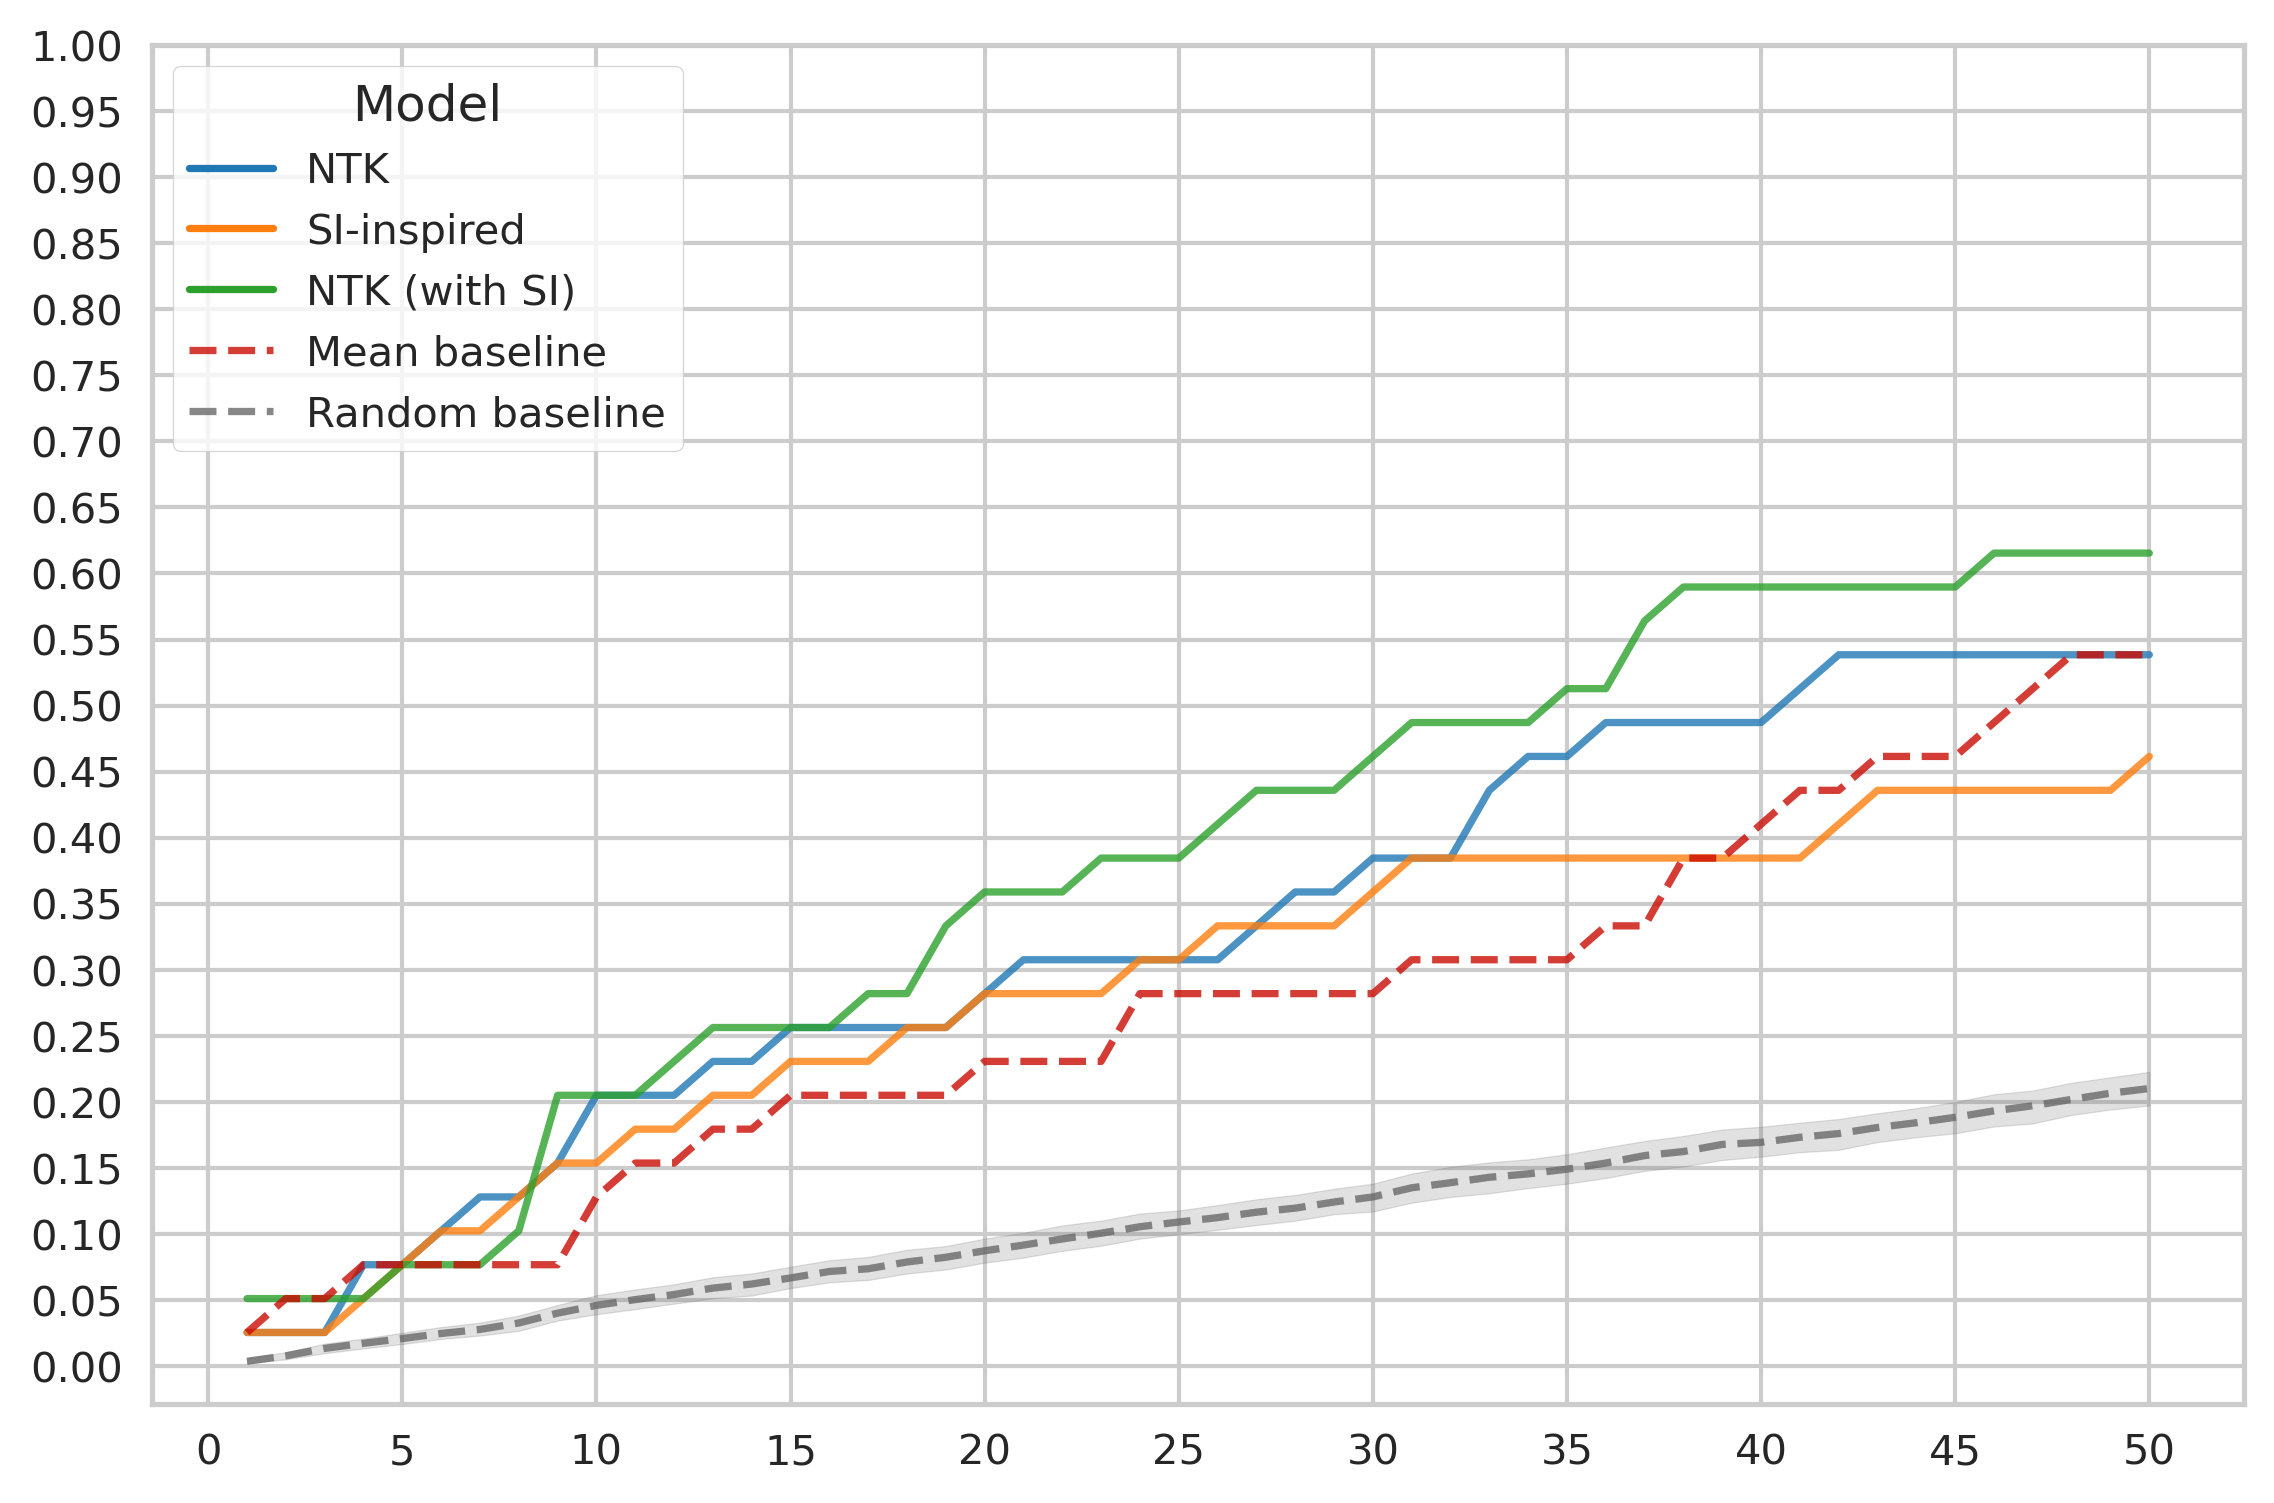

<IPython.core.display.Javascript object>

In [63]:
fig, ax = plot_translation_performance(
    results=image_clustering_results_101,
    hue="model",
    ymax=1.05,
    title="",
    random_baseline=exp_random_knn_results,
    mean_baseline=mean_baseline_results,
    figsize=[9, 6],
    legend_title="Model",
    cmap="tab10",
)
ax.set_xlabel("")
ax.set_ylabel("")

---
#### CMap clustering (all 47 genes with corresponding signatures)

In [181]:
selected_exp = "gae_exp_a1_b0_g1_split_graph_cmap_full_all_nodes"


exp_gs_ntk_knn_results = all_gs_ntk_knn_results_ext.loc[
    all_gs_ntk_knn_results_ext.exp == selected_exp
]

exp_random_knn_results = all_random_knn_results.loc[
    all_random_knn_results.exp == selected_exp
]

exp_synt_int_knn_results = all_gs_synt_int_knn_results.loc[
    all_gs_synt_int_knn_results.exp == selected_exp
]

<IPython.core.display.Javascript object>

In [182]:
exp_gs_ntk_knn_results = exp_gs_ntk_knn_results.copy()
exp_gs_ntk_knn_results = exp_gs_ntk_knn_results.loc[
    (exp_gs_ntk_knn_results.n_neighbors_pos_encodings == 0)
    | (exp_gs_ntk_knn_results.n_neighbors_pos_encodings == 38)
    | (exp_gs_ntk_knn_results.append_neighbor_embs.notnull())
]

<IPython.core.display.Javascript object>

In [183]:
output_best_model_config_ids(
    results=exp_gs_ntk_knn_results,
    metric_cols=["20nn_auc", "50nn_auc"],
    n_config_ids=145,
)

,config_id,metric,value
144,26,20nn_auc,0.300366
211,26,50nn_auc,0.486677


<IPython.core.display.Javascript object>

In [67]:
top20nn = np.unique(exp_gs_ntk_knn_results.loc[:, "20nn_auc"])[::-1][:10]
top50nn = np.unique(exp_gs_ntk_knn_results.loc[:, "50nn_auc"])[::-1][:20]
print("Top 20NN AUC", np.round(top20nn, 6))
print("Top 50NN AUC", np.round(top50nn, 6))

Top 20NN AUC [0.301587 0.300366 0.299145 0.297924 0.294261 0.290598 0.286935 0.284493
 0.282051 0.279609]
Top 50NN AUC [0.486677 0.486174 0.479135 0.476621 0.476119 0.475113 0.469583 0.467069
 0.466566 0.465058 0.457516 0.456008 0.453997 0.45098  0.448969 0.448467
 0.447461 0.444947 0.442936 0.441931]


<IPython.core.display.Javascript object>

We find that the model with the configuration ID of 0 of reaches the 2nd highest AUC for 20NN accuracy and the highest 50NN accuracy. We thus select that model to be representative of the optimal performance for the NTK solution when not cluster information is used.

In [68]:
ntk_cmap_clustering_result_101 = exp_gs_ntk_knn_results.loc[
    exp_gs_ntk_knn_results.config_id == 26
]
ntk_cmap_clustering_result_101.loc[:, "model"] = "NTK (with SI)"

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<IPython.core.display.Javascript object>

In [69]:
ntk_cmap_clustering_result_101.iloc[:1, 9:]

,alpha,beta,gamma,graph,cluster,model,reg,use_mean_train_reg_embs,n_neighbors_pos_encodings,n_pos_encodings,pos_encoding_type,append_neighbor_embs,rff_sigma,config_id,exp
0,1,0,1,split,cmap_full_all_nodes,NTK (with SI),1,False,0,5,positional,images,10,26,gae_exp_a1_b0_g1_split_graph_cmap_full_all_nodes


<IPython.core.display.Javascript object>

As seen above the model uses encodings of the relaxed SI coefficients. We thus also identify the best model not making use of such information.

In [70]:
output_best_model_config_ids(
    results=exp_gs_ntk_knn_results.loc[
        (exp_gs_ntk_knn_results.n_neighbors_pos_encodings == 0)
    ],
    metric_cols=["20nn_auc", "50nn_auc"],
    n_config_ids=145,
)

,config_id,metric,value
11,332,20nn_auc,0.301587
144,1,20nn_auc,0.300366
181,1,50nn_auc,0.486677
289,332,50nn_auc,0.467069


<IPython.core.display.Javascript object>

The best model not using the neihgbor encodings is found at configureation 1.

In [71]:
ntk_cmap_clustering_wo_neigh_result = exp_gs_ntk_knn_results.loc[
    exp_gs_ntk_knn_results.config_id == 1
]
ntk_cmap_clustering_wo_neigh_result.loc[:, "model"] = "NTK"

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<IPython.core.display.Javascript object>

In [72]:
ntk_cmap_clustering_wo_neigh_result.iloc[:1, 9:]

,alpha,beta,gamma,graph,cluster,model,reg,use_mean_train_reg_embs,n_neighbors_pos_encodings,n_pos_encodings,pos_encoding_type,append_neighbor_embs,rff_sigma,config_id,exp
0,1,0,1,split,cmap_full_all_nodes,NTK,1,False,0,2,positional,None,5,1,gae_exp_a1_b0_g1_split_graph_cmap_full_all_nodes


<IPython.core.display.Javascript object>

We will now plot the performance of this model against a mean and a random baseline as well as the model using a synthetic intervetnion approach.

In [73]:
exp_synt_int_knn_results.loc[:, "model"] = "SI-inspired"
cmap_clustering_results_101 = ntk_cmap_clustering_wo_neigh_result.append(
    exp_synt_int_knn_results
).append(ntk_cmap_clustering_result_101)

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<IPython.core.display.Javascript object>

Text(0, 0.5, '')

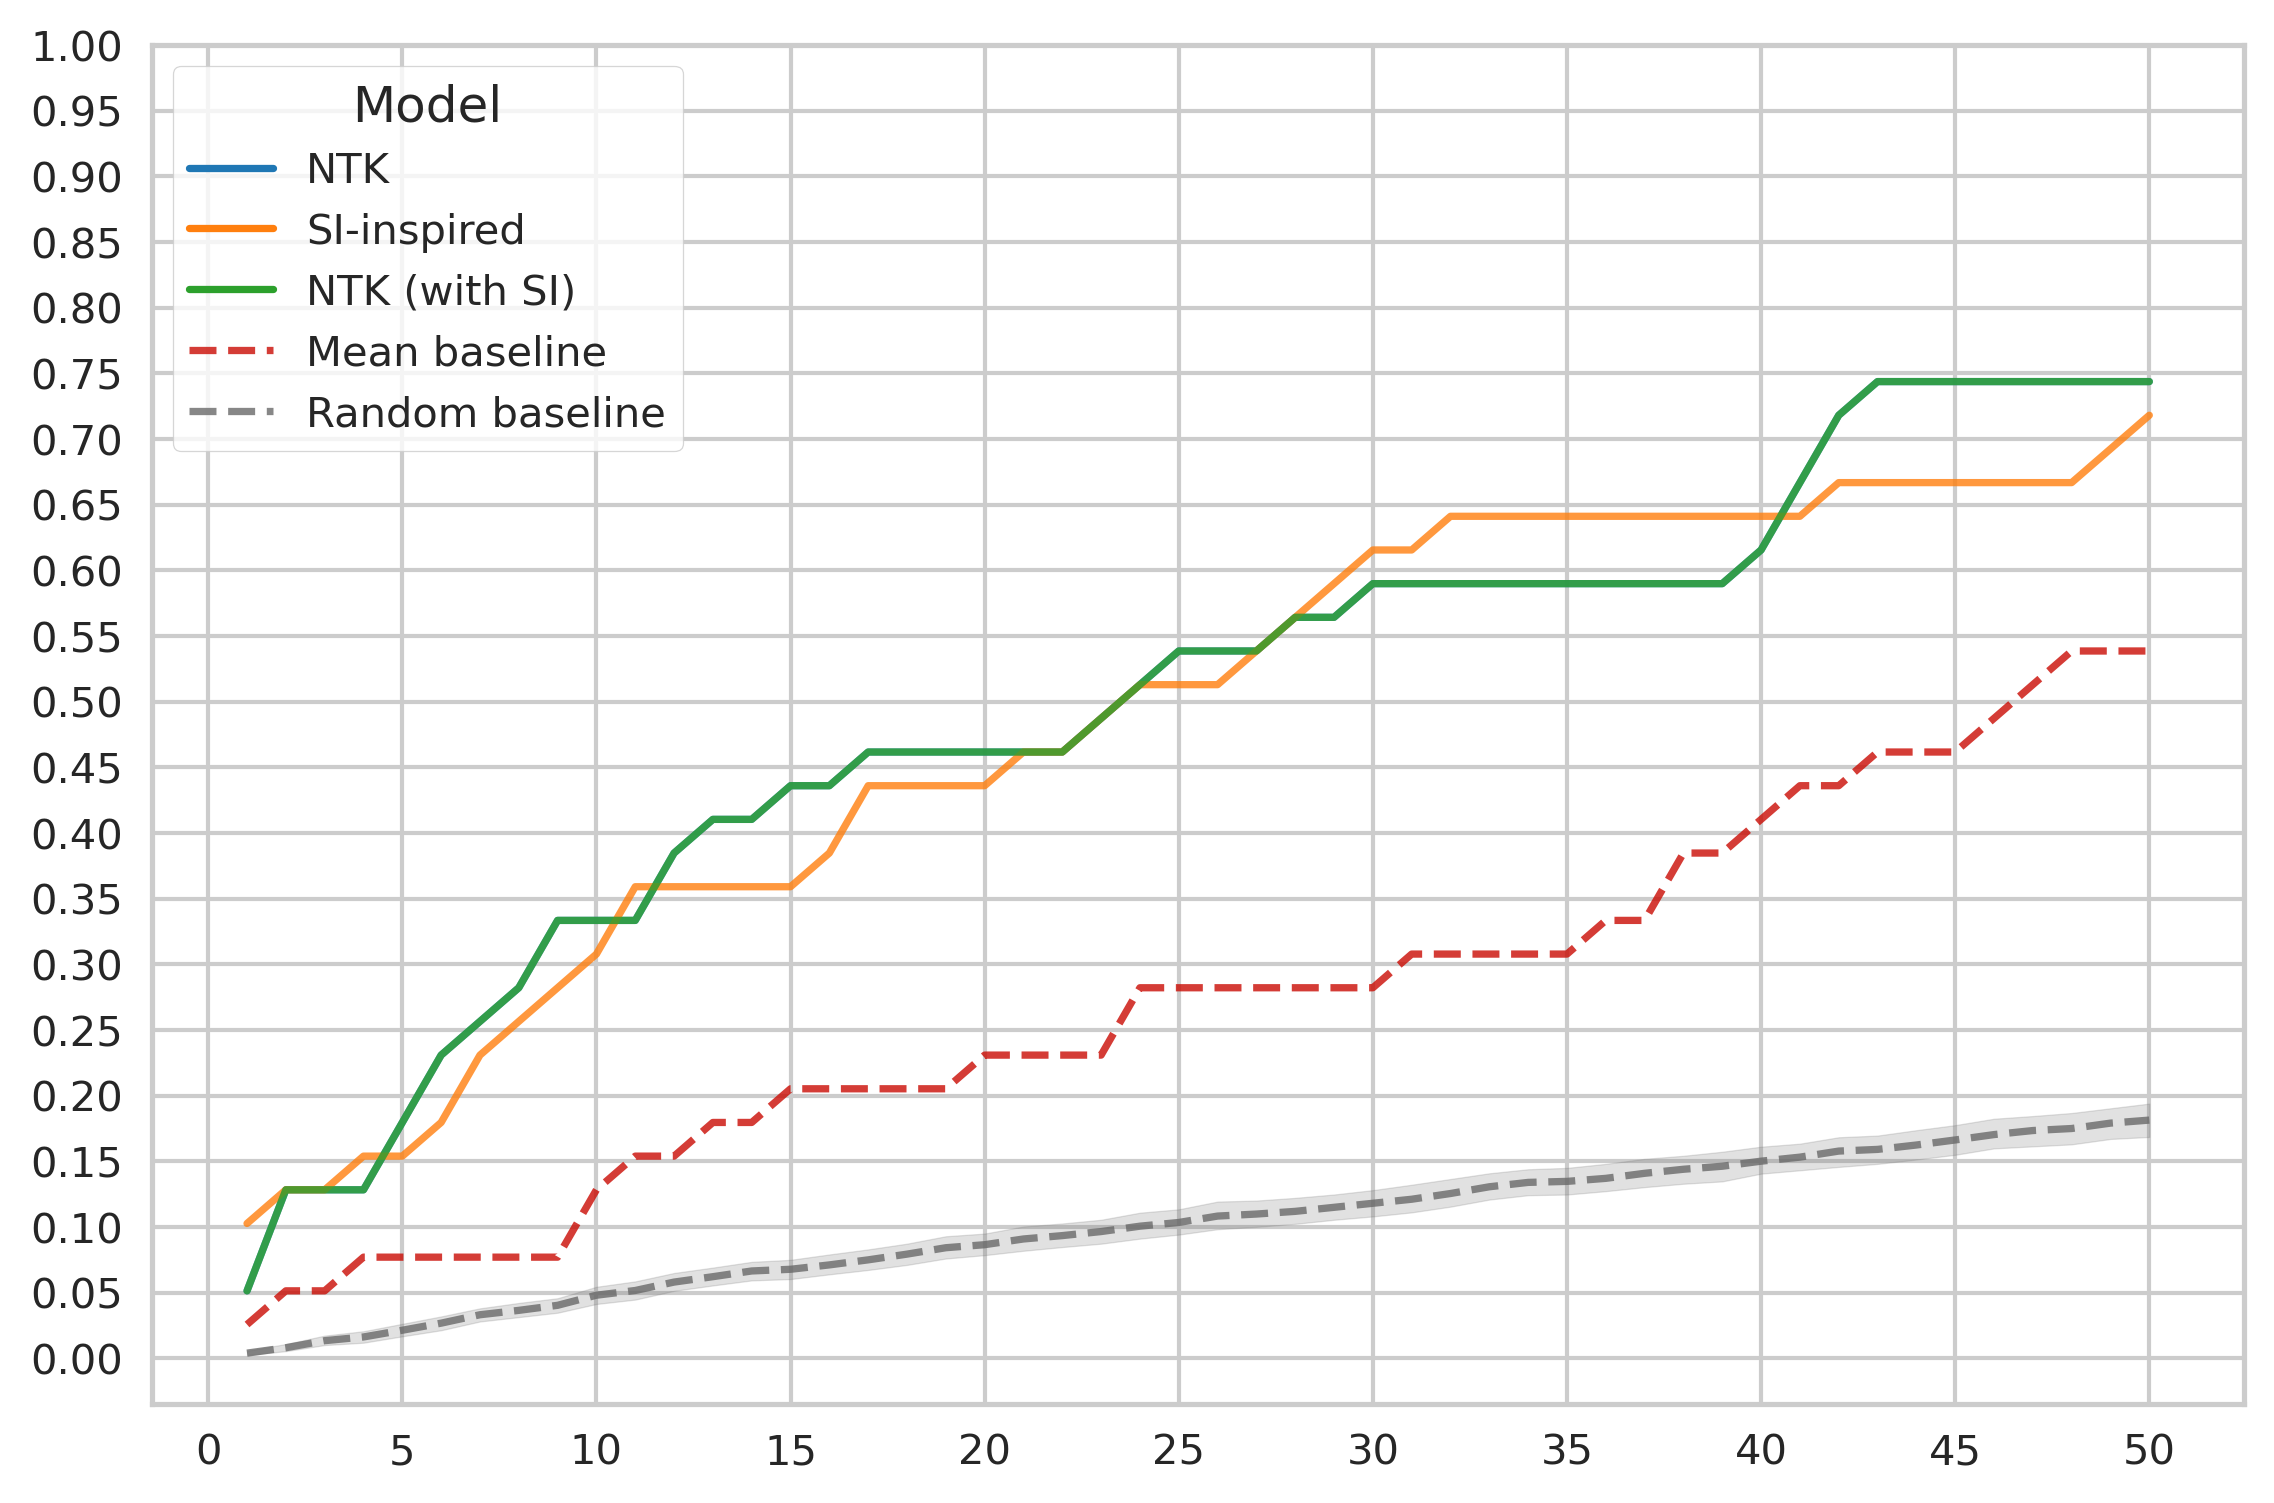

<IPython.core.display.Javascript object>

In [74]:
fig, ax = plot_translation_performance(
    results=cmap_clustering_results_101,
    hue="model",
    ymax=1.05,
    title="",
    random_baseline=exp_random_knn_results,
    mean_baseline=mean_baseline_results,
    figsize=[9, 6],
    legend_title="Model",
    cmap="tab10",
)
ax.set_xlabel("")
ax.set_ylabel("")

---

#### Image clustering (including the test gene sample)

In [177]:
selected_exp = "gae_exp_a1_b0_g1_split_graph_physical_full"


exp_gs_ntk_knn_results = all_gs_ntk_knn_results_ext.loc[
    all_gs_ntk_knn_results_ext.exp == selected_exp
]

exp_random_knn_results = all_random_knn_results.loc[
    all_random_knn_results.exp == selected_exp
]

exp_synt_int_knn_results = all_gs_synt_int_knn_results.loc[
    all_gs_synt_int_knn_results.exp == selected_exp
]

<IPython.core.display.Javascript object>

In [178]:
exp_gs_ntk_knn_results = exp_gs_ntk_knn_results.copy()
exp_gs_ntk_knn_results = exp_gs_ntk_knn_results.loc[
    (exp_gs_ntk_knn_results.n_neighbors_pos_encodings == 0)
    | (exp_gs_ntk_knn_results.n_neighbors_pos_encodings == 38)
    | (exp_gs_ntk_knn_results.append_neighbor_embs.notnull())
]

<IPython.core.display.Javascript object>

In [179]:
output_best_model_config_ids(
    results=exp_gs_ntk_knn_results,
    metric_cols=["20nn_auc", "50nn_auc"],
    n_config_ids=1,
)

,config_id,metric,value
0,1516,20nn_auc,0.459096
1,1516,50nn_auc,0.723982


<IPython.core.display.Javascript object>

In [180]:
top20nn = np.unique(exp_gs_ntk_knn_results.loc[:, "20nn_auc"])[::-1][:10]
top50nn = np.unique(exp_gs_ntk_knn_results.loc[:, "50nn_auc"])[::-1][:20]
print("Top 20NN AUC", np.round(top20nn, 6))
print("Top 50NN AUC", np.round(top50nn, 6))

Top 20NN AUC [0.459096 0.454212 0.452991 0.45177  0.45177  0.449328 0.446886 0.445665
 0.445665 0.444444]
Top 50NN AUC [0.723982 0.71996  0.716943 0.714932 0.711916 0.71091  0.710407 0.708899
 0.707391 0.706888 0.706888 0.706385 0.704877 0.704374 0.703369 0.702866
 0.702363 0.70186  0.701357 0.699849]


<IPython.core.display.Javascript object>

We find that the model with the configuration ID of 1516 of reaches the highest AUC for 20NN accuracy and the highest 50NN accuracy. We thus select that model to be representative of the optimal performance for the NTK solution when not cluster information is used.

In [79]:
ntk_image_all_clustering_result_101 = exp_gs_ntk_knn_results.loc[
    exp_gs_ntk_knn_results.config_id == 1516
]
ntk_image_all_clustering_result_101.loc[:, "model"] = "NTK (with SI)"

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<IPython.core.display.Javascript object>

In [80]:
ntk_image_all_clustering_result_101.iloc[:1, 9:]

,alpha,beta,gamma,graph,cluster,model,reg,use_mean_train_reg_embs,n_neighbors_pos_encodings,n_pos_encodings,pos_encoding_type,append_neighbor_embs,rff_sigma,config_id,exp
0,1,0,1,split,physical_full,NTK (with SI),1,True,38,2,gauss,None,5,1516,gae_exp_a1_b0_g1_split_graph_physical_full


<IPython.core.display.Javascript object>

As seen above the model uses encodings of the relaxed SI coefficients. We thus also identify the best model not making use of such information.

In [81]:
output_best_model_config_ids(
    results=exp_gs_ntk_knn_results.loc[
        (exp_gs_ntk_knn_results.n_neighbors_pos_encodings == 0)
    ],
    metric_cols=["20nn_auc", "50nn_auc"],
    n_config_ids=1,
)

,config_id,metric,value
0,324,20nn_auc,0.435897
1,324,50nn_auc,0.704374


<IPython.core.display.Javascript object>

The best model not using the neihgbor encodings is found at configureation 324.

In [82]:
ntk_image_all_clustering_wo_neigh_result = exp_gs_ntk_knn_results.loc[
    exp_gs_ntk_knn_results.config_id == 324
]
ntk_image_all_clustering_wo_neigh_result.loc[:, "model"] = "NTK"

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<IPython.core.display.Javascript object>

In [83]:
ntk_image_all_clustering_wo_neigh_result.iloc[:1, 9:]

,alpha,beta,gamma,graph,cluster,model,reg,use_mean_train_reg_embs,n_neighbors_pos_encodings,n_pos_encodings,pos_encoding_type,append_neighbor_embs,rff_sigma,config_id,exp
0,1,0,1,split,physical_full,NTK,5,False,0,10,positional,None,1,324,gae_exp_a1_b0_g1_split_graph_physical_full


<IPython.core.display.Javascript object>

We will now plot the performance of this model against a mean and a random baseline as well as the model using a synthetic intervetnion approach.

In [84]:
exp_synt_int_knn_results.loc[:, "model"] = "SI-inspired"
image_all_clustering_results_101 = ntk_image_all_clustering_wo_neigh_result.append(
    exp_synt_int_knn_results
).append(ntk_image_all_clustering_result_101)

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<IPython.core.display.Javascript object>

Text(0, 0.5, '')

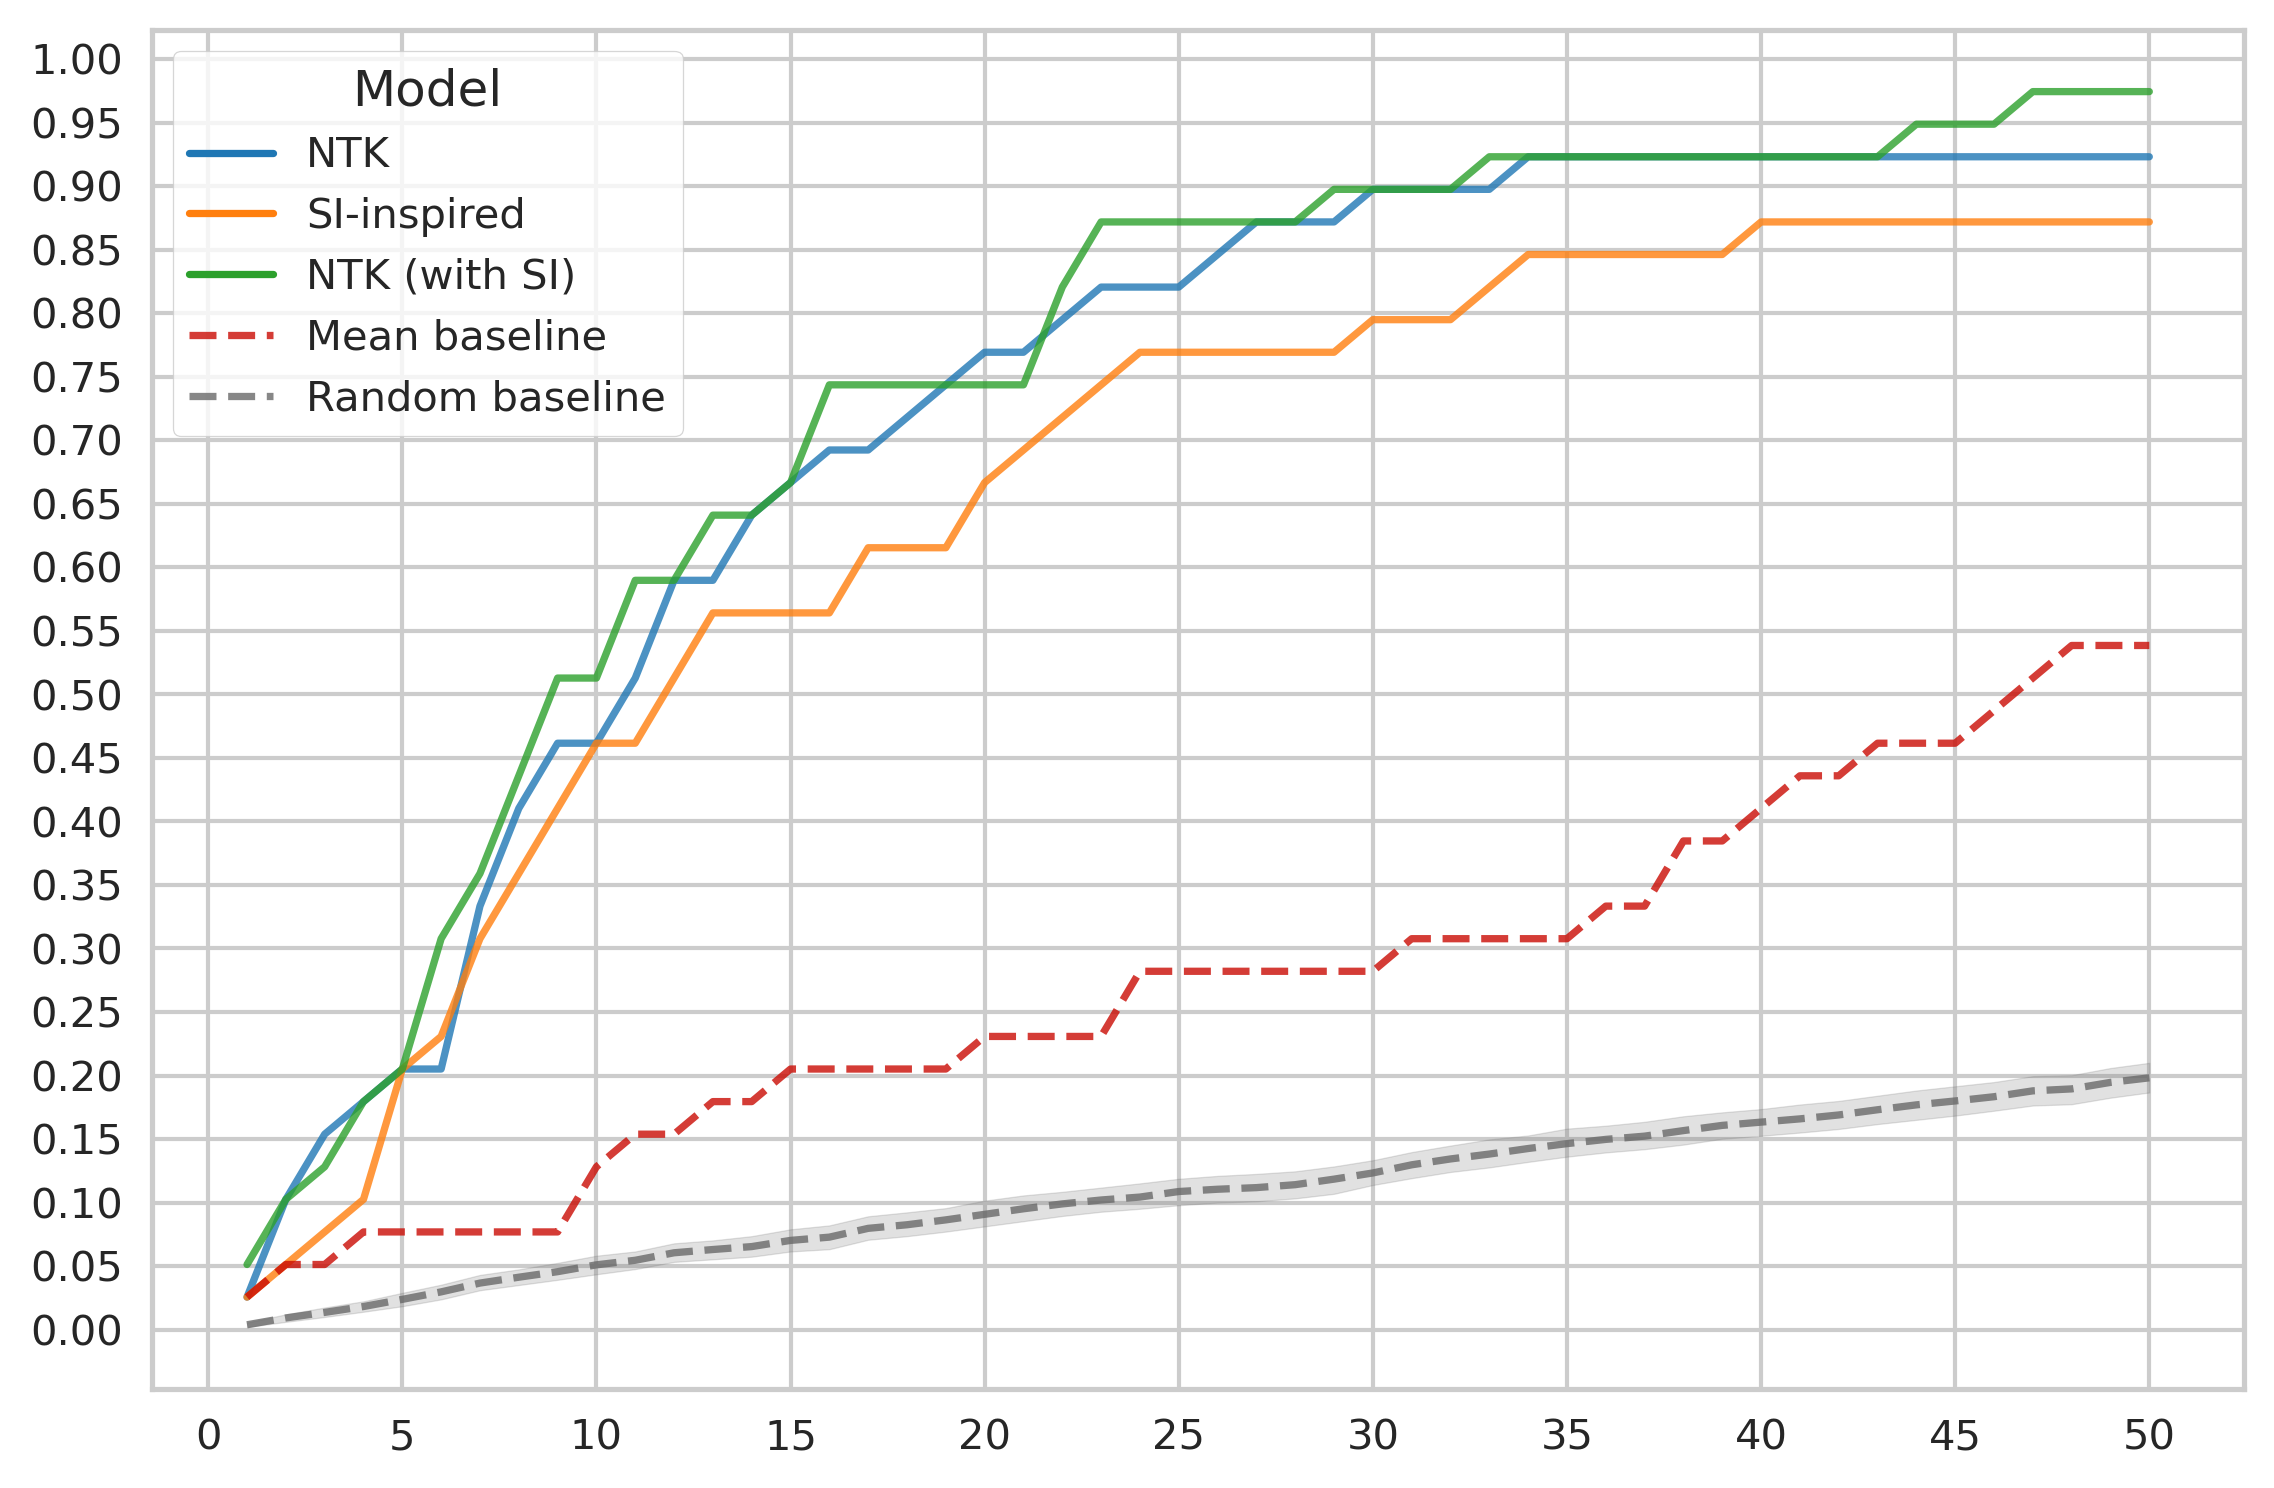

<IPython.core.display.Javascript object>

In [85]:
fig, ax = plot_translation_performance(
    results=image_all_clustering_results_101,
    hue="model",
    ymax=1.05,
    title="",
    random_baseline=exp_random_knn_results,
    mean_baseline=mean_baseline_results,
    figsize=[9, 6],
    legend_title="Model",
    cmap="tab10",
)
ax.set_xlabel("")
ax.set_ylabel("")

----

### Summary plots

In [86]:
no_clustering_random_knn_results = all_random_knn_results.loc[
    all_random_knn_results.exp == "gae_exp_a1_b0_g0_split_graph_physical"
]

summary_ntk_results = [
    ntk_image_clustering_result_101,
    ntk_cmap_clustering_result_101,
    ntk_image_all_clustering_result_101,
]
summary_ntk_results = pd.concat(summary_ntk_results)

<IPython.core.display.Javascript object>

In [87]:
cluster_rename_dict = {
    "physical": "Image2Reg",
    "physical_full": "Image2Reg (incl. test)",
    "cmap_full_all_nodes": "Image2Reg using CMap",
}
summary_ntk_results.cluster = summary_ntk_results.cluster.map(cluster_rename_dict)

<IPython.core.display.Javascript object>

In [88]:
summary_ntk_results.to_csv(
    "../../../data/experiments/summary_ntk_translation_results_updated.csv"
)
no_clustering_random_knn_results.to_csv(
    "../../../data/experiments/no_clustering_random_baseline_translation_updated.csv"
)

<IPython.core.display.Javascript object>

Text(0, 0.5, '')

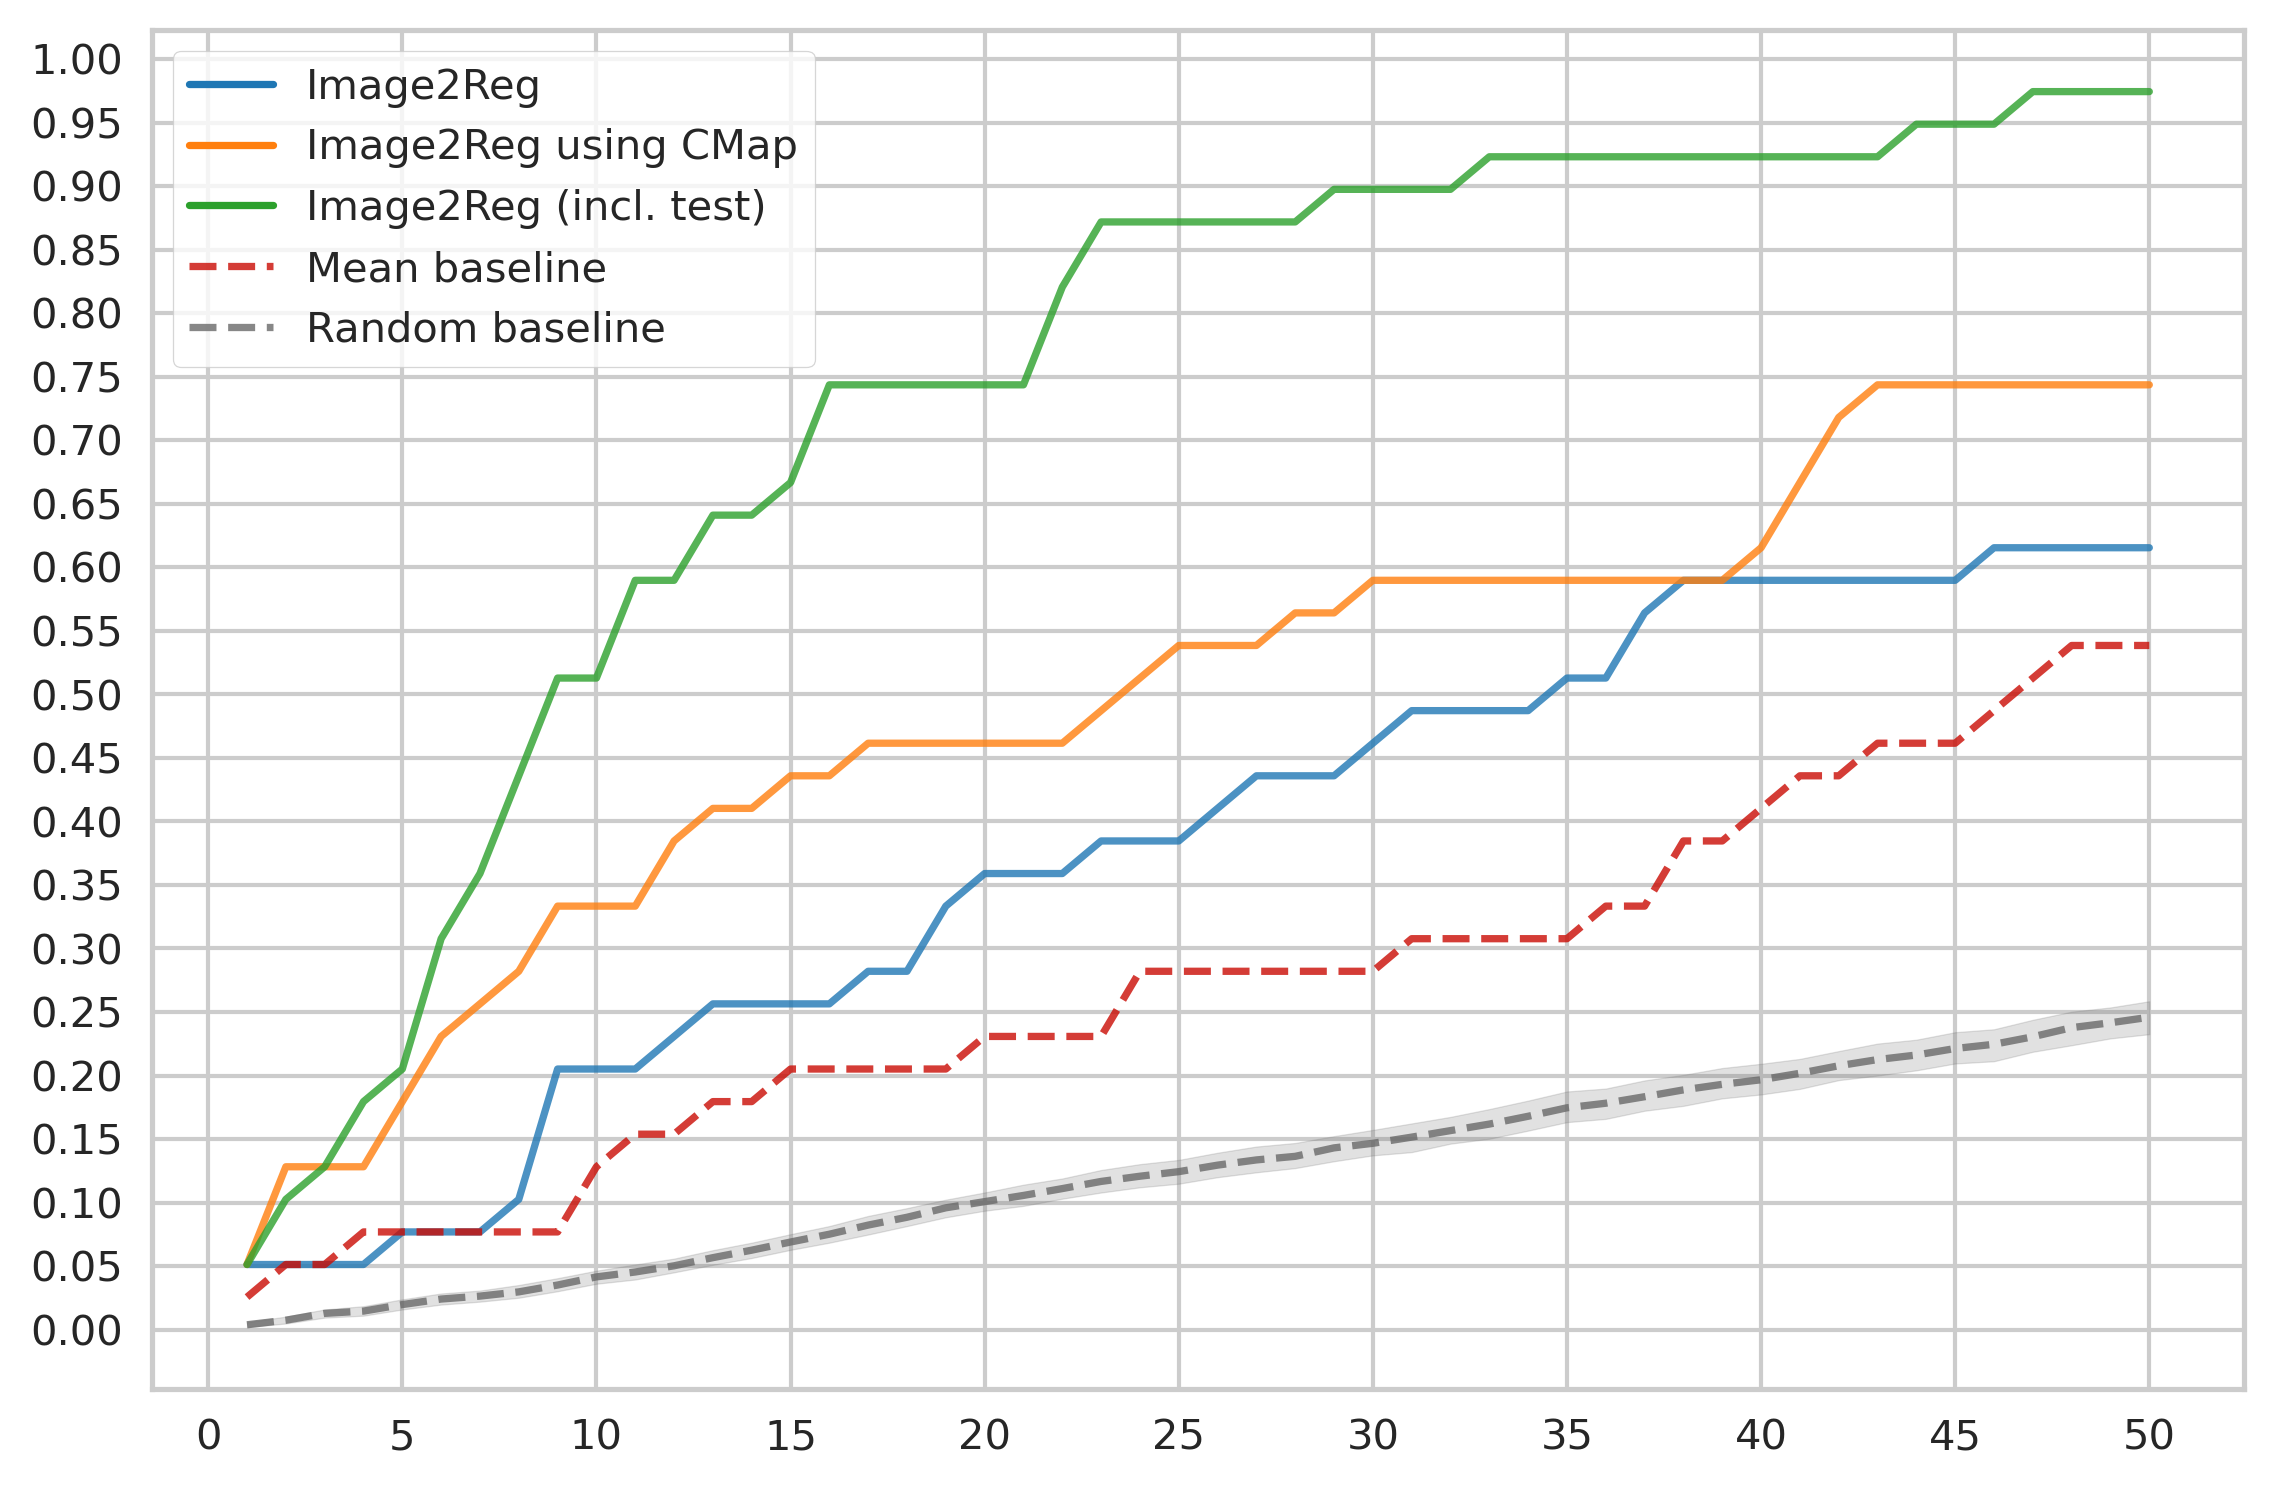

<IPython.core.display.Javascript object>

In [89]:
fig, ax = plot_translation_performance(
    results=summary_ntk_results,
    hue="cluster",
    ymax=1.05,
    title="",
    random_baseline=no_clustering_random_knn_results,
    mean_baseline=mean_baseline_results,
    figsize=[9, 6],
    cmap="tab10",
    legend_title="",
)
ax.set_xlabel("")
ax.set_ylabel("")

In [42]:
fig, ax = plot_translation_performance(
    results=summary_ntk_results.loc[
        summary_ntk_results.cluster.isin(["Image2Reg", "Image2Reg using CMap"])
    ],
    hue="cluster",
    ymax=0.85,
    title="",
    random_baseline=no_clustering_random_knn_results,
    mean_baseline=mean_baseline_results,
    figsize=[10, 6],
    cmap="tab10",
    legend_title="",
)
ax.set_xlabel("")
ax.set_ylabel("")
# ax.legend(
#     labels=["Image2Reg", "Image2Reg using CMap", "Mean baseline", "Random baseline"]
# )

NameError: name 'summary_ntk_results' is not defined

<IPython.core.display.Javascript object>

---

## Supplemental Assessment of Objective Function Weighting

### Prediction performance by target

#### No clustering

In [91]:
selected_reg_pert_embs_dict = exp_embs_dict["gae_exp_a1_b0_g0_split_graph_physical"]

<IPython.core.display.Javascript object>

In [92]:
model_type = "ntk"
reg = ntk_no_clustering_result.loc[0, "reg"]
use_mean_train_reg_embs = ntk_no_clustering_result.loc[0, "use_mean_train_reg_embs"]
n_neighbors_pos_encodings = ntk_no_clustering_result.loc[0, "n_neighbors_pos_encodings"]
n_pos_encodings = ntk_no_clustering_result.loc[0, "n_pos_encodings"]
pos_encoding_type = ntk_no_clustering_result.loc[0, "pos_encoding_type"]
append_neighbor_embs = ntk_no_clustering_result.loc[0, "append_neighbor_embs"]
rff_sigma = ntk_no_clustering_result.loc[0, "rff_sigma"]

<IPython.core.display.Javascript object>

In [93]:
ntk_no_clustering_pred_dict = get_nn_prediction_dict(
    reg_embs_dict=selected_reg_pert_embs_dict["reg_embs"],
    pert_embs_dict=selected_reg_pert_embs_dict["pert_embs"],
    model_type=model_type,
    model_params_dict={"reg": reg},
    use_y_train_mean=use_mean_train_reg_embs,
    n_neighbors_weights_features=n_neighbors_pos_encodings,
    n_weight_encodings=n_pos_encodings,
    neighbor_weight_encoding=pos_encoding_type,
    append_neighbor_embs=append_neighbor_embs,
    rff_sigma=rff_sigma,
)

<IPython.core.display.Javascript object>

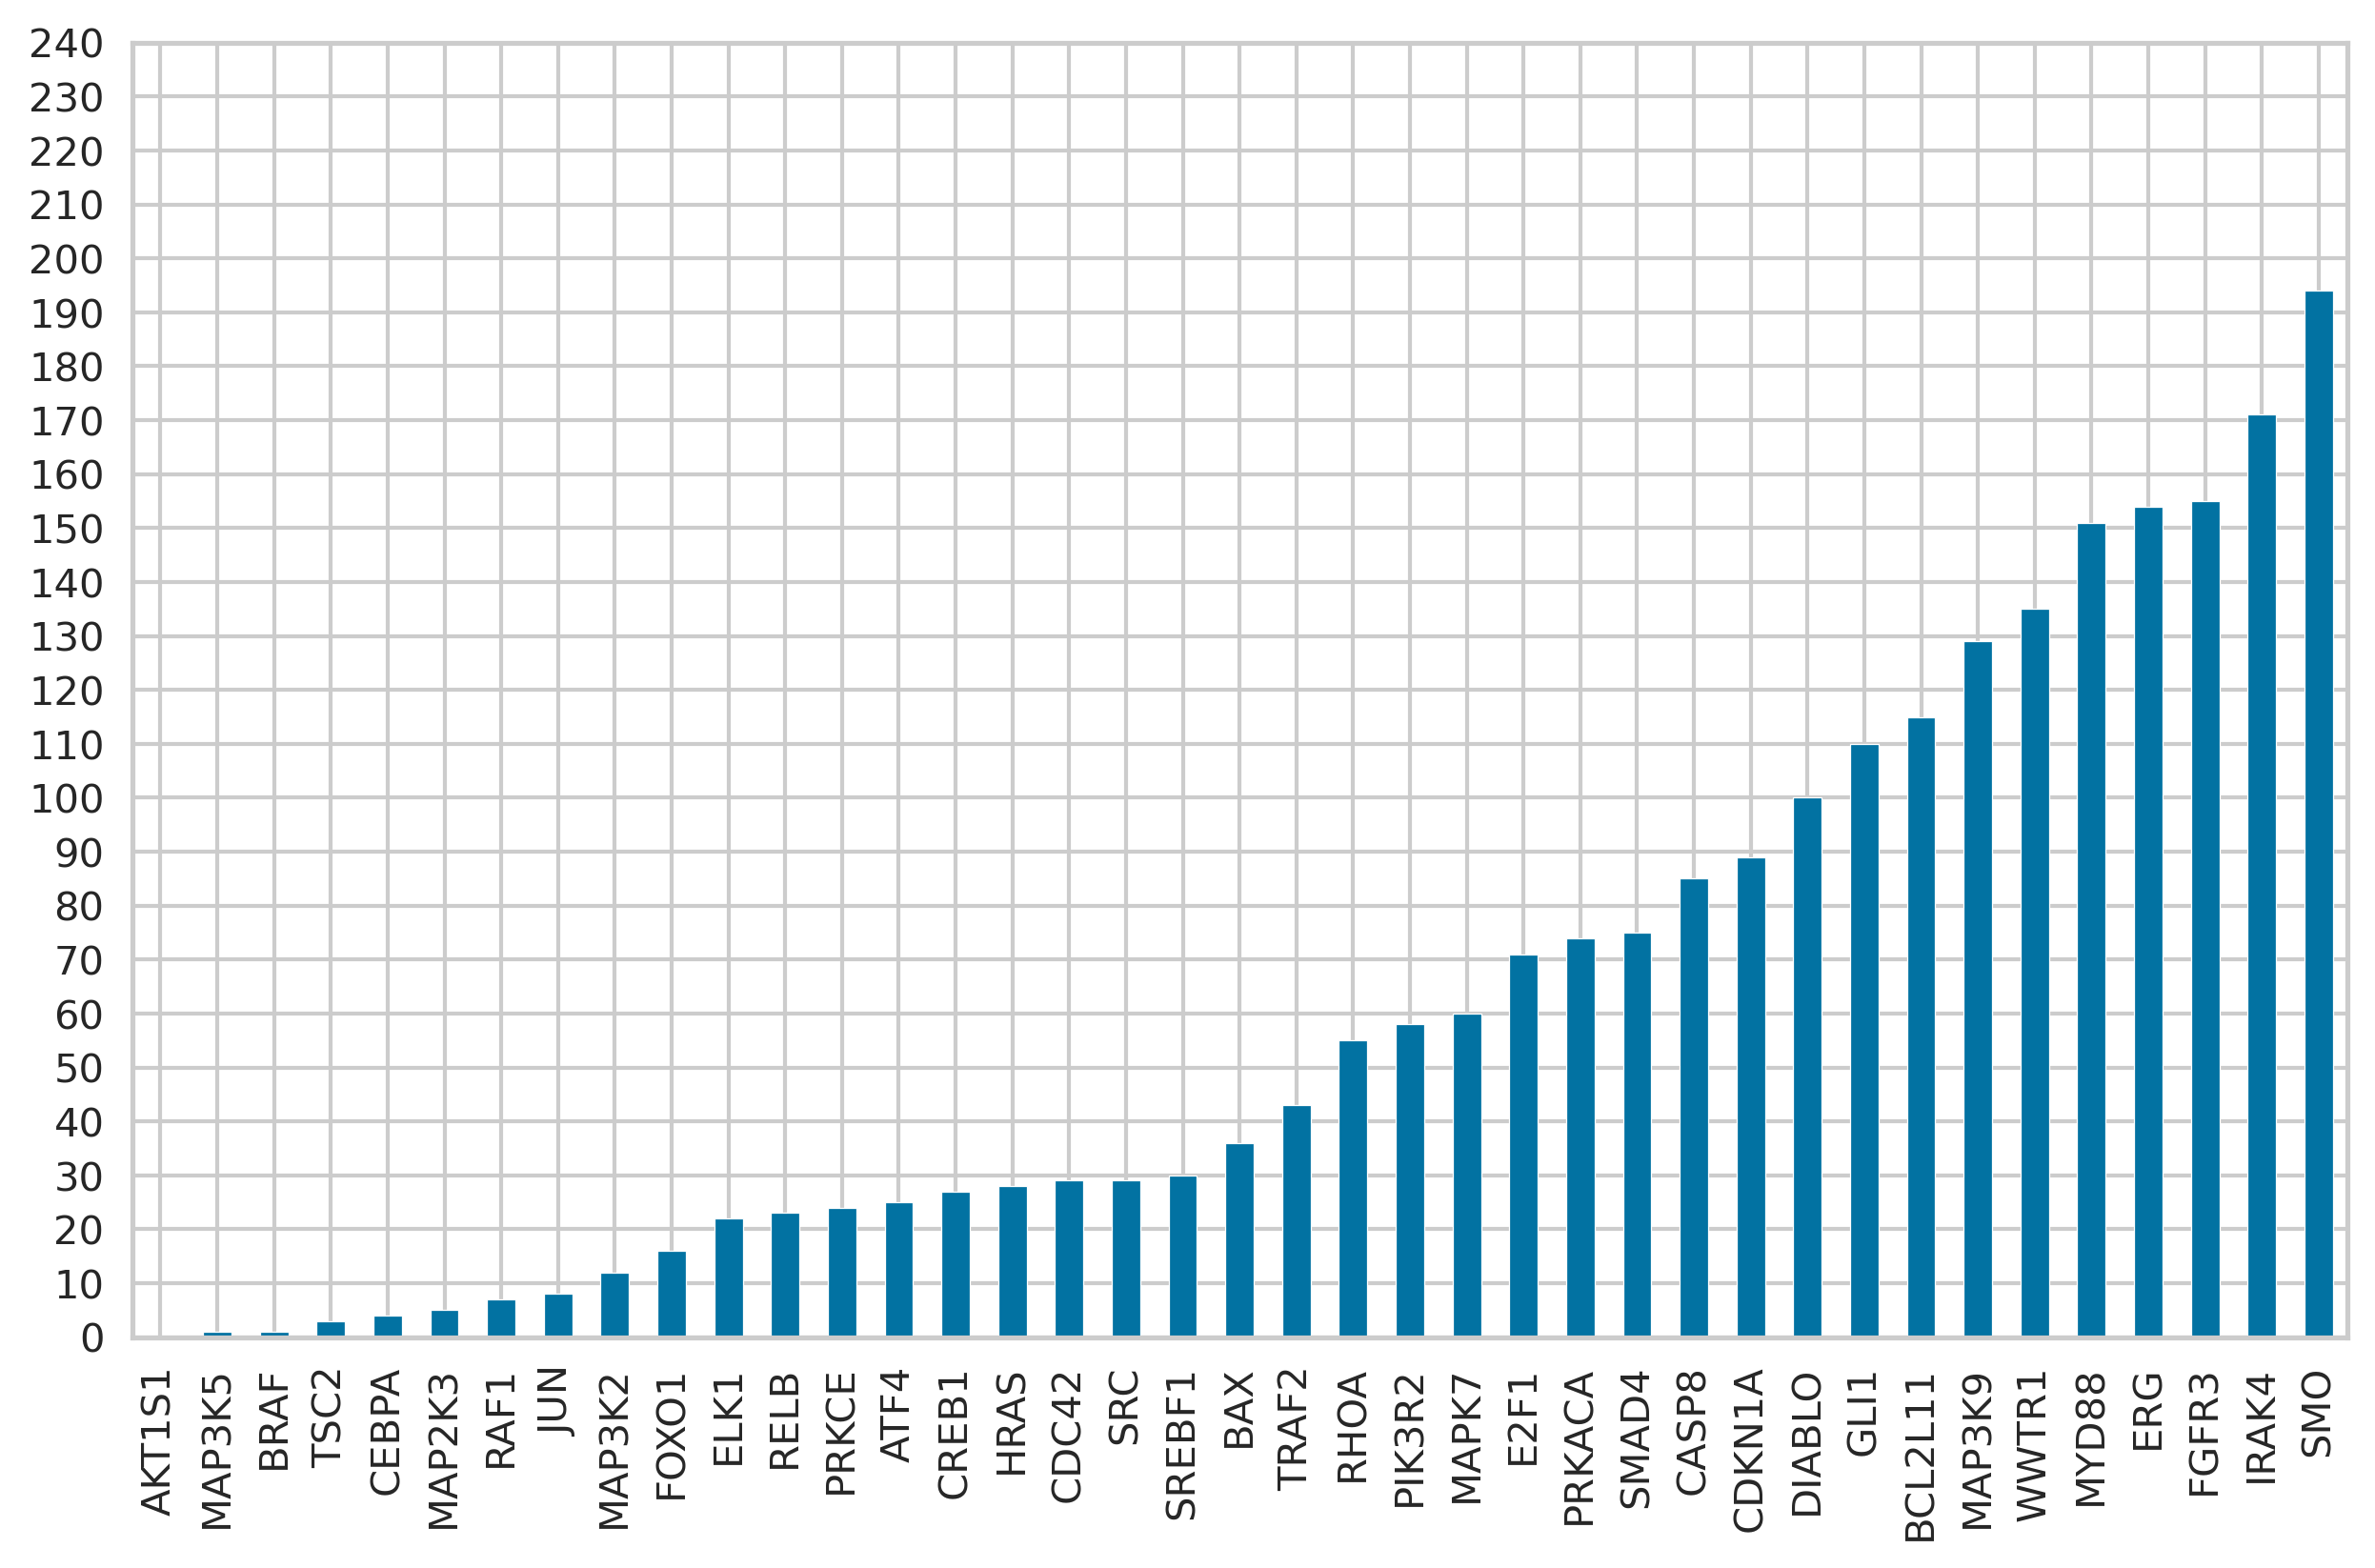

<IPython.core.display.Javascript object>

In [94]:
sns.set_style("whitegrid")
ntk_no_clustering_hit_dict = get_knn_hit_data(ntk_no_clustering_pred_dict)
ax = ntk_no_clustering_hit_dict.knn_hit.sort_values().plot(kind="bar", figsize=[10, 6])
ax.set_yticks(range(0, 250, 10))
plt.show()

---
#### Image clustering

In [95]:
selected_reg_pert_embs_dict = exp_embs_dict["gae_exp_a1_b0_g1_split_graph_physical"]

<IPython.core.display.Javascript object>

In [96]:
model_type = "ntk"
reg = ntk_image_clustering_result_101.loc[0, "reg"]
use_mean_train_reg_embs = ntk_image_clustering_result_101.loc[
    0, "use_mean_train_reg_embs"
]
n_neighbors_pos_encodings = ntk_image_clustering_result_101.loc[
    0, "n_neighbors_pos_encodings"
]
n_pos_encodings = ntk_image_clustering_result_101.loc[0, "n_pos_encodings"]
pos_encoding_type = ntk_image_clustering_result_101.loc[0, "pos_encoding_type"]
append_neighbor_embs = ntk_image_clustering_result_101.loc[0, "append_neighbor_embs"]
rff_sigma = ntk_image_clustering_result_101.loc[0, "rff_sigma"]

<IPython.core.display.Javascript object>

In [97]:
ntk_image_clustering_pred_dict_101 = get_nn_prediction_dict(
    reg_embs_dict=selected_reg_pert_embs_dict["reg_embs"],
    pert_embs_dict=selected_reg_pert_embs_dict["pert_embs"],
    model_type=model_type,
    model_params_dict={"reg": reg},
    use_y_train_mean=use_mean_train_reg_embs,
    n_neighbors_weights_features=n_neighbors_pos_encodings,
    n_weight_encodings=n_pos_encodings,
    neighbor_weight_encoding=pos_encoding_type,
    append_neighbor_embs=append_neighbor_embs,
    rff_sigma=rff_sigma,
)

<IPython.core.display.Javascript object>

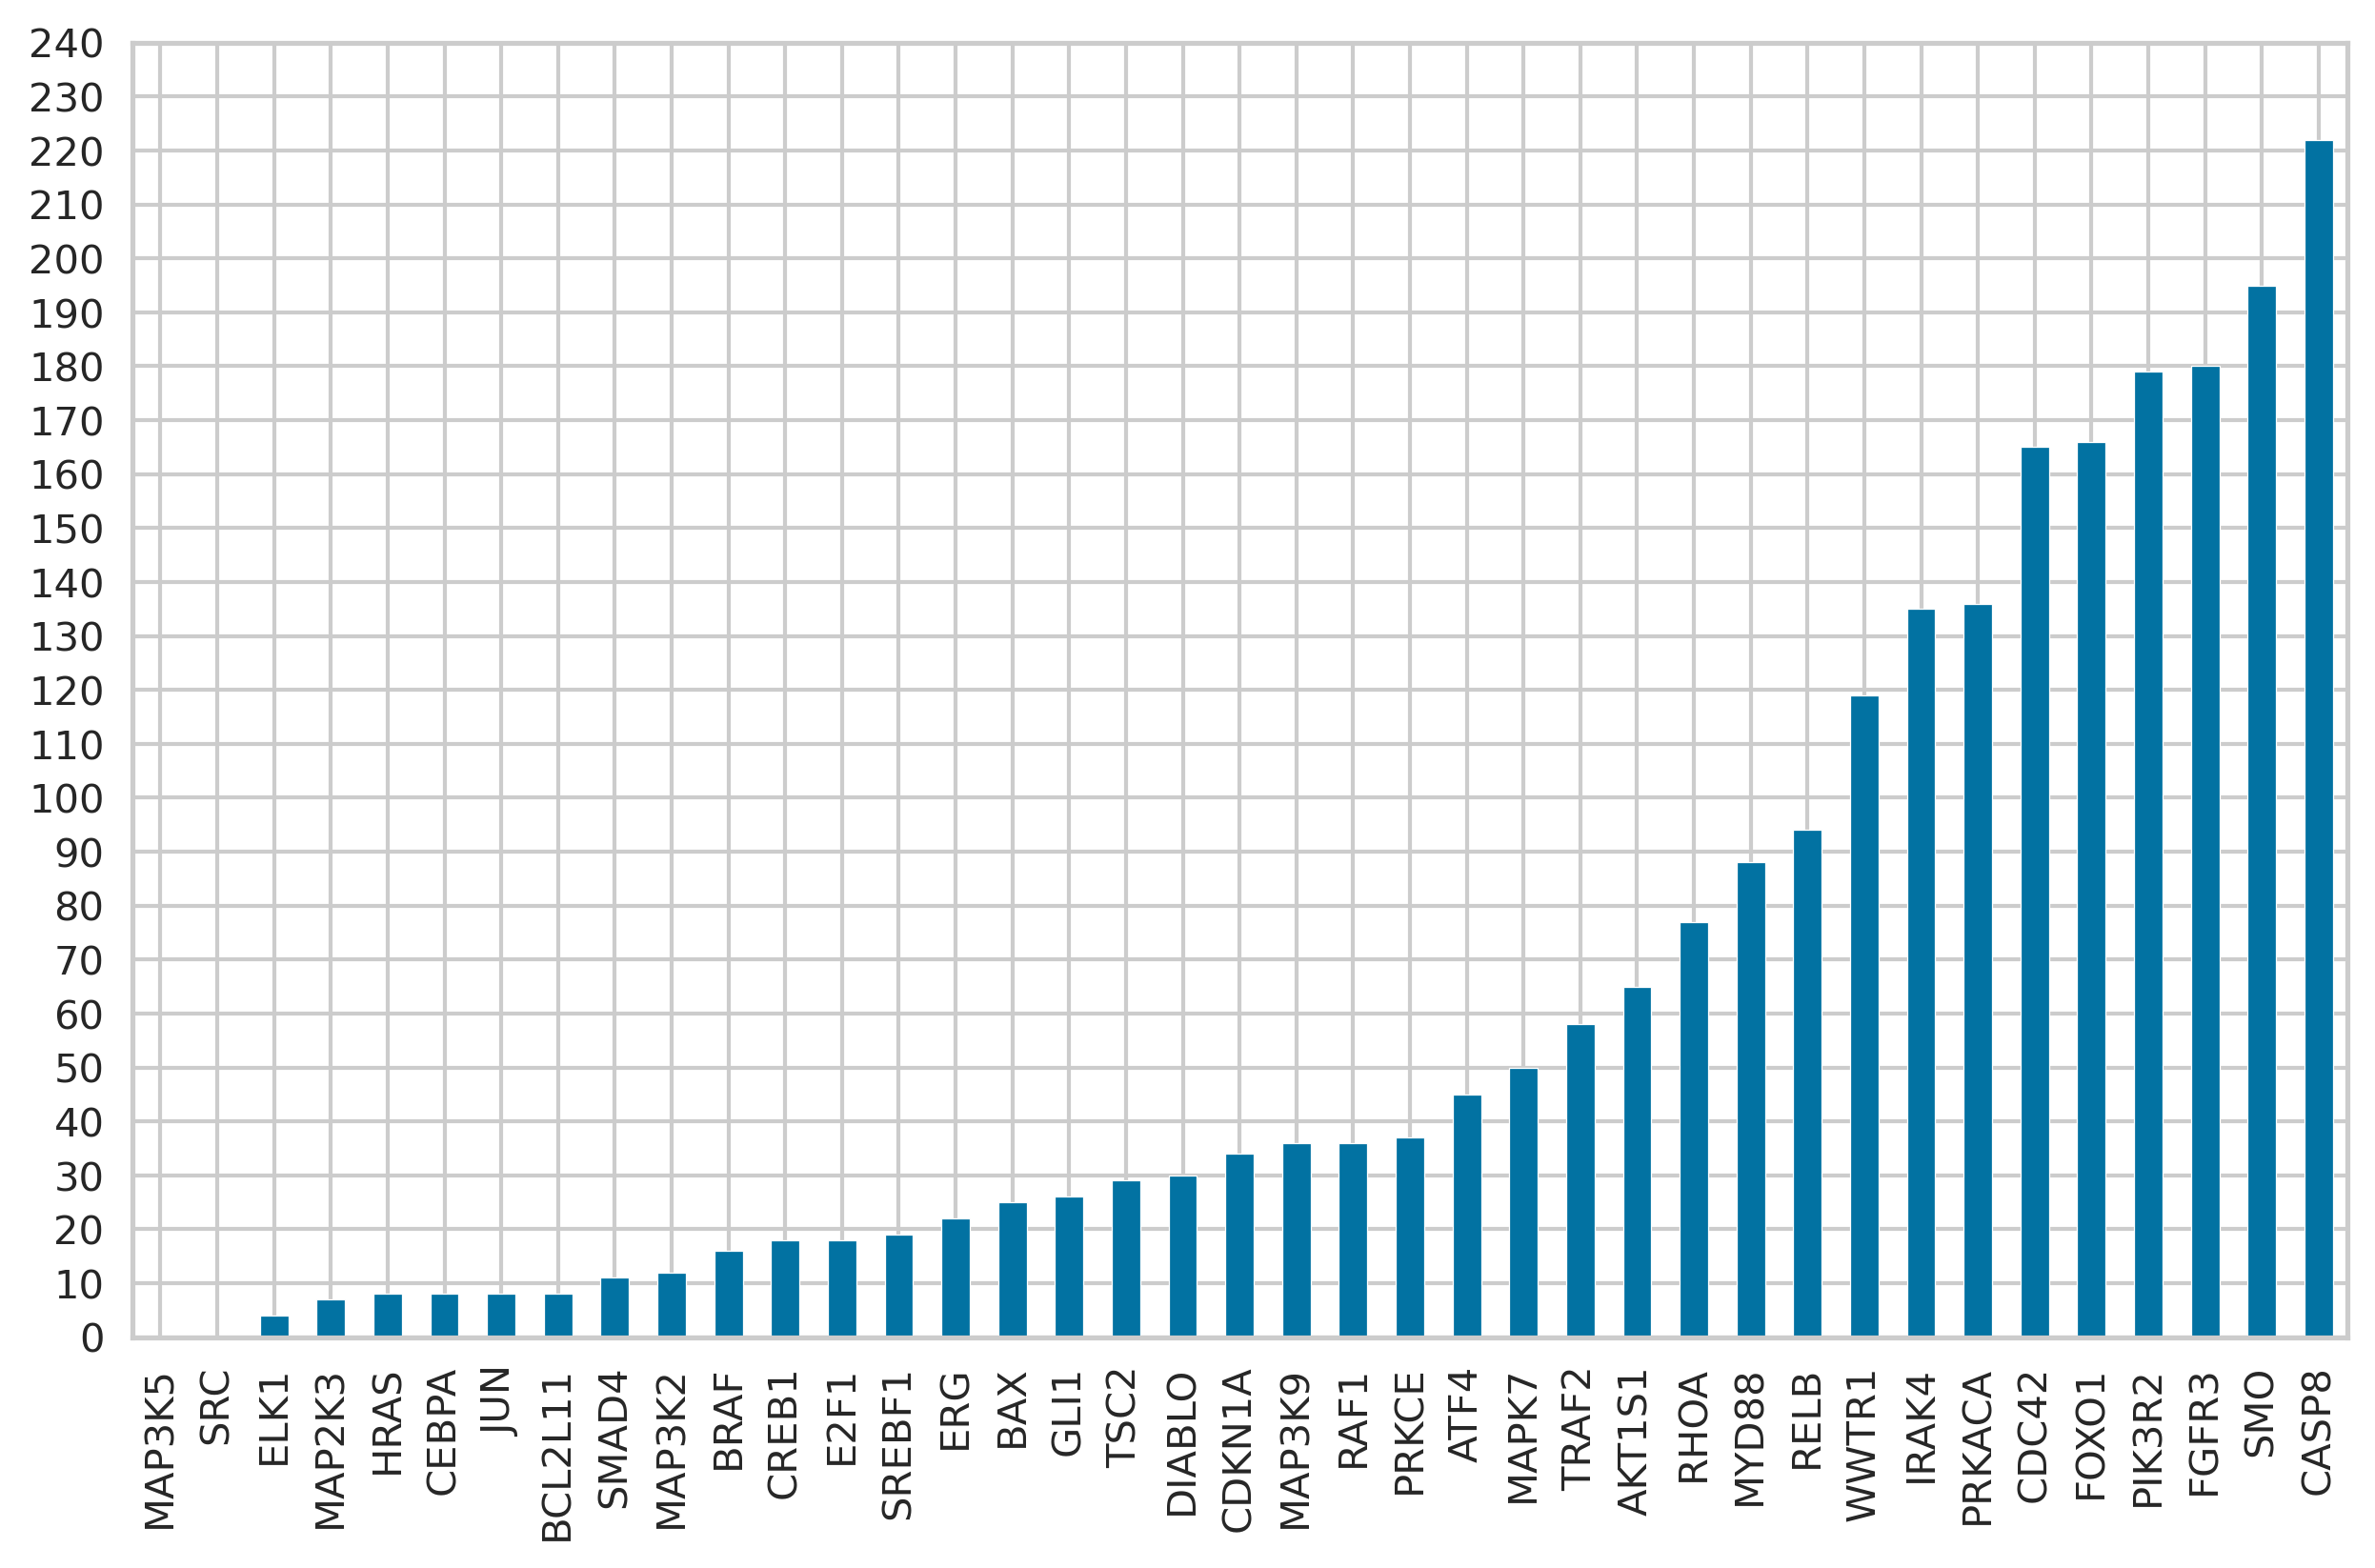

<IPython.core.display.Javascript object>

In [98]:
sns.set_style("whitegrid")
ntk_image_clustering_101_hit_dict = get_knn_hit_data(ntk_image_clustering_pred_dict_101)
ax = ntk_image_clustering_101_hit_dict.knn_hit.sort_values().plot(
    kind="bar", figsize=[10, 6]
)
ax.set_yticks(range(0, 250, 10))
plt.show()

---

#### CMap clustering

In [99]:
selected_reg_pert_embs_dict = exp_embs_dict[
    "gae_exp_a1_b0_g1_split_graph_cmap_full_all_nodes"
]

<IPython.core.display.Javascript object>

In [100]:
model_type = "ntk"
reg = ntk_cmap_clustering_result_101.loc[0, "reg"]
use_mean_train_reg_embs = ntk_cmap_clustering_result_101.loc[
    0, "use_mean_train_reg_embs"
]
n_neighbors_pos_encodings = ntk_cmap_clustering_result_101.loc[
    0, "n_neighbors_pos_encodings"
]
n_pos_encodings = ntk_cmap_clustering_result_101.loc[0, "n_pos_encodings"]
pos_encoding_type = ntk_cmap_clustering_result_101.loc[0, "pos_encoding_type"]
append_neighbor_embs = ntk_cmap_clustering_result_101.loc[0, "append_neighbor_embs"]
rff_sigma = ntk_cmap_clustering_result_101.loc[0, "rff_sigma"]

<IPython.core.display.Javascript object>

In [101]:
ntk_cmap_clustering_pred_dict_101 = get_nn_prediction_dict(
    reg_embs_dict=selected_reg_pert_embs_dict["reg_embs"],
    pert_embs_dict=selected_reg_pert_embs_dict["pert_embs"],
    model_type=model_type,
    model_params_dict={"reg": reg},
    use_y_train_mean=use_mean_train_reg_embs,
    n_neighbors_weights_features=n_neighbors_pos_encodings,
    n_weight_encodings=n_pos_encodings,
    neighbor_weight_encoding=pos_encoding_type,
    append_neighbor_embs=append_neighbor_embs,
    rff_sigma=rff_sigma,
)

<IPython.core.display.Javascript object>

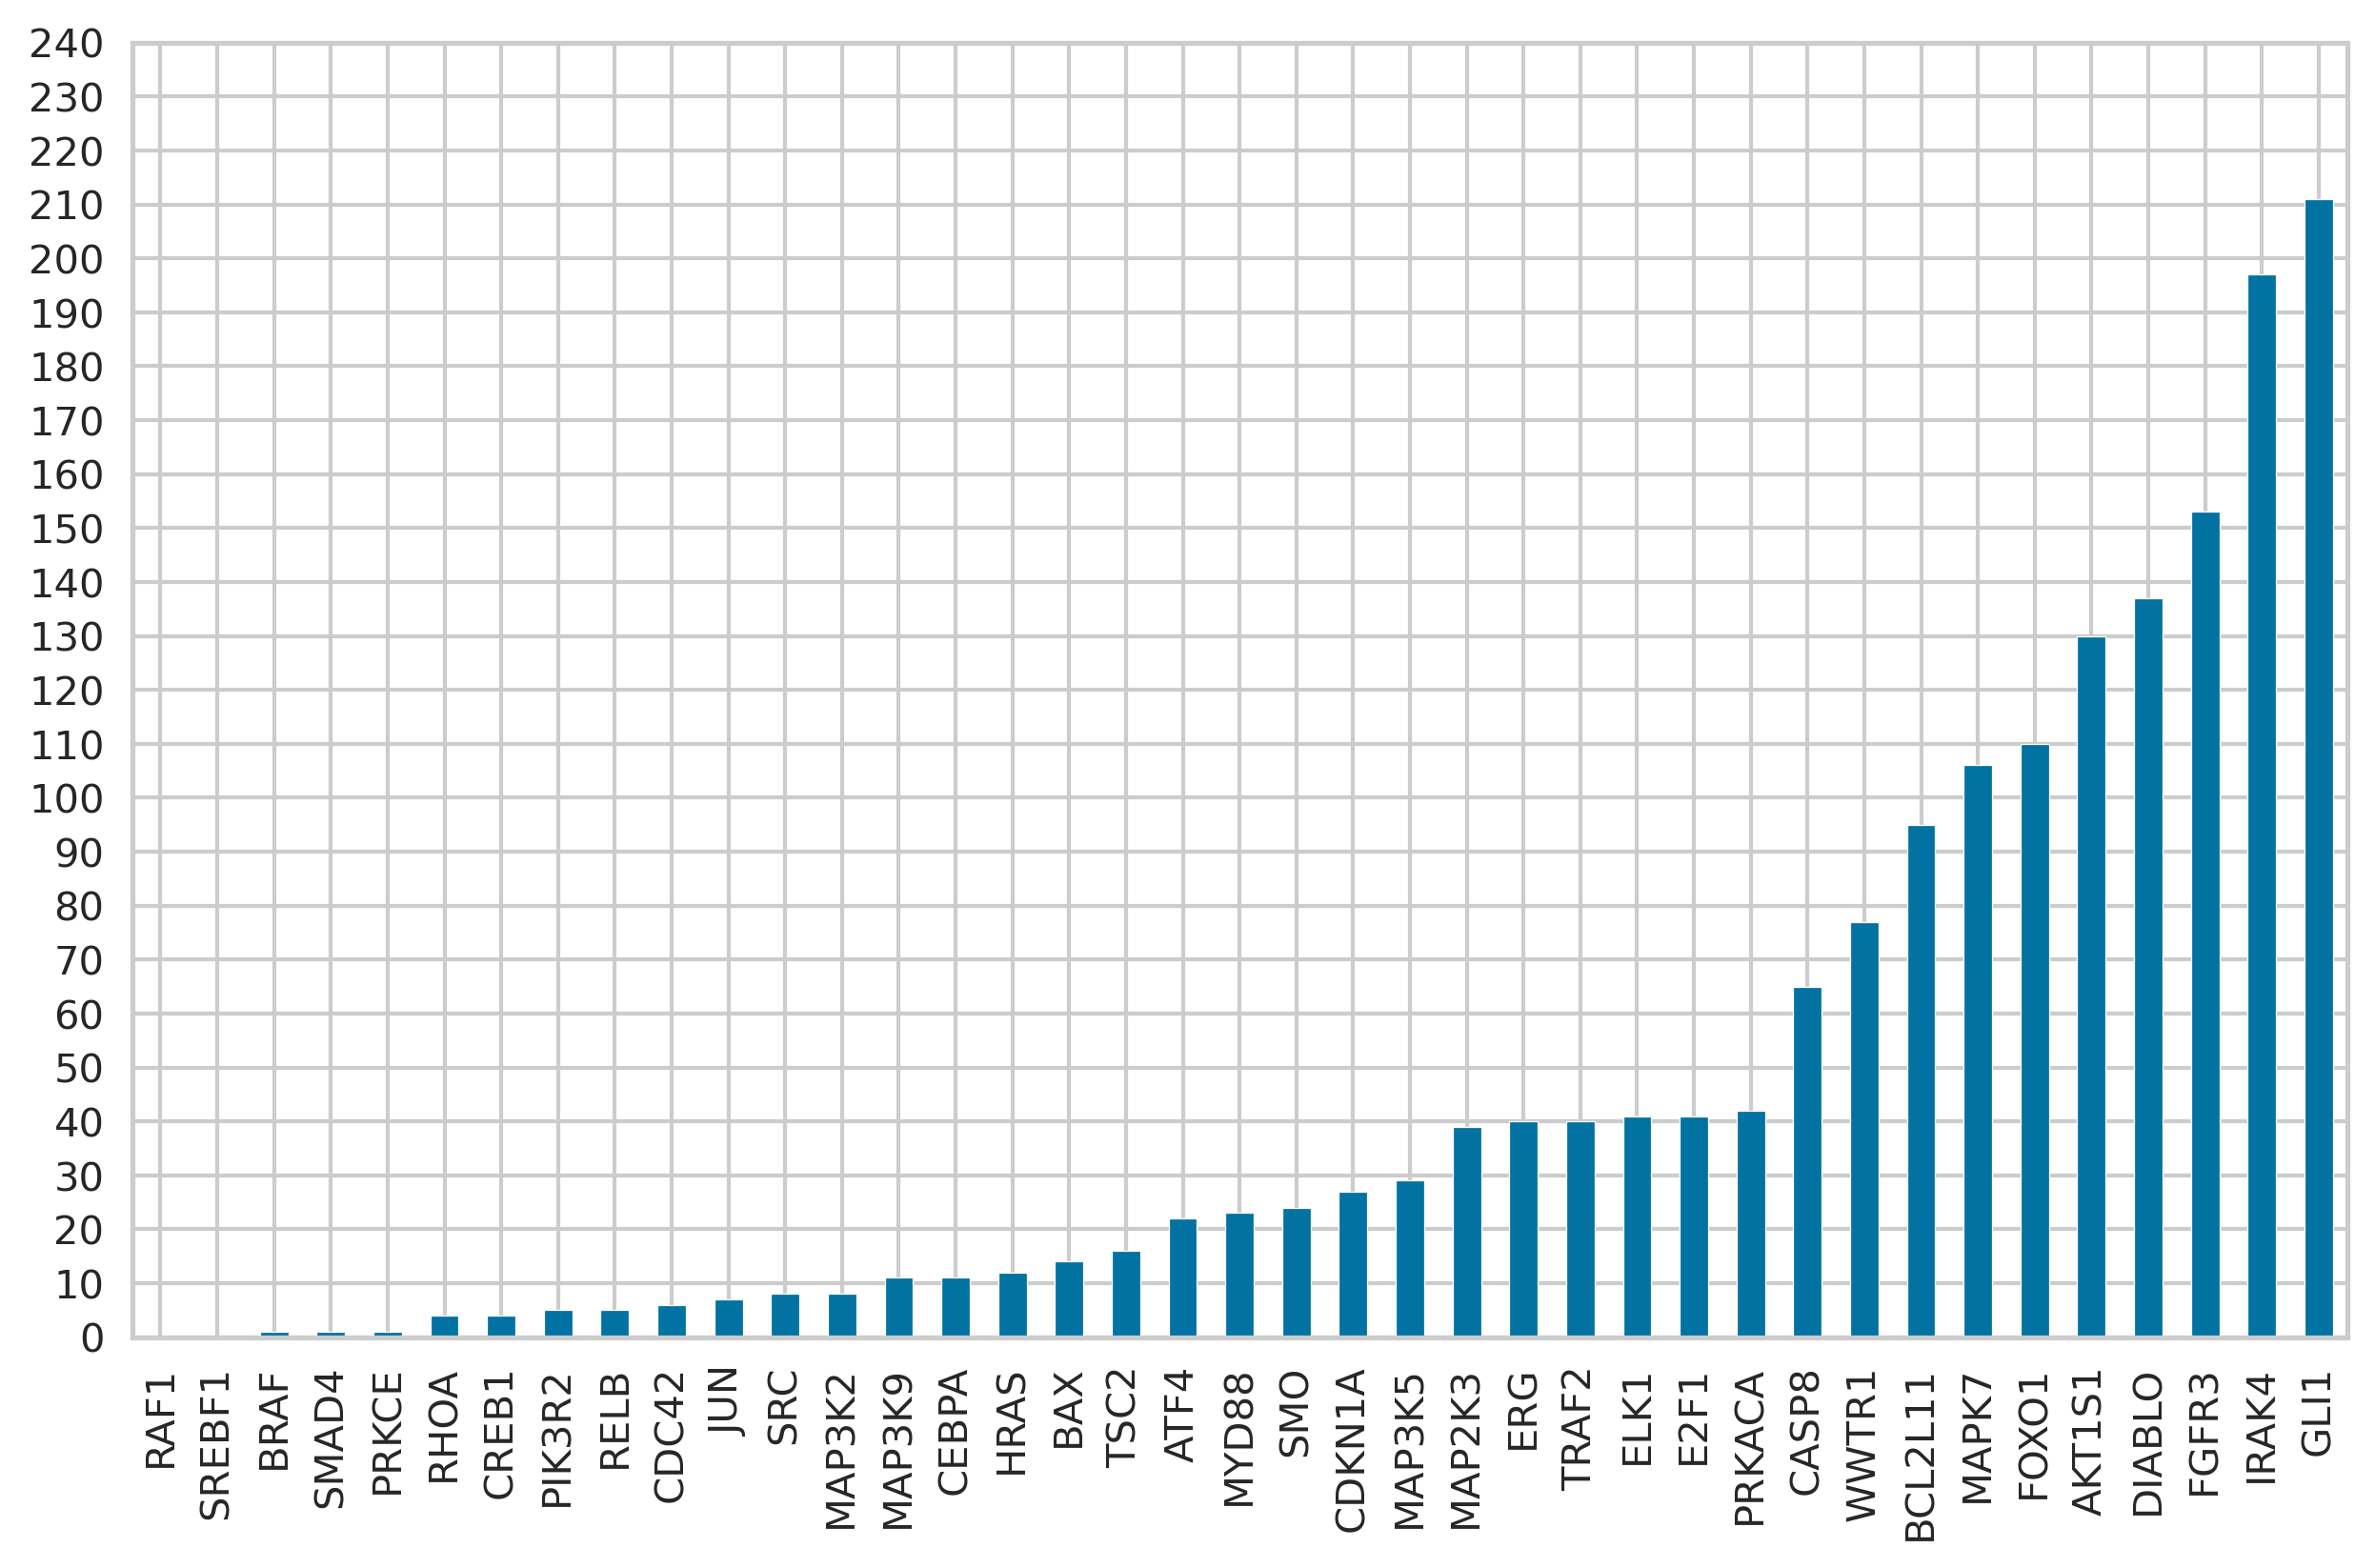

<IPython.core.display.Javascript object>

In [102]:
sns.set_style("whitegrid")
ntk_cmap_clustering_101_hit_dict = get_knn_hit_data(ntk_cmap_clustering_pred_dict_101)
ax = ntk_cmap_clustering_101_hit_dict.knn_hit.sort_values().plot(
    kind="bar", figsize=[10, 6]
)
ax.set_yticks(range(0, 250, 10))
plt.show()

---

#### Image clustering (incl. test)

In [103]:
selected_reg_pert_embs_dict = exp_embs_dict[
    "gae_exp_a1_b0_g1_split_graph_physical_full"
]

<IPython.core.display.Javascript object>

In [104]:
model_type = "ntk"
reg = ntk_image_all_clustering_result_101.loc[0, "reg"]
use_mean_train_reg_embs = ntk_image_all_clustering_result_101.loc[
    0, "use_mean_train_reg_embs"
]
n_neighbors_pos_encodings = ntk_image_all_clustering_result_101.loc[
    0, "n_neighbors_pos_encodings"
]
n_pos_encodings = ntk_image_all_clustering_result_101.loc[0, "n_pos_encodings"]
pos_encoding_type = ntk_image_all_clustering_result_101.loc[0, "pos_encoding_type"]
append_neighbor_embs = ntk_image_all_clustering_result_101.loc[
    0, "append_neighbor_embs"
]
rff_sigma = ntk_image_all_clustering_result_101.loc[0, "rff_sigma"]

<IPython.core.display.Javascript object>

In [105]:
ntk_image_all_clustering_pred_dict_101 = get_nn_prediction_dict(
    reg_embs_dict=selected_reg_pert_embs_dict["reg_embs"],
    pert_embs_dict=selected_reg_pert_embs_dict["pert_embs"],
    model_type=model_type,
    model_params_dict={"reg": reg},
    use_y_train_mean=use_mean_train_reg_embs,
    n_neighbors_weights_features=n_neighbors_pos_encodings,
    n_weight_encodings=n_pos_encodings,
    neighbor_weight_encoding=pos_encoding_type,
    append_neighbor_embs=append_neighbor_embs,
    rff_sigma=rff_sigma,
)

<IPython.core.display.Javascript object>

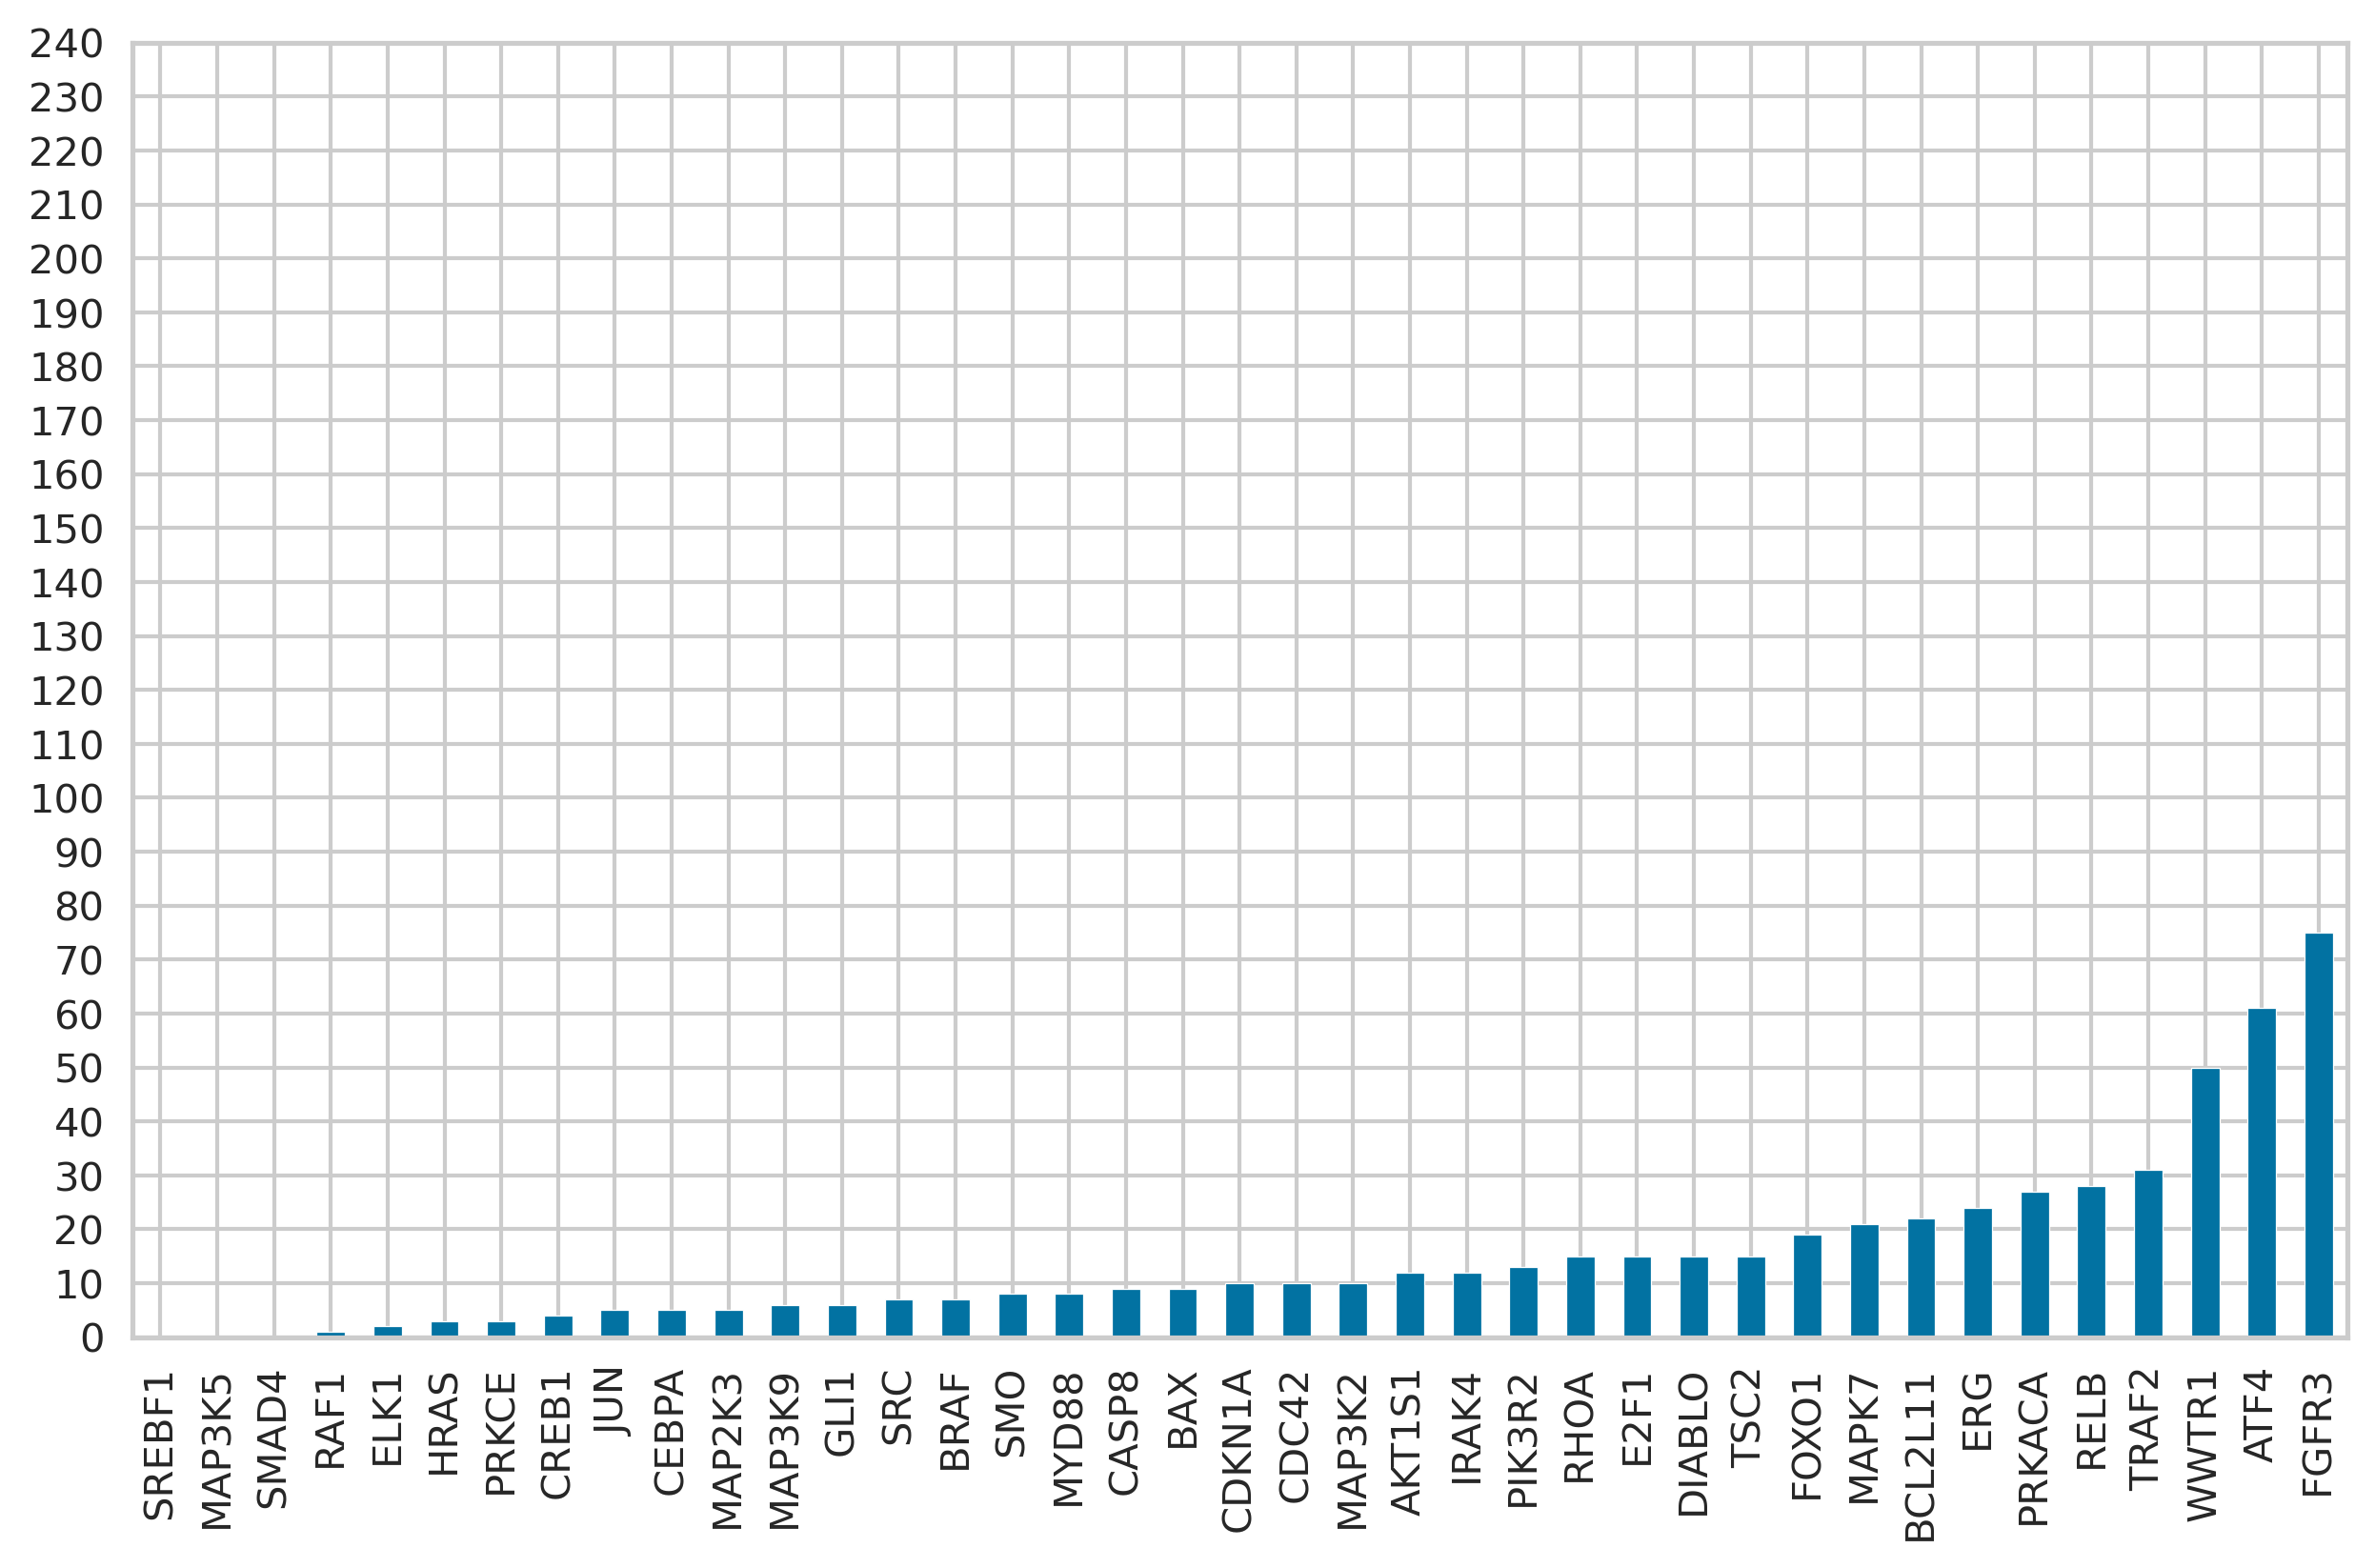

<IPython.core.display.Javascript object>

In [106]:
sns.set_style("whitegrid")
ntk_image_all_clustering_pred_dict_101 = get_knn_hit_data(
    ntk_image_all_clustering_pred_dict_101
)
ax = ntk_image_all_clustering_pred_dict_101.knn_hit.sort_values().plot(
    kind="bar", figsize=[10, 6]
)
ax.set_yticks(range(0, 250, 10))
plt.show()

---

### Graph reconstruction

In [174]:
selected_exp = "gae_exp_a0_b0_g1_split_graph_physical"


exp_gs_ntk_knn_results = all_gs_ntk_knn_results_ext.loc[
    all_gs_ntk_knn_results_ext.exp == selected_exp
]

exp_random_knn_results = all_random_knn_results.loc[
    all_random_knn_results.exp == selected_exp
]

exp_synt_int_knn_results = all_gs_synt_int_knn_results.loc[
    all_gs_synt_int_knn_results.exp == selected_exp
]

<IPython.core.display.Javascript object>

In [175]:
exp_gs_ntk_knn_results = exp_gs_ntk_knn_results.copy()
exp_gs_ntk_knn_results = exp_gs_ntk_knn_results.loc[
    (exp_gs_ntk_knn_results.n_neighbors_pos_encodings == 0)
    | (exp_gs_ntk_knn_results.n_neighbors_pos_encodings == 38)
    | (exp_gs_ntk_knn_results.append_neighbor_embs.notnull())
]

<IPython.core.display.Javascript object>

In [176]:
output_best_model_config_ids(
    results=exp_gs_ntk_knn_results,
    metric_cols=["20nn_auc", "50nn_auc"],
    n_config_ids=5,
)

,config_id,metric,value
4,1686,20nn_auc,0.148962
6,1686,50nn_auc,0.256913


<IPython.core.display.Javascript object>

In [110]:
top20nn = np.unique(exp_gs_ntk_knn_results.loc[:, "20nn_auc"])[::-1][:10]
top50nn = np.unique(exp_gs_ntk_knn_results.loc[:, "50nn_auc"])[::-1][:20]
print("Top 20NN AUC", np.round(top20nn, 6))
print("Top 50NN AUC", np.round(top50nn, 6))

Top 20NN AUC [0.150183 0.148962 0.148962 0.147741 0.147741 0.147741 0.14652  0.145299
 0.145299 0.145299]
Top 50NN AUC [0.257416 0.256913 0.256913 0.255907 0.255405 0.254902 0.254902 0.254399
 0.254399 0.253896 0.253394 0.252891 0.252388 0.251885 0.251383 0.25088
 0.250377 0.249874 0.249372 0.248869]


<IPython.core.display.Javascript object>

We find that the model with the configuration ID of 1686 of reaches the 3rd highest AUC for 20NN accuracy and the 2nd highest 30NN accuracy. We thus select that model to be representative of the optimal performance for the NTK solution when not cluster information is used.

In [111]:
ntk_image_clustering_result_001 = exp_gs_ntk_knn_results.loc[
    exp_gs_ntk_knn_results.config_id == 1686
]
ntk_image_clustering_result_001.loc[:, "model"] = "NTK (with SI)"

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<IPython.core.display.Javascript object>

In [112]:
exp_synt_int_knn_results.loc[:, "model"] = "Synthetic intervention"
image_clustering_results_001 = ntk_image_clustering_result_001.append(
    exp_synt_int_knn_results
)
image_clustering_results_101_001 = image_clustering_results_001.append(
    no_clustering_results
)
image_clustering_results_101_001.loc[
    image_clustering_results_101_001.alpha == 0, "graph"
] = "Cluster"
image_clustering_results_101_001.loc[
    image_clustering_results_101_001.alpha == 1, "graph"
] = "Graph and cluster"

<IPython.core.display.Javascript object>

Text(0, 0.5, '')

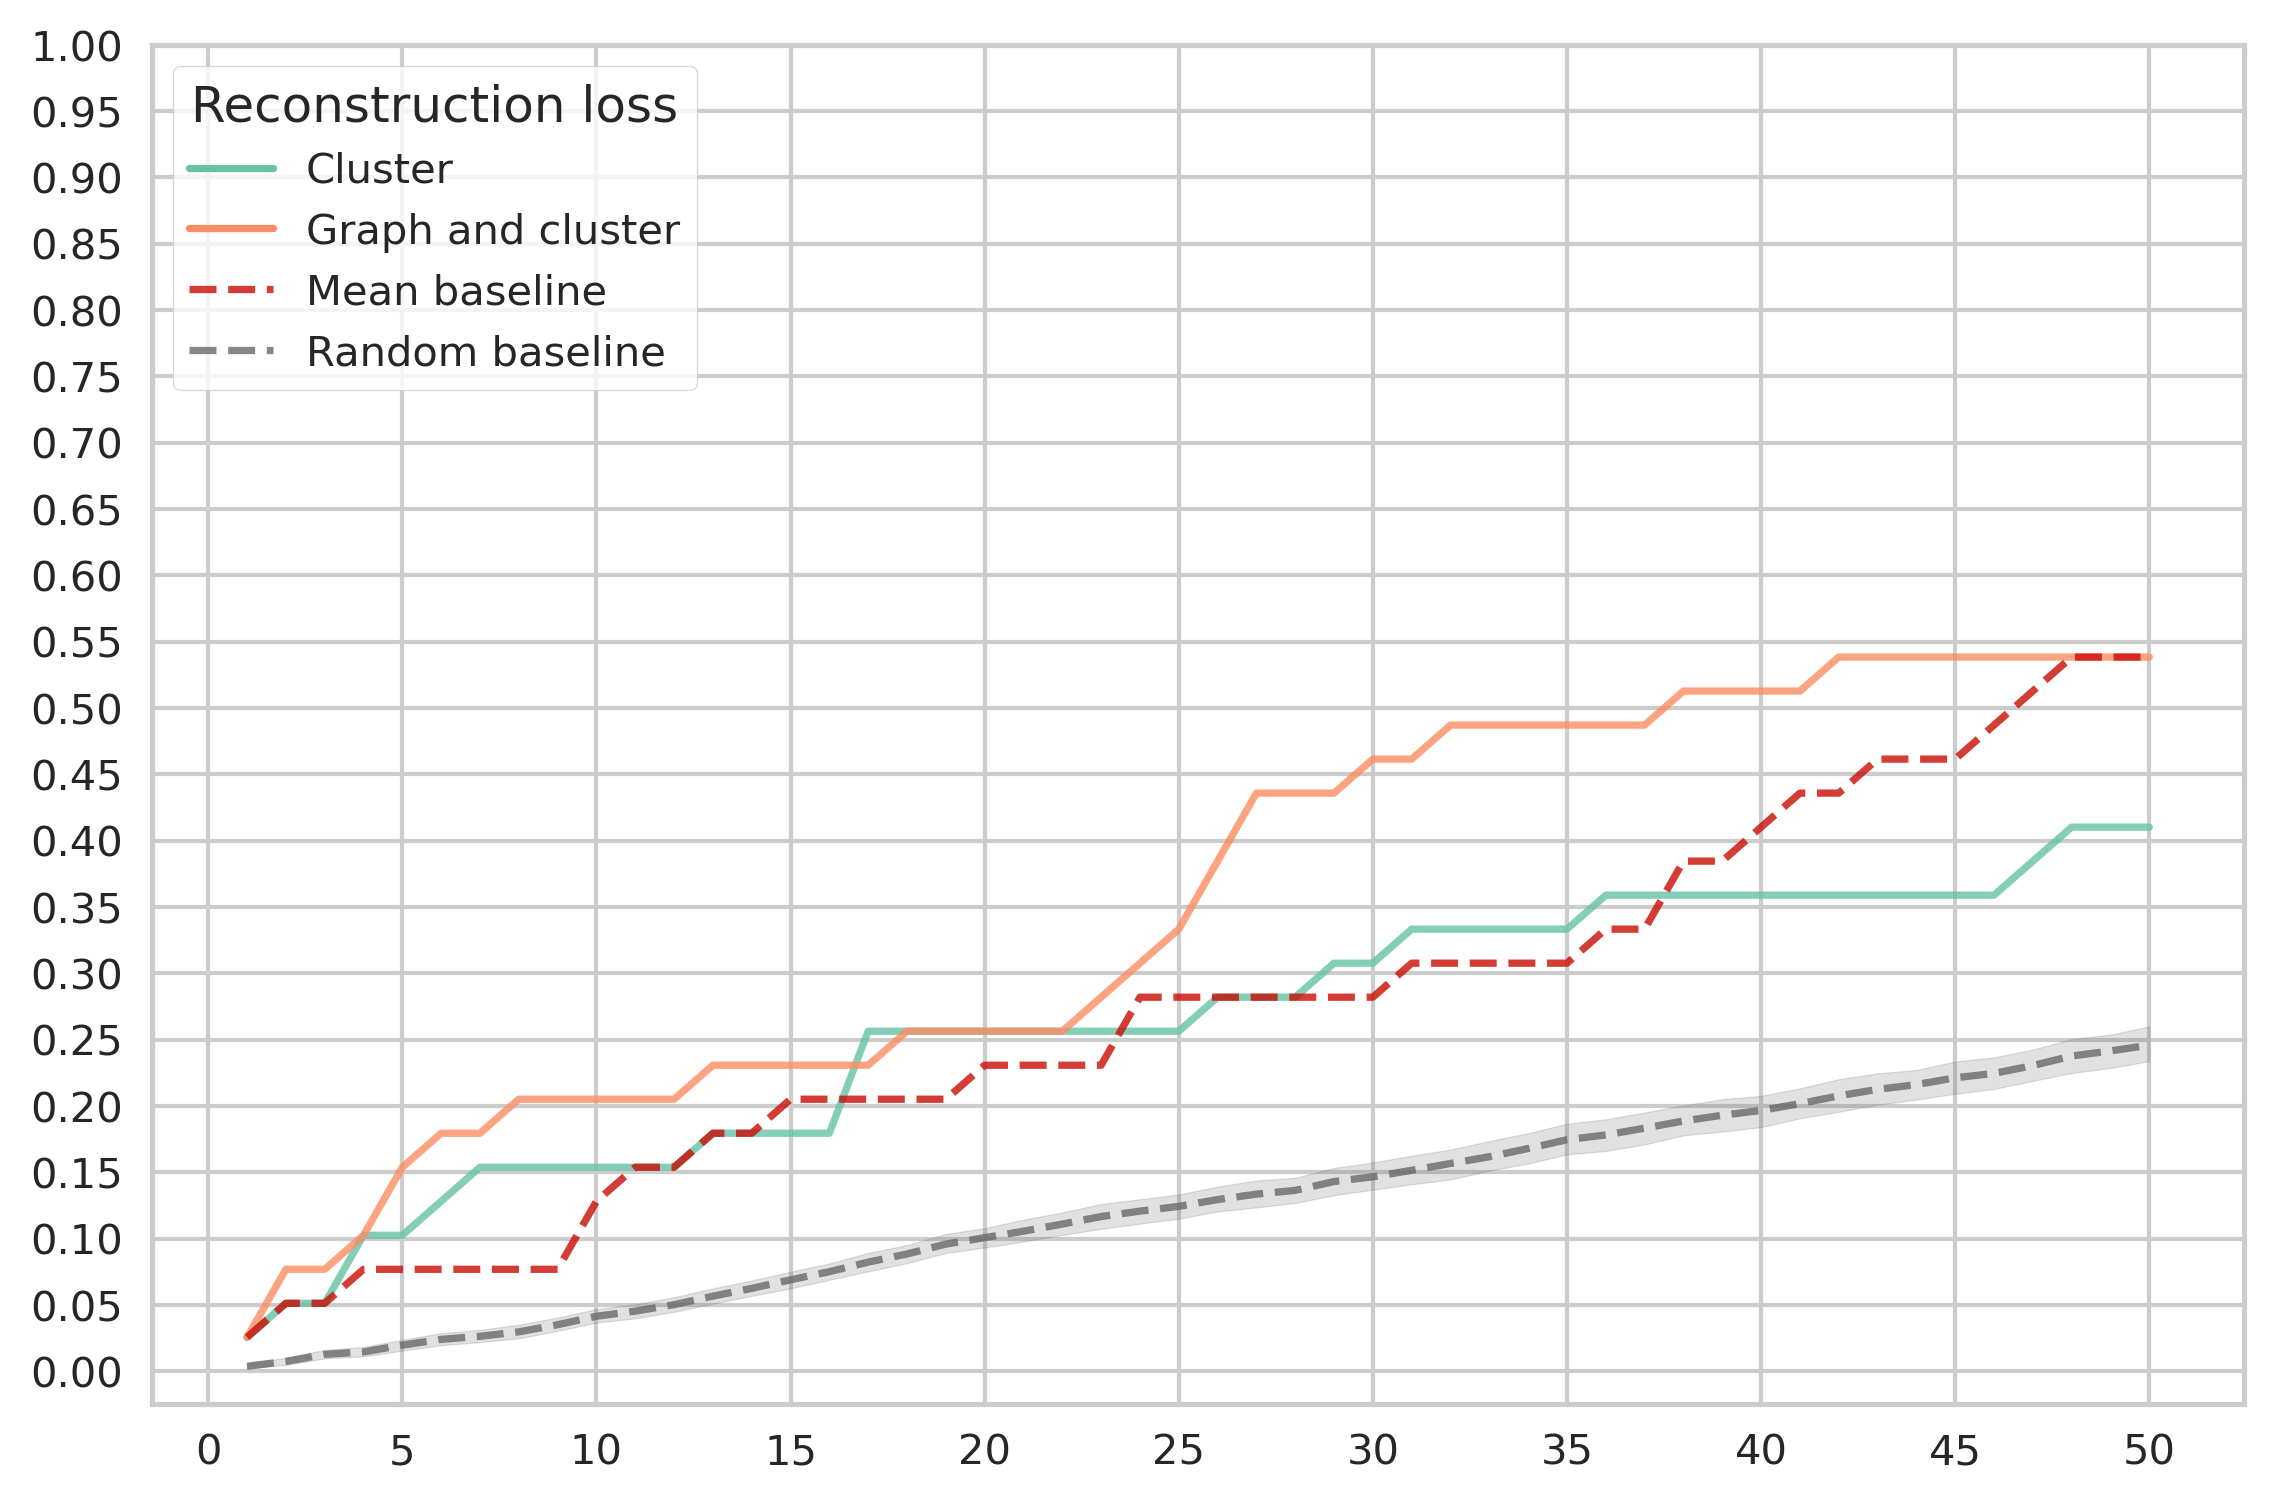

<IPython.core.display.Javascript object>

In [113]:
fig, ax = plot_translation_performance(
    results=image_clustering_results_101_001.loc[
        image_clustering_results_101_001.model == "NTK (with SI)"
    ],
    hue="graph",
    ymax=1.05,
    title="",
    random_baseline=no_clustering_random_knn_results,
    mean_baseline=mean_baseline_results,
    figsize=[9, 6],
    cmap="Set2",
    legend_title="Reconstruction loss",
)
ax.set_xlabel("")
ax.set_ylabel("")

---

### Cluster reconstruction weighting

#### No clustering reconstruction loss

In [114]:
no_clustering_results.head()

,knn_acc,k,5nn_auc,10nn_auc,15nn_auc,20nn_auc,25nn_auc,30nn_auc,50nn_auc,alpha,...,model,reg,use_mean_train_reg_embs,n_neighbors_pos_encodings,n_pos_encodings,pos_encoding_type,append_neighbor_embs,rff_sigma,config_id,exp
0,0.000000,1,0.047009,0.088578,0.120192,0.153846,0.184418,0.215054,0.315737,1,...,NTK,100.0,True,0,5,positional,images,10,1322,gae_exp_a1_b0_g0_split_graph_physical
1,0.051282,2,0.047009,0.088578,0.120192,0.153846,0.184418,0.215054,0.315737,1,...,NTK,100.0,True,0,5,positional,images,10,1322,gae_exp_a1_b0_g0_split_graph_physical
2,0.076923,3,0.047009,0.088578,0.120192,0.153846,0.184418,0.215054,0.315737,1,...,NTK,100.0,True,0,5,positional,images,10,1322,gae_exp_a1_b0_g0_split_graph_physical
3,0.076923,4,0.047009,0.088578,0.120192,0.153846,0.184418,0.215054,0.315737,1,...,NTK,100.0,True,0,5,positional,images,10,1322,gae_exp_a1_b0_g0_split_graph_physical
4,0.076923,5,0.047009,0.088578,0.120192,0.153846,0.184418,0.215054,0.315737,1,...,NTK,100.0,True,0,5,positional,images,10,1322,gae_exp_a1_b0_g0_split_graph_physical


<IPython.core.display.Javascript object>

---

#### Clustering reconstruction loss w. weight =1

In [115]:
image_clustering_results_101.head()

,knn_acc,k,5nn_auc,10nn_auc,15nn_auc,20nn_auc,25nn_auc,30nn_auc,50nn_auc,alpha,...,model,reg,use_mean_train_reg_embs,n_neighbors_pos_encodings,n_pos_encodings,pos_encoding_type,append_neighbor_embs,rff_sigma,config_id,exp
0,0.025641,1,0.038462,0.086247,0.129808,0.161172,0.189349,0.215054,0.325289,1,...,NTK,100.0,True,0,20,gauss,genes,10,1367,gae_exp_a1_b0_g1_split_graph_physical
1,0.025641,2,0.038462,0.086247,0.129808,0.161172,0.189349,0.215054,0.325289,1,...,NTK,100.0,True,0,20,gauss,genes,10,1367,gae_exp_a1_b0_g1_split_graph_physical
2,0.025641,3,0.038462,0.086247,0.129808,0.161172,0.189349,0.215054,0.325289,1,...,NTK,100.0,True,0,20,gauss,genes,10,1367,gae_exp_a1_b0_g1_split_graph_physical
3,0.076923,4,0.038462,0.086247,0.129808,0.161172,0.189349,0.215054,0.325289,1,...,NTK,100.0,True,0,20,gauss,genes,10,1367,gae_exp_a1_b0_g1_split_graph_physical
4,0.076923,5,0.038462,0.086247,0.129808,0.161172,0.189349,0.215054,0.325289,1,...,NTK,100.0,True,0,20,gauss,genes,10,1367,gae_exp_a1_b0_g1_split_graph_physical


<IPython.core.display.Javascript object>

---

#### Clustering reconstruction loss w. weight = 2

In [167]:
selected_exp = "gae_exp_a1_b0_g2_split_graph_physical"


exp_gs_ntk_knn_results = all_gs_ntk_knn_results_ext.loc[
    all_gs_ntk_knn_results_ext.exp == selected_exp
]

exp_random_knn_results = all_random_knn_results.loc[
    all_random_knn_results.exp == selected_exp
]

exp_synt_int_knn_results = all_gs_synt_int_knn_results.loc[
    all_gs_synt_int_knn_results.exp == selected_exp
]

<IPython.core.display.Javascript object>

In [168]:
exp_gs_ntk_knn_results = exp_gs_ntk_knn_results.copy()
exp_gs_ntk_knn_results = exp_gs_ntk_knn_results.loc[
    (exp_gs_ntk_knn_results.n_neighbors_pos_encodings == 0)
    | (exp_gs_ntk_knn_results.n_neighbors_pos_encodings == 38)
    | (exp_gs_ntk_knn_results.append_neighbor_embs.notnull())
]

<IPython.core.display.Javascript object>

In [169]:
output_best_model_config_ids(
    results=exp_gs_ntk_knn_results,
    metric_cols=["20nn_auc", "50nn_auc"],
    n_config_ids=245,
)

,config_id,metric,value
242,2122,20nn_auc,0.152625
482,2122,50nn_auc,0.303670


<IPython.core.display.Javascript object>

In [173]:
top20nn = np.unique(exp_gs_ntk_knn_results.loc[:, "20nn_auc"])[::-1][:20]
top50nn = np.unique(exp_gs_ntk_knn_results.loc[:, "50nn_auc"])[::-1][:70]
print("Top 20NN AUC", np.round(top20nn, 6))
print("Top 50NN AUC", np.round(top50nn, 6))

Top 20NN AUC [0.173382 0.172161 0.17094  0.169719 0.168498 0.164835 0.163614 0.162393
 0.161172 0.159951 0.15873  0.157509 0.152625 0.152625 0.151404 0.151404
 0.150183 0.150183 0.148962 0.148962]
Top 50NN AUC [0.334339 0.331322 0.33082  0.330317 0.329814 0.329814 0.329311 0.329311
 0.328808 0.328306 0.327803 0.327803 0.3273   0.326797 0.322775 0.322775
 0.322272 0.32177  0.321267 0.321267 0.320764 0.320764 0.320261 0.320261
 0.319759 0.319256 0.31825  0.317748 0.316742 0.316239 0.315737 0.315234
 0.314731 0.314228 0.313725 0.313725 0.313223 0.313223 0.31272  0.31272
 0.312217 0.312217 0.311714 0.311714 0.311212 0.311212 0.310709 0.310709
 0.310206 0.310206 0.309703 0.309703 0.309201 0.309201 0.308698 0.308195
 0.307692 0.30719  0.306687 0.306184 0.305681 0.305681 0.305178 0.305178
 0.304676 0.304173 0.304173 0.30367  0.303167 0.302665]


<IPython.core.display.Javascript object>

We find that the model with the configuration ID of 2122 of reaches the 13th highest AUC for 20NN accuracy and the 67th highest 50NN accuracy. We thus select that model to be representative of the optimal performance for the NTK solution when not cluster information is used.

In [120]:
ntk_image_clustering_result_102 = exp_gs_ntk_knn_results.loc[
    exp_gs_ntk_knn_results.config_id == 2122
]
ntk_image_clustering_result_102.loc[:, "model"] = "NTK (with SI)"

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<IPython.core.display.Javascript object>

In [121]:
exp_synt_int_knn_results.loc[:, "model"] = "SI-inspired"
image_clustering_results_102 = ntk_image_clustering_result_102.append(
    exp_synt_int_knn_results
)
image_clustering_results_102.head()

,knn_acc,k,5nn_auc,10nn_auc,15nn_auc,20nn_auc,25nn_auc,30nn_auc,50nn_auc,alpha,...,model,reg,use_mean_train_reg_embs,n_neighbors_pos_encodings,n_pos_encodings,pos_encoding_type,append_neighbor_embs,rff_sigma,config_id,exp
0,0.025641,1,0.042735,0.067599,0.115385,0.152625,0.183432,0.210918,0.30367,1,...,NTK (with SI),100.0,True,38,5,gauss,genes,5,2122,gae_exp_a1_b0_g2_split_graph_physical
1,0.025641,2,0.042735,0.067599,0.115385,0.152625,0.183432,0.210918,0.30367,1,...,NTK (with SI),100.0,True,38,5,gauss,genes,5,2122,gae_exp_a1_b0_g2_split_graph_physical
2,0.051282,3,0.042735,0.067599,0.115385,0.152625,0.183432,0.210918,0.30367,1,...,NTK (with SI),100.0,True,38,5,gauss,genes,5,2122,gae_exp_a1_b0_g2_split_graph_physical
3,0.076923,4,0.042735,0.067599,0.115385,0.152625,0.183432,0.210918,0.30367,1,...,NTK (with SI),100.0,True,38,5,gauss,genes,5,2122,gae_exp_a1_b0_g2_split_graph_physical
4,0.076923,5,0.042735,0.067599,0.115385,0.152625,0.183432,0.210918,0.30367,1,...,NTK (with SI),100.0,True,38,5,gauss,genes,5,2122,gae_exp_a1_b0_g2_split_graph_physical


<IPython.core.display.Javascript object>

---
#### Clustering loss w. weight = 5 

In [162]:
selected_exp = "gae_exp_a1_b0_g5_split_graph_physical"


exp_gs_ntk_knn_results = all_gs_ntk_knn_results_ext.loc[
    all_gs_ntk_knn_results_ext.exp == selected_exp
]

exp_random_knn_results = all_random_knn_results.loc[
    all_random_knn_results.exp == selected_exp
]

exp_synt_int_knn_results = all_gs_synt_int_knn_results.loc[
    all_gs_synt_int_knn_results.exp == selected_exp
]

<IPython.core.display.Javascript object>

In [163]:
exp_gs_ntk_knn_results = exp_gs_ntk_knn_results.copy()
exp_gs_ntk_knn_results = exp_gs_ntk_knn_results.loc[
    (exp_gs_ntk_knn_results.n_neighbors_pos_encodings == 0)
    | (exp_gs_ntk_knn_results.n_neighbors_pos_encodings == 38)
    | (exp_gs_ntk_knn_results.append_neighbor_embs.notnull())
]

<IPython.core.display.Javascript object>

In [164]:
output_best_model_config_ids(
    results=exp_gs_ntk_knn_results,
    metric_cols=["20nn_auc", "50nn_auc"],
    n_config_ids=25,
)

,config_id,metric,value
24,277,20nn_auc,0.135531
40,277,50nn_auc,0.297134


<IPython.core.display.Javascript object>

In [165]:
top20nn = np.unique(exp_gs_ntk_knn_results.loc[:, "20nn_auc"])[::-1][:10]
top50nn = np.unique(exp_gs_ntk_knn_results.loc[:, "50nn_auc"])[::-1][:10]
print("Top 20NN AUC", np.round(top20nn, 6))
print("Top 50NN AUC", np.round(top50nn, 6))

Top 20NN AUC [0.144078 0.141636 0.141636 0.140415 0.140415 0.139194 0.137973 0.136752
 0.135531 0.135531]
Top 50NN AUC [0.302665 0.301659 0.301156 0.299145 0.297637 0.297134 0.296129 0.295626
 0.295123 0.29462 ]


<IPython.core.display.Javascript object>

We find that the model with the configuration ID of 277 of reaches the 9th highest AUC for 20NN accuracy and the 5th highest 50NN accuracy. We thus select that model to be representative of the optimal performance for the NTK solution when not cluster information is used.

In [126]:
ntk_image_clustering_result_105 = exp_gs_ntk_knn_results.loc[
    exp_gs_ntk_knn_results.config_id == 277
]
ntk_image_clustering_result_105.loc[:, "model"] = "NTK (with SI)"

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<IPython.core.display.Javascript object>

In [127]:
exp_synt_int_knn_results.loc[:, "model"] = "SI-inspired"
image_clustering_results_105 = ntk_image_clustering_result_105.append(
    exp_synt_int_knn_results
)
image_clustering_results_105.head()

,knn_acc,k,5nn_auc,10nn_auc,15nn_auc,20nn_auc,25nn_auc,30nn_auc,50nn_auc,alpha,...,model,reg,use_mean_train_reg_embs,n_neighbors_pos_encodings,n_pos_encodings,pos_encoding_type,append_neighbor_embs,rff_sigma,config_id,exp
0,0.000000,1,0.029915,0.060606,0.096154,0.135531,0.171598,0.204301,0.297134,1,...,NTK (with SI),1.0,True,10,20,positional,images,5,277,gae_exp_a1_b0_g5_split_graph_physical
1,0.025641,2,0.029915,0.060606,0.096154,0.135531,0.171598,0.204301,0.297134,1,...,NTK (with SI),1.0,True,10,20,positional,images,5,277,gae_exp_a1_b0_g5_split_graph_physical
2,0.051282,3,0.029915,0.060606,0.096154,0.135531,0.171598,0.204301,0.297134,1,...,NTK (with SI),1.0,True,10,20,positional,images,5,277,gae_exp_a1_b0_g5_split_graph_physical
3,0.051282,4,0.029915,0.060606,0.096154,0.135531,0.171598,0.204301,0.297134,1,...,NTK (with SI),1.0,True,10,20,positional,images,5,277,gae_exp_a1_b0_g5_split_graph_physical
4,0.051282,5,0.029915,0.060606,0.096154,0.135531,0.171598,0.204301,0.297134,1,...,NTK (with SI),1.0,True,10,20,positional,images,5,277,gae_exp_a1_b0_g5_split_graph_physical


<IPython.core.display.Javascript object>

---

#### Summary

In [128]:
cluster_recon_loss_results = [
    no_clustering_results,
    image_clustering_results_101,
    image_clustering_results_102,
    image_clustering_results_105,
]
cluster_recon_loss_results = pd.concat(cluster_recon_loss_results)

<IPython.core.display.Javascript object>

Text(0, 0.5, '')

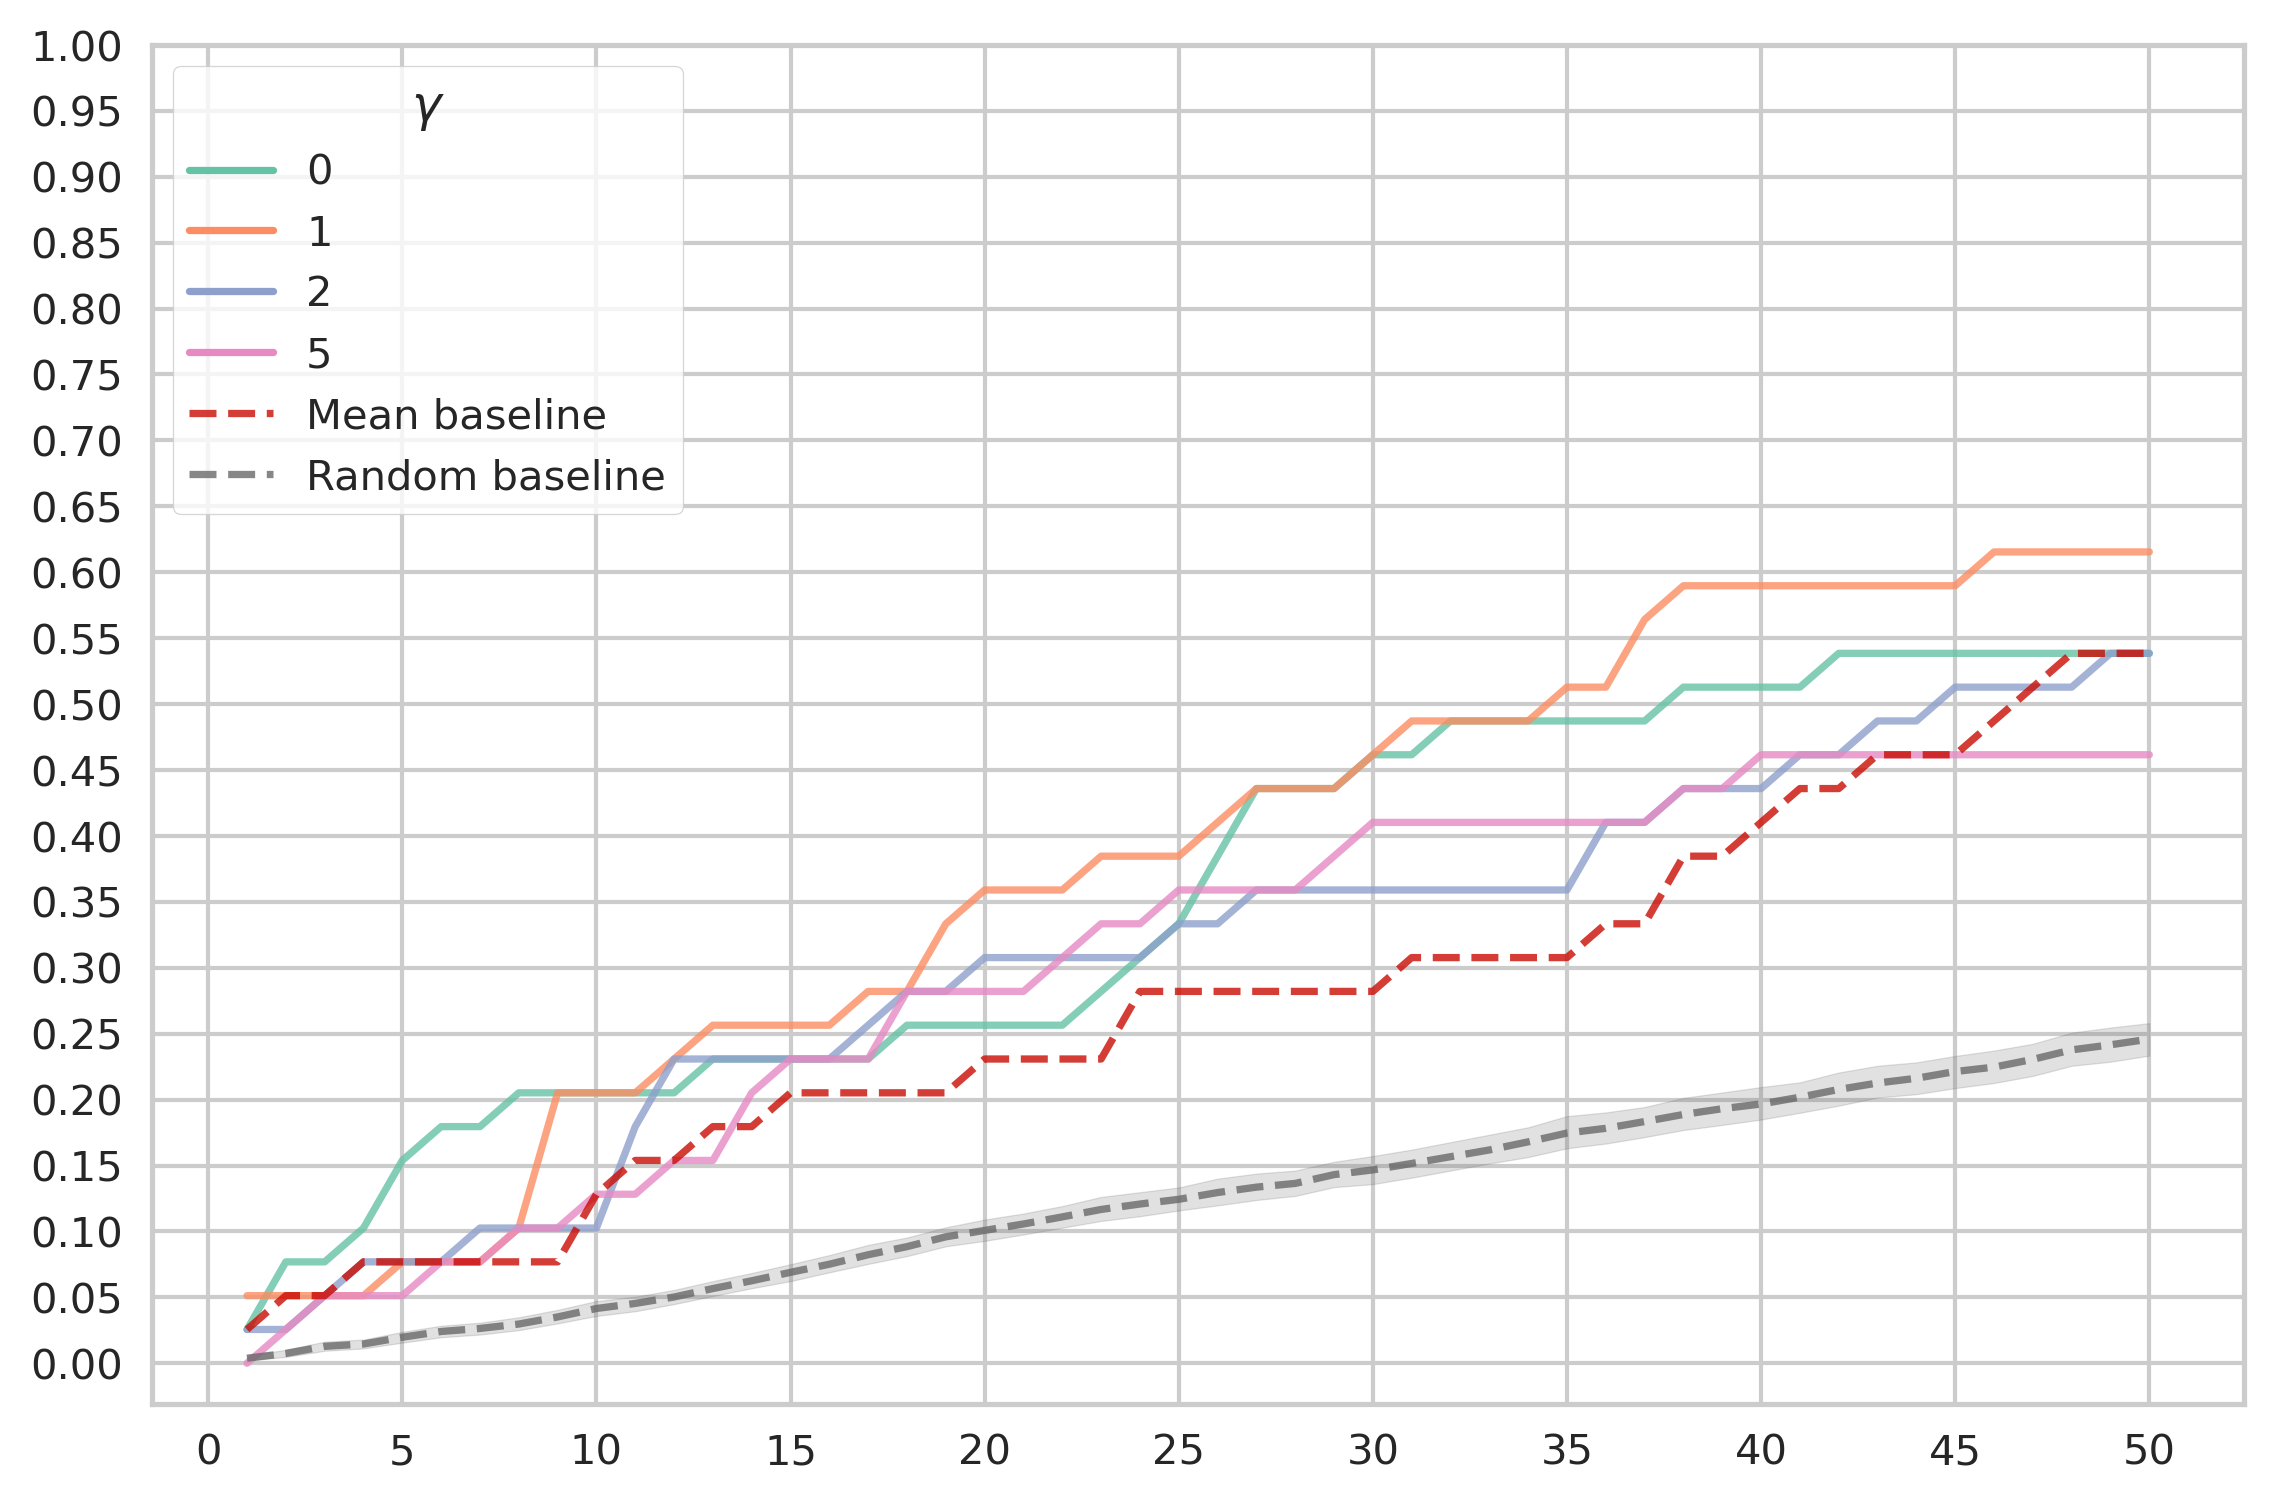

<IPython.core.display.Javascript object>

In [129]:
fig, ax = plot_translation_performance(
    results=cluster_recon_loss_results.loc[
        cluster_recon_loss_results.model == "NTK (with SI)"
    ],
    hue="gamma",
    ymax=1.05,
    title="",
    random_baseline=no_clustering_random_knn_results,
    mean_baseline=mean_baseline_results,
    figsize=[9, 6],
    cmap="Set2",
    legend_title=r"$\gamma$",
)
ax.set_xlabel("")
ax.set_ylabel("")

---

### Feature reconstruction weighting

#### Feature reconstruction loss w. weight=0

In [130]:
image_clustering_results_101.head()

,knn_acc,k,5nn_auc,10nn_auc,15nn_auc,20nn_auc,25nn_auc,30nn_auc,50nn_auc,alpha,...,model,reg,use_mean_train_reg_embs,n_neighbors_pos_encodings,n_pos_encodings,pos_encoding_type,append_neighbor_embs,rff_sigma,config_id,exp
0,0.025641,1,0.038462,0.086247,0.129808,0.161172,0.189349,0.215054,0.325289,1,...,NTK,100.0,True,0,20,gauss,genes,10,1367,gae_exp_a1_b0_g1_split_graph_physical
1,0.025641,2,0.038462,0.086247,0.129808,0.161172,0.189349,0.215054,0.325289,1,...,NTK,100.0,True,0,20,gauss,genes,10,1367,gae_exp_a1_b0_g1_split_graph_physical
2,0.025641,3,0.038462,0.086247,0.129808,0.161172,0.189349,0.215054,0.325289,1,...,NTK,100.0,True,0,20,gauss,genes,10,1367,gae_exp_a1_b0_g1_split_graph_physical
3,0.076923,4,0.038462,0.086247,0.129808,0.161172,0.189349,0.215054,0.325289,1,...,NTK,100.0,True,0,20,gauss,genes,10,1367,gae_exp_a1_b0_g1_split_graph_physical
4,0.076923,5,0.038462,0.086247,0.129808,0.161172,0.189349,0.215054,0.325289,1,...,NTK,100.0,True,0,20,gauss,genes,10,1367,gae_exp_a1_b0_g1_split_graph_physical


<IPython.core.display.Javascript object>

---

#### Feature reconstruction loss w. weight=1

In [158]:
selected_exp = "gae_exp_a1_b1_g1_split_graph_physical"


exp_gs_ntk_knn_results = all_gs_ntk_knn_results_ext.loc[
    all_gs_ntk_knn_results_ext.exp == selected_exp
]

exp_random_knn_results = all_random_knn_results.loc[
    all_random_knn_results.exp == selected_exp
]

exp_synt_int_knn_results = all_gs_synt_int_knn_results.loc[
    all_gs_synt_int_knn_results.exp == selected_exp
]

<IPython.core.display.Javascript object>

In [159]:
exp_gs_ntk_knn_results = exp_gs_ntk_knn_results.copy()
exp_gs_ntk_knn_results = exp_gs_ntk_knn_results.loc[
    (exp_gs_ntk_knn_results.n_neighbors_pos_encodings == 0)
    | (exp_gs_ntk_knn_results.n_neighbors_pos_encodings == 38)
    | (exp_gs_ntk_knn_results.append_neighbor_embs.notnull())
]

<IPython.core.display.Javascript object>

In [160]:
output_best_model_config_ids(
    results=exp_gs_ntk_knn_results,
    metric_cols=["20nn_auc", "50nn_auc"],
    n_config_ids=103,
)

,config_id,metric,value
100,1128,20nn_auc,0.164835
133,1128,50nn_auc,0.339367


<IPython.core.display.Javascript object>

In [161]:
top20nn = np.unique(exp_gs_ntk_knn_results.loc[:, "20nn_auc"])[::-1][:20]
top50nn = np.unique(exp_gs_ntk_knn_results.loc[:, "50nn_auc"])[::-1][:20]
print("Top 20NN AUC", np.round(top20nn, 6))
print("Top 50NN AUC", np.round(top50nn, 6))

Top 20NN AUC [0.173382 0.172161 0.172161 0.17094  0.17094  0.169719 0.169719 0.168498
 0.168498 0.167277 0.167277 0.166056 0.166056 0.164835 0.164835 0.163614
 0.163614 0.162393 0.162393 0.161172]
Top 50NN AUC [0.355958 0.351936 0.351433 0.348416 0.347914 0.347411 0.346405 0.345902
 0.344897 0.340875 0.340372 0.340372 0.339869 0.339367 0.339367 0.338864
 0.338361 0.337858 0.337355 0.336853]


<IPython.core.display.Javascript object>

We find that the model with the configuration ID of 1128 of reaches the 14th highest AUC for 20NN accuracy and the 13th highest 50NN accuracy. We thus select that model to be representative of the optimal performance for the NTK solution when not cluster information is used.

In [135]:
ntk_image_clustering_result_111 = exp_gs_ntk_knn_results.loc[
    exp_gs_ntk_knn_results.config_id == 1128
]
ntk_image_clustering_result_111.loc[:, "model"] = "NTK (with SI)"

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<IPython.core.display.Javascript object>

In [136]:
exp_synt_int_knn_results.loc[:, "model"] = "SI-inspired"
image_clustering_results_111 = ntk_image_clustering_result_111.append(
    exp_synt_int_knn_results
)
image_clustering_results_111.head()

,knn_acc,k,5nn_auc,10nn_auc,15nn_auc,20nn_auc,25nn_auc,30nn_auc,50nn_auc,alpha,...,model,reg,use_mean_train_reg_embs,n_neighbors_pos_encodings,n_pos_encodings,pos_encoding_type,append_neighbor_embs,rff_sigma,config_id,exp
0,0.025641,1,0.034188,0.079254,0.123397,0.164835,0.193294,0.222498,0.339367,1,...,NTK (with SI),50.0,True,10,10,positional,genes,1,1128,gae_exp_a1_b1_g1_split_graph_physical
1,0.025641,2,0.034188,0.079254,0.123397,0.164835,0.193294,0.222498,0.339367,1,...,NTK (with SI),50.0,True,10,10,positional,genes,1,1128,gae_exp_a1_b1_g1_split_graph_physical
2,0.051282,3,0.034188,0.079254,0.123397,0.164835,0.193294,0.222498,0.339367,1,...,NTK (with SI),50.0,True,10,10,positional,genes,1,1128,gae_exp_a1_b1_g1_split_graph_physical
3,0.051282,4,0.034188,0.079254,0.123397,0.164835,0.193294,0.222498,0.339367,1,...,NTK (with SI),50.0,True,10,10,positional,genes,1,1128,gae_exp_a1_b1_g1_split_graph_physical
4,0.051282,5,0.034188,0.079254,0.123397,0.164835,0.193294,0.222498,0.339367,1,...,NTK (with SI),50.0,True,10,10,positional,genes,1,1128,gae_exp_a1_b1_g1_split_graph_physical


<IPython.core.display.Javascript object>

---

#### Feature reconstruction loss w. weight=2

In [153]:
selected_exp = "gae_exp_a1_b2_g1_split_graph_physical"


exp_gs_ntk_knn_results = all_gs_ntk_knn_results_ext.loc[
    all_gs_ntk_knn_results_ext.exp == selected_exp
]

exp_random_knn_results = all_random_knn_results.loc[
    all_random_knn_results.exp == selected_exp
]

exp_synt_int_knn_results = all_gs_synt_int_knn_results.loc[
    all_gs_synt_int_knn_results.exp == selected_exp
]

<IPython.core.display.Javascript object>

In [154]:
exp_gs_ntk_knn_results = exp_gs_ntk_knn_results.copy()
exp_gs_ntk_knn_results = exp_gs_ntk_knn_results.loc[
    (exp_gs_ntk_knn_results.n_neighbors_pos_encodings == 0)
    | (exp_gs_ntk_knn_results.n_neighbors_pos_encodings == 38)
    | (exp_gs_ntk_knn_results.append_neighbor_embs.notnull())
]

<IPython.core.display.Javascript object>

In [155]:
output_best_model_config_ids(
    results=exp_gs_ntk_knn_results,
    metric_cols=["20nn_auc", "50nn_auc"],
    n_config_ids=100,
)

,config_id,metric,value
95,1654,20nn_auc,0.167277
108,1654,50nn_auc,0.341378


<IPython.core.display.Javascript object>

In [157]:
top20nn = np.unique(exp_gs_ntk_knn_results.loc[:, "20nn_auc"])[::-1][:20]
top50nn = np.unique(exp_gs_ntk_knn_results.loc[:, "50nn_auc"])[::-1][:20]
print("Top 20NN AUC", np.round(top20nn, 6))
print("Top 50NN AUC", np.round(top50nn, 6))

Top 20NN AUC [0.180708 0.179487 0.178266 0.177045 0.175824 0.174603 0.173382 0.172161
 0.17094  0.17094  0.169719 0.168498 0.168498 0.167277 0.167277 0.166056
 0.166056 0.164835 0.164835 0.163614]
Top 50NN AUC [0.344394 0.343389 0.342886 0.34188  0.341378 0.340372 0.339367 0.338361
 0.338361 0.337858 0.337355 0.336853 0.33635  0.335847 0.335344 0.334842
 0.334339 0.333836 0.333333 0.332831]


<IPython.core.display.Javascript object>

We find that the model with the configuration ID of 1654 of reaches the 14th highest AUC for 20NN accuracy and the 5th highest 50NN accuracy. We thus select that model to be representative of the optimal performance for the NTK solution when not cluster information is used.

In [141]:
ntk_image_clustering_result_121 = exp_gs_ntk_knn_results.loc[
    exp_gs_ntk_knn_results.config_id == 1654
]
ntk_image_clustering_result_121.loc[:, "model"] = "NTK (with SI)"

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<IPython.core.display.Javascript object>

In [142]:
exp_synt_int_knn_results.loc[:, "model"] = "SI-inspired"
image_clustering_results_121 = ntk_image_clustering_result_121.append(
    exp_synt_int_knn_results
)
image_clustering_results_121.head()

,knn_acc,k,5nn_auc,10nn_auc,15nn_auc,20nn_auc,25nn_auc,30nn_auc,50nn_auc,alpha,...,model,reg,use_mean_train_reg_embs,n_neighbors_pos_encodings,n_pos_encodings,pos_encoding_type,append_neighbor_embs,rff_sigma,config_id,exp
0,0.025641,1,0.038462,0.09324,0.129808,0.167277,0.205128,0.235732,0.341378,1,...,NTK (with SI),5.0,False,38,20,gauss,genes,5,1654,gae_exp_a1_b2_g1_split_graph_physical
1,0.051282,2,0.038462,0.09324,0.129808,0.167277,0.205128,0.235732,0.341378,1,...,NTK (with SI),5.0,False,38,20,gauss,genes,5,1654,gae_exp_a1_b2_g1_split_graph_physical
2,0.051282,3,0.038462,0.09324,0.129808,0.167277,0.205128,0.235732,0.341378,1,...,NTK (with SI),5.0,False,38,20,gauss,genes,5,1654,gae_exp_a1_b2_g1_split_graph_physical
3,0.051282,4,0.038462,0.09324,0.129808,0.167277,0.205128,0.235732,0.341378,1,...,NTK (with SI),5.0,False,38,20,gauss,genes,5,1654,gae_exp_a1_b2_g1_split_graph_physical
4,0.051282,5,0.038462,0.09324,0.129808,0.167277,0.205128,0.235732,0.341378,1,...,NTK (with SI),5.0,False,38,20,gauss,genes,5,1654,gae_exp_a1_b2_g1_split_graph_physical


<IPython.core.display.Javascript object>

---

#### Feature reconstruction loss w. weight=5

In [143]:
selected_exp = "gae_exp_a1_b5_g1_split_graph_physical"


exp_gs_ntk_knn_results = all_gs_ntk_knn_results_ext.loc[
    all_gs_ntk_knn_results_ext.exp == selected_exp
]

exp_random_knn_results = all_random_knn_results.loc[
    all_random_knn_results.exp == selected_exp
]

exp_synt_int_knn_results = all_gs_synt_int_knn_results.loc[
    all_gs_synt_int_knn_results.exp == selected_exp
]

<IPython.core.display.Javascript object>

In [144]:
exp_gs_ntk_knn_results = exp_gs_ntk_knn_results.copy()
exp_gs_ntk_knn_results = exp_gs_ntk_knn_results.loc[
    (exp_gs_ntk_knn_results.n_neighbors_pos_encodings == 0)
    | (exp_gs_ntk_knn_results.n_neighbors_pos_encodings == 38)
    | (exp_gs_ntk_knn_results.append_neighbor_embs.notnull())
]

<IPython.core.display.Javascript object>

In [145]:
output_best_model_config_ids(
    results=exp_gs_ntk_knn_results,
    metric_cols=["20nn_auc", "50nn_auc"],
    n_config_ids=50,
)

,config_id,metric,value
42,1295,20nn_auc,0.180708
65,1295,50nn_auc,0.332328


<IPython.core.display.Javascript object>

In [152]:
top20nn = np.unique(exp_gs_ntk_knn_results.loc[:, "20nn_auc"])[::-1][:20]
top50nn = np.unique(exp_gs_ntk_knn_results.loc[:, "50nn_auc"])[::-1][:20]
print("Top 20NN AUC", np.round(top20nn, 6))
print("Top 50NN AUC", np.round(top50nn, 6))

Top 20NN AUC [0.185592 0.184371 0.18315  0.181929 0.180708 0.180708 0.179487 0.178266
 0.178266 0.177045 0.177045 0.177045 0.175824 0.175824 0.175824 0.175824
 0.174603 0.174603 0.174603 0.173382]
Top 50NN AUC [0.339367 0.338864 0.338361 0.338361 0.337858 0.33635  0.335847 0.334339
 0.333836 0.333333 0.332831 0.332328 0.331825 0.331322 0.331322 0.33082
 0.33082  0.33082  0.330317 0.330317]


<IPython.core.display.Javascript object>

We find that the model with the configuration ID of 1295 of reaches the 5th highest AUC for 20NN accuracy and the 12th highest 50NN accuracy. We thus select that model to be representative of the optimal performance for the NTK solution when not cluster information is used.

In [147]:
ntk_image_clustering_result_151 = exp_gs_ntk_knn_results.loc[
    exp_gs_ntk_knn_results.config_id == 1295
]
ntk_image_clustering_result_151.loc[:, "model"] = "NTK (with SI)"

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<IPython.core.display.Javascript object>

In [148]:
exp_synt_int_knn_results.loc[:, "model"] = "SI-inspired"
image_clustering_results_151 = ntk_image_clustering_result_151.append(
    exp_synt_int_knn_results
)
image_clustering_results_151.head()

,knn_acc,k,5nn_auc,10nn_auc,15nn_auc,20nn_auc,25nn_auc,30nn_auc,50nn_auc,alpha,...,model,reg,use_mean_train_reg_embs,n_neighbors_pos_encodings,n_pos_encodings,pos_encoding_type,append_neighbor_embs,rff_sigma,config_id,exp
0,0.000000,1,0.029915,0.086247,0.139423,0.180708,0.21499,0.244003,0.332328,1,...,NTK (with SI),100.0,False,10,20,gauss,genes,10,1295,gae_exp_a1_b5_g1_split_graph_physical
1,0.025641,2,0.029915,0.086247,0.139423,0.180708,0.21499,0.244003,0.332328,1,...,NTK (with SI),100.0,False,10,20,gauss,genes,10,1295,gae_exp_a1_b5_g1_split_graph_physical
2,0.051282,3,0.029915,0.086247,0.139423,0.180708,0.21499,0.244003,0.332328,1,...,NTK (with SI),100.0,False,10,20,gauss,genes,10,1295,gae_exp_a1_b5_g1_split_graph_physical
3,0.051282,4,0.029915,0.086247,0.139423,0.180708,0.21499,0.244003,0.332328,1,...,NTK (with SI),100.0,False,10,20,gauss,genes,10,1295,gae_exp_a1_b5_g1_split_graph_physical
4,0.051282,5,0.029915,0.086247,0.139423,0.180708,0.21499,0.244003,0.332328,1,...,NTK (with SI),100.0,False,10,20,gauss,genes,10,1295,gae_exp_a1_b5_g1_split_graph_physical


<IPython.core.display.Javascript object>

---

#### Summary feature reconstruction

In [149]:
feature_recon_results = [
    image_clustering_results_101,
    image_clustering_results_111,
    image_clustering_results_121,
    image_clustering_results_151,
]
feature_recon_results = pd.concat(feature_recon_results)

<IPython.core.display.Javascript object>

Text(0, 0.5, '')

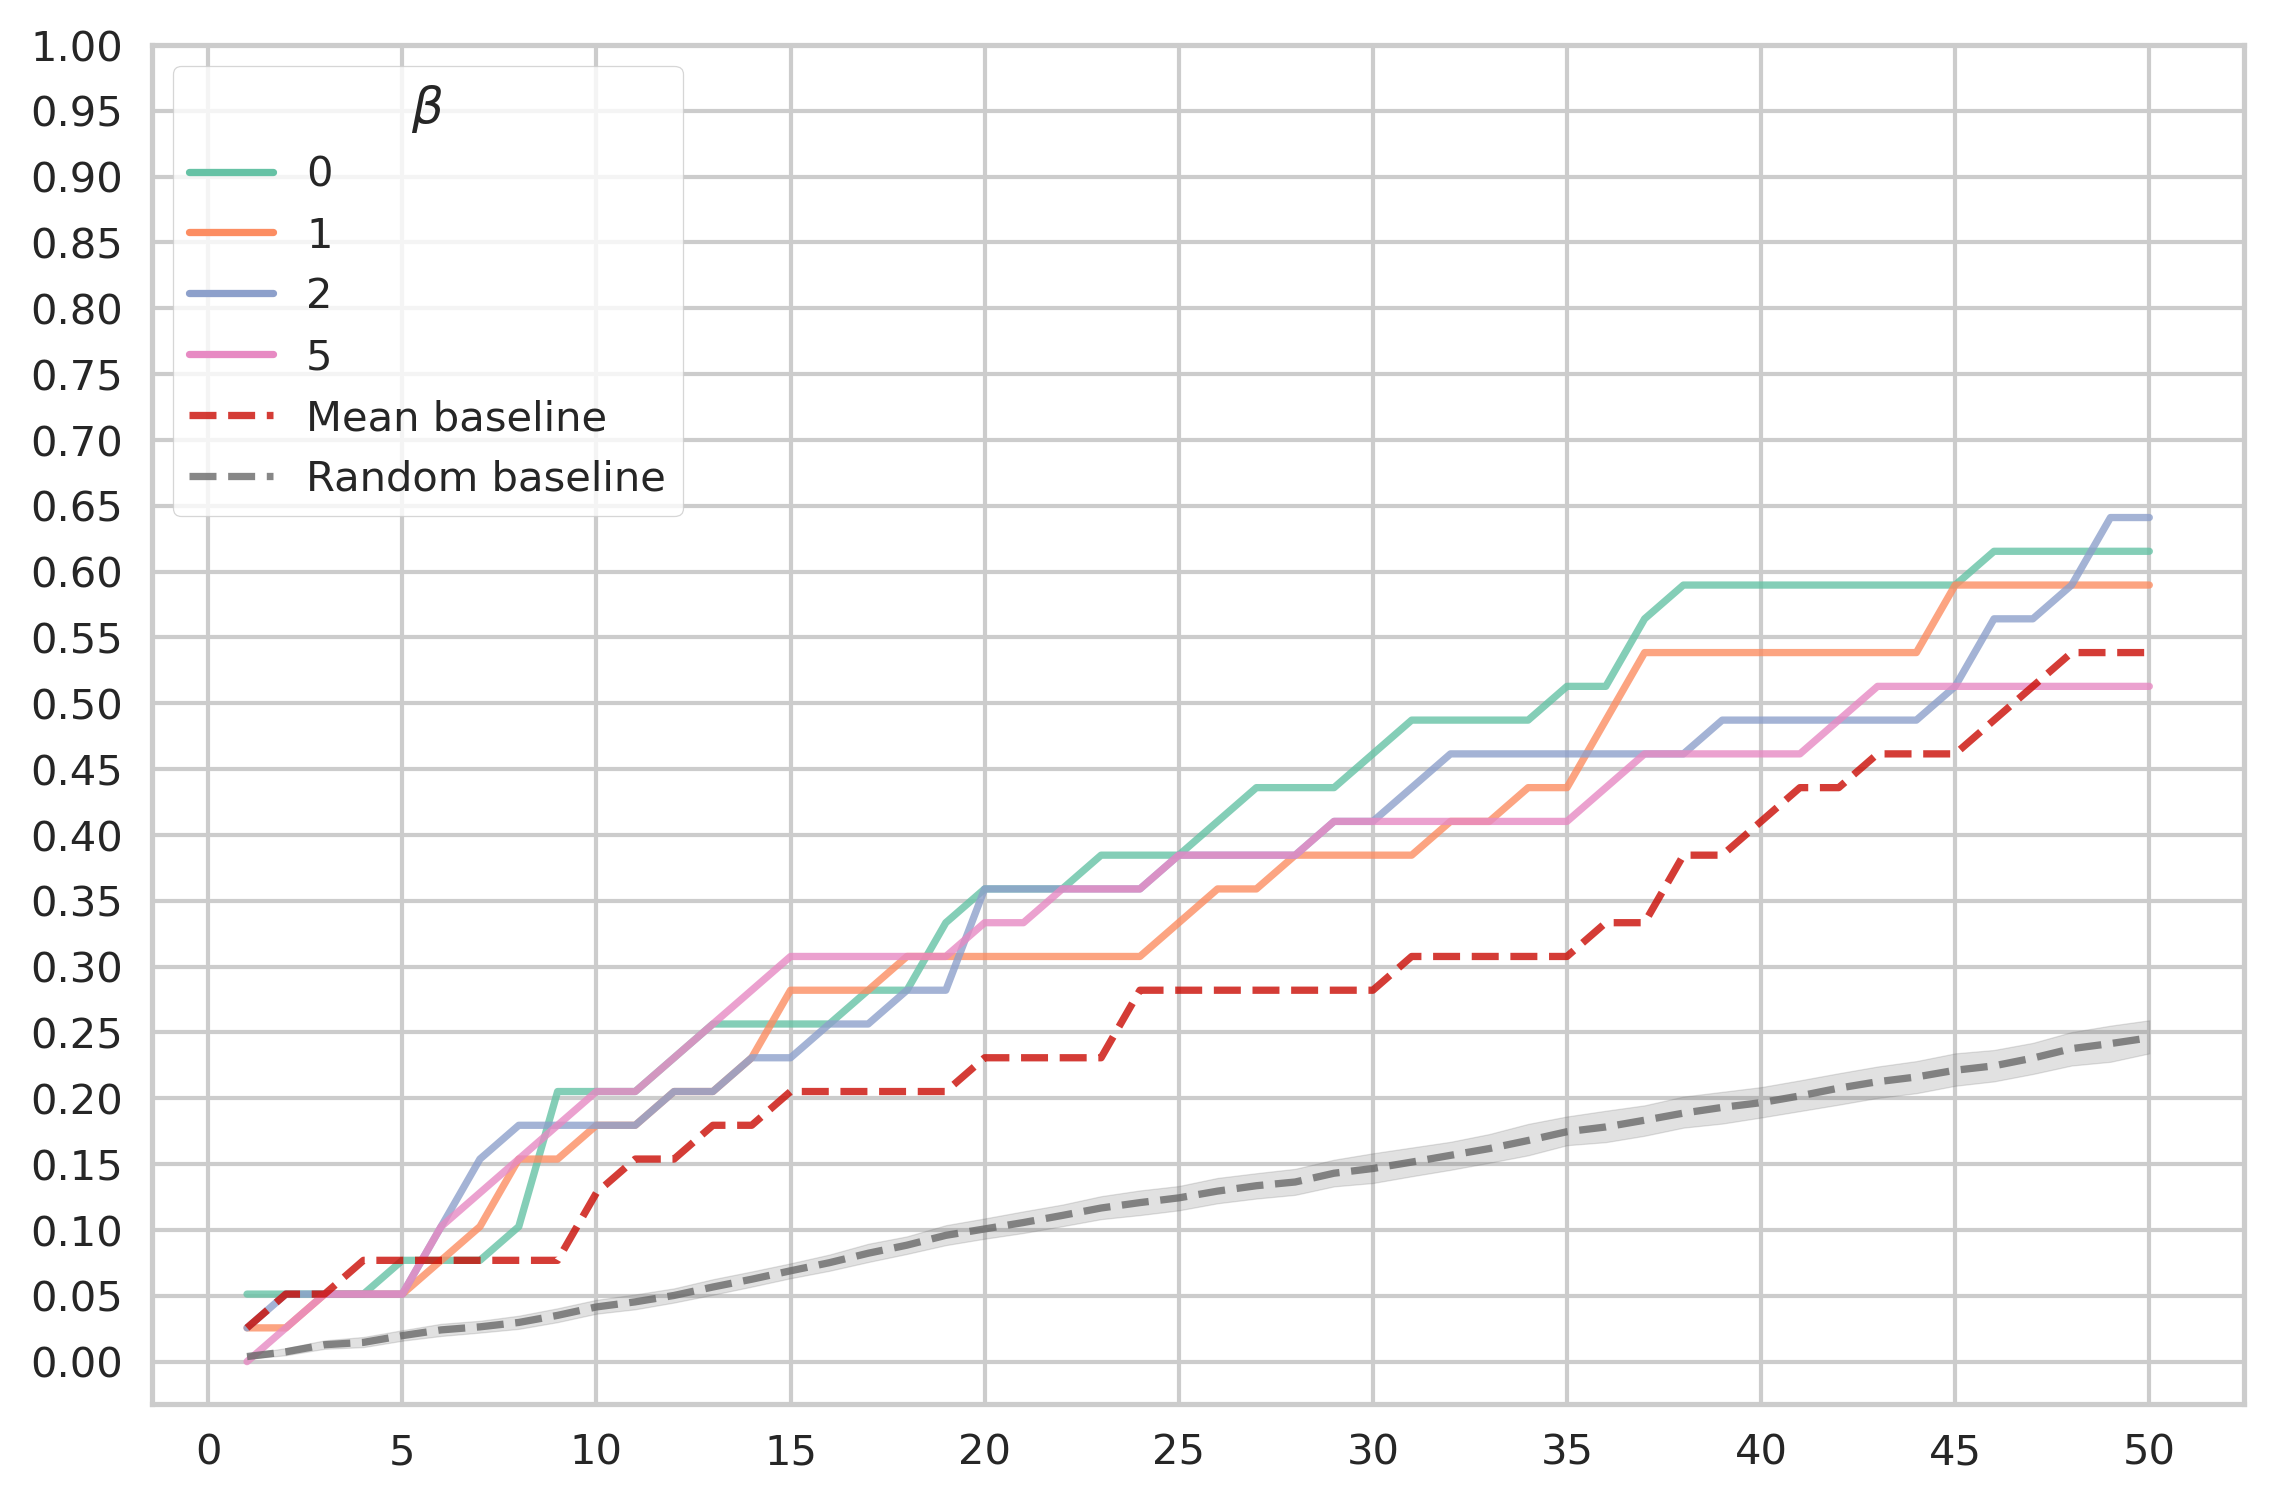

<IPython.core.display.Javascript object>

In [150]:
fig, ax = plot_translation_performance(
    results=feature_recon_results.loc[feature_recon_results.model == "NTK (with SI)"],
    hue="beta",
    ymax=1.05,
    title="",
    random_baseline=no_clustering_random_knn_results,
    mean_baseline=mean_baseline_results,
    figsize=[9, 6],
    cmap="Set2",
    legend_title=r"$\beta$",
)
ax.set_xlabel("")
ax.set_ylabel("")

----
## Supplemental visualization of the NTK prediction.

In [ ]:
selected_reg_pert_embs_dict = exp_embs_dict["gae_exp_a1_b0_g1_split_graph_physical"]

In [ ]:
model_type = "ntk"
reg = ntk_image_clustering_result_101.loc[0, "reg"]
use_mean_train_reg_embs = ntk_image_clustering_result_101.loc[
    0, "use_mean_train_reg_embs"
]
n_neighbors_pos_encodings = ntk_image_clustering_result_101.loc[
    0, "n_neighbors_pos_encodings"
]
n_pos_encodings = ntk_image_clustering_result_101.loc[0, "n_pos_encodings"]
pos_encoding_type = ntk_image_clustering_result_101.loc[0, "pos_encoding_type"]
append_neighbor_embs = ntk_image_clustering_result_101.loc[0, "append_neighbor_embs"]
rff_sigma = ntk_image_clustering_result_101.loc[0, "rff_sigma"]

In [ ]:
(
    ntk_image_clustering_nn_pred_dict_101,
    ntk_image_clustering_emb_pred_dict,
) = get_nn_prediction_dict(
    reg_embs_dict=selected_reg_pert_embs_dict["reg_embs"],
    pert_embs_dict=selected_reg_pert_embs_dict["pert_embs"],
    model_type=model_type,
    model_params_dict={"reg": reg},
    use_y_train_mean=use_mean_train_reg_embs,
    n_neighbors_weights_features=n_neighbors_pos_encodings,
    n_weight_encodings=n_pos_encodings,
    neighbor_weight_encoding=pos_encoding_type,
    append_neighbor_embs=append_neighbor_embs,
    rff_sigma=rff_sigma,
    return_predicted_embeddings=True,
)

In [ ]:
mpl.style.use("default")

In [ ]:
shared_targets = set(
    selected_reg_pert_embs_dict["reg_embs"]["EMPTY"].index
).intersection(selected_reg_pert_embs_dict["pert_embs"]["EMPTY"].index)

In [ ]:
selected_targets = np.random.choice(list(shared_targets), size=10)

In [ ]:
pert_clusters = pd.read_csv(
    "../../../data/other/mean_physical_clusters.csv", index_col=0
)
pert_cluster_dict = {}
for target in shared_targets:

    pert_cluster_dict[target] = set(
        pert_clusters.loc[
            pert_clusters.cluster == pert_clusters.loc[target, "cluster"]
        ].index
    ).intersection(shared_targets) - {target}

In [ ]:
ntk_image_clustering_nn_pred_dict_101["ELK1"]

---

#### JUN

In [ ]:
target = "ELK1"

In [ ]:
target_pert_tsne_embs, target_reg_tsne_embs = get_tsne_translation_prediction(
    pert_embs_dict=selected_reg_pert_embs_dict["pert_embs"],
    reg_embs_dict=selected_reg_pert_embs_dict["reg_embs"],
    reg_pred_dict=ntk_image_clustering_emb_pred_dict,
    target=target,
    perplexity=None,
)

In [ ]:
target_pert_nns = get_nearest_neighbors_for_target(
    selected_reg_pert_embs_dict["pert_embs"][target],
    target=target,
    selected_targets=shared_targets,
)[0]

##### Image embeddings

In [ ]:
fig, ax = plt.subplots(figsize=[7, 4], dpi=600)
fig, ax = plot_translation(
    embs=target_pert_tsne_embs,
    prediction=target,
    fig=fig,
    ax=ax,
    lw=2,
    alpha=1,
    target_size=20,
    pred_size=40,
    size=10,
    color="tab:blue",
    p_alpha=0.5,
    neighbor_size=8,
    mark_neighbors=selected_targets,
    label_points=selected_targets,
    reg_label_size=6,
)
ax.set_facecolor("ghostwhite")

In [ ]:
fig, ax = plt.subplots(figsize=[21, 12])
ax = plot_tsne_embs(
    target_pert_tsne_embs,
    label_points=list(target_pert_tsne_embs.index),
    ax=ax,
    target=target,
)

---

##### Gene embeddings

In [ ]:
fig, ax = plt.subplots(figsize=[7, 4], dpi=600)
fig, ax = plot_translation(
    embs=target_reg_tsne_embs,
    target=target,
    fig=fig,
    ax=ax,
    prediction="PREDICTION",
    pred_size=40,
    pred_color="r",
    target_color="forestgreen",
    lw=2,
    alpha=1,
    target_size=20,
    size=4,
    p_alpha=0.5,
    neighbor_size=10,
    mark_neighbors=selected_targets,
    reg_label_size=5,
    label_points=selected_targets,
)
ax.set_facecolor("snow")

In [ ]:
fig, ax = plt.subplots(figsize=[28, 12])
ax = plot_tsne_embs(
    target_reg_tsne_embs,
    label_points=list(target_reg_tsne_embs.index),
    ax=ax,
    target=target,
)